# NETWORK INTRUSION DETECTION SYSTEM

**Student:** Anton Horvat  
**Course:** AI, Machine Learning & Data - Semester 4  
**Challenge:** 2 - Network Intrusion Detection  
**Date:** November 2024

---

## Project Overview

This project develops a machine learning-based Intrusion Detection System (IDS) to classify network traffic into five categories: 
- Normal, DoS (Denial of Service), 
- Probe (reconnaissance), 
- R2L (Remote to Local unauthorized access), 
- and U2R (User to Root privilege escalation). 

- The focus is on creating an explainable AI system that helps security analysts understand why certain traffic is flagged as malicious, going beyond simple attack detection to provide actionable insights for incident response.

**Dataset Age & Source:**
- **Created:** 2009 (improved version of KDD Cup 1999 dataset)
- **Original KDD'99:** Based on 1998 DARPA network traffic data
- **NSL-KDD improvements:** Removed redundant records, better test set distribution
- **Official Link:** https://www.unb.ca/cic/datasets/nsl.html
- **Alternative (Kaggle):** https://www.kaggle.com/datasets/hassan06/nslkdd
- **GitHub Repository:** https://github.com/defcom17/NSL_KDD


**Approach:** Multi-class classification with emphasis on transparency, interpretability, and explainability

---

# 🛠️ SETUP / Data Collection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# XGBoost 

# Metrics
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)



plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 📥 Load NSL-KDD Dataset

### Dataset Information:

**Source:** University of New Brunswick - Canadian Institute for Cybersecurity  

**Dataset Characteristics:**
- Training set: 125,973 samples
- Test set: 22,544 samples  
- Features: 41 network flow features + 1 difficulty level
- Target: Attack type (normal, dos, probe, r2l, u2r)

-  Note: NSL-KDD provides separate train and test sets to prevent data leakage and enable standardized benchmarking. 
  The test set contains different attack variations not seen in training, simulating real-world scenarios where new  attack patterns emerge. 
  Using these official splits ensures fair evaluation and comparability with established research.
  For detailed explanations of all 41 features and their importance in detecting different attack types, please refer to my Data Requirements NID document.
---

In [2]:
# The NSL-KDD dataset files don't come with column headers, 
# so I need to define them manually based on the official documentation I found.
# I organized them into categories to make it easier to understand what each feature does.

column_names = [
    # Basic features
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent',
    
    # Content features
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    
    # Time-based features (2-second window)
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    
    # Host-based features (100-connection window)
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    
    # Target variables
    'attack_type', 'difficulty_level'
]


# I'm downloading the NSL-KDD dataset directly from GitHub so anyone can run this notebook without having to manually download files first

import urllib.request
import os

# GitHub URLs for the dataset
TRAIN_URL = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"
TEST_URL = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt"

train_file_path = 'KDDTrain+.txt'
test_file_path = 'KDDTest+.txt'

# Download files if they don't exist yet
if not os.path.exists(train_file_path):
    urllib.request.urlretrieve(TRAIN_URL, train_file_path)

if not os.path.exists(test_file_path):
    urllib.request.urlretrieve(TEST_URL, test_file_path)

# Load the data
train_data = pd.read_csv(train_file_path, names=column_names, header=None)
test_data = pd.read_csv(test_file_path, names=column_names, header=None)
df = pd.concat([train_data, test_data], ignore_index=True)

total_samples = len(train_data) + len(test_data)
print(f"✅ Data loaded: {total_samples:,} total samples")
print(f"   Training: {len(train_data):,} | Test: {len(test_data):,}")

DATA_LOADED = True

✅ Data loaded: 148,517 total samples
   Training: 125,973 | Test: 22,544


## Analysis 🔬 of Data Loading

### Understanding the Security Features:

I spent time researching what each feature category actually means for detecting attacks:

**1. Basic Connection Features:**
- Basic Connection Features (9 features): Fundamental properties like protocol type, connection duration, data volume, and connection status that reveal the nature of network traffic.

**2. Content Features (What Happened):**
These tell me what actually occurred during the connection:
- Content Features (13 features): What happened during the connection - login attempts, file operations, access to sensitive system resources, and compromised conditions. These directly reveal malicious actions.

**3. Time-based Features (2-second windows):**
These look at patterns over short time periods:
- Time-based Features (9 features, 2-second window): Patterns over short time periods that detect attack bursts - connection rates, error rates, and service access patterns that identify DoS floods and rapid scanning.

**4. Host-based Features (100-connection windows):**
These track longer-term patterns:
- Host-based Features (10 features, 100-connection window): Longer-term patterns that reveal sustained attacks - persistent scanning, ongoing attack campaigns, and behavioral trends over minutes rather than seconds.

### Why I Trust This Data:

I was really careful about data quality because my teacher warned me about using random Kaggle uploads. Here's why NSL-KDD is reliable:

**What makes it trustworthy:**
-  It comes from an actual university (UNB - Canadian Institute for Cybersecurity)
-  The methodology was peer-reviewed and published in academic papers
-  Over 1000 research papers have used it, so I can compare my results
-  They documented exactly how they cleaned the data (removed duplicates from the old KDD'99 dataset)
-  Clear documentation explaining every single feature

---

In [3]:
# ============================================================================
# FIRST LOOK AT THE DATA
# ============================================================================

print("="*80)
print("📊 FIRST LOOK AT NSL-KDD TRAINING DATA")
print("="*80)

# Dataset dimensions
print(f"\n1. DATASET SHAPE")
print(f"   Rows (samples): {train_data.shape[0]:,}")
print(f"   Columns (features): {train_data.shape[1]}")

# First few rows
print(f"\n2. FIRST 5 ROWS OF DATA:")
print("-"*80)
display(train_data.head())

# Column names
print(f"\n3. ALL COLUMN NAMES ({len(train_data.columns)} total):")
print("-"*80)
for i, col in enumerate(train_data.columns, 1):
    print(f"{i:2d}. {col}")

📊 FIRST LOOK AT NSL-KDD TRAINING DATA

1. DATASET SHAPE
   Rows (samples): 125,973
   Columns (features): 43

2. FIRST 5 ROWS OF DATA:
--------------------------------------------------------------------------------


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21



3. ALL COLUMN NAMES (43 total):
--------------------------------------------------------------------------------
 1. duration
 2. protocol_type
 3. service
 4. flag
 5. src_bytes
 6. dst_bytes
 7. land
 8. wrong_fragment
 9. urgent
10. hot
11. num_failed_logins
12. logged_in
13. num_compromised
14. root_shell
15. su_attempted
16. num_root
17. num_file_creations
18. num_shells
19. num_access_files
20. num_outbound_cmds
21. is_host_login
22. is_guest_login
23. count
24. srv_count
25. serror_rate
26. srv_serror_rate
27. rerror_rate
28. srv_rerror_rate
29. same_srv_rate
30. diff_srv_rate
31. srv_diff_host_rate
32. dst_host_count
33. dst_host_srv_count
34. dst_host_same_srv_rate
35. dst_host_diff_srv_rate
36. dst_host_same_src_port_rate
37. dst_host_srv_diff_host_rate
38. dst_host_serror_rate
39. dst_host_srv_serror_rate
40. dst_host_rerror_rate
41. dst_host_srv_rerror_rate
42. attack_type
43. difficulty_level


In [4]:
# ============================================================================
# MISSING VALUES CHECK
# ============================================================================

print("\n" + "="*80)
print("🔍 MISSING VALUES CHECK")
print("="*80)

missing_values = train_data.isnull().sum()
total_missing = missing_values.sum()

if total_missing == 0:
    print("EXCELLENT: No missing values found!")
    print(f"   All {len(train_data):,} rows are complete.")
else:
    print(f"Found {total_missing} missing values:")
    print("\nColumns with missing values:")
    print(missing_values[missing_values > 0])

# Double-check with info
print("\n" + "-"*80)
print("Data Types and Non-Null Counts:")
print("-"*80)
train_data.info()


🔍 MISSING VALUES CHECK
EXCELLENT: No missing values found!
   All 125,973 rows are complete.

--------------------------------------------------------------------------------
Data Types and Non-Null Counts:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgen

In [5]:
# ============================================================================
# FEATURE TYPES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("📋 FEATURE TYPES BREAKDOWN")
print("="*80)

# Separate features by type
categorical_features = ['protocol_type', 'service', 'flag']
binary_features = ['land', 'logged_in', 'root_shell', 'su_attempted', 
                  'is_host_login', 'is_guest_login']
target_variables = ['attack_type', 'difficulty_level']

# Calculate numerical features (everything else)
all_features = set(train_data.columns)
known_features = set(categorical_features + binary_features + target_variables)
numerical_features = list(all_features - known_features - {'attack_category', 'is_attack'})  # Exclude our created columns

print(f"\n1. CATEGORICAL FEATURES ({len(categorical_features)}):")
for feature in categorical_features:
    unique_count = train_data[feature].nunique()
    print(f"   - {feature}: {unique_count} unique values")

print(f"\n2. BINARY FEATURES ({len(binary_features)}):")
for feature in binary_features:
    unique_vals = train_data[feature].unique()
    print(f"   - {feature}: values = {sorted(unique_vals)}")

print(f"\n3. NUMERICAL FEATURES ({len(numerical_features)}):")
print(f"   Examples: {', '.join(numerical_features[:8])}...")

print(f"\n4. TARGET VARIABLES ({len(target_variables)}):")
for feature in target_variables:
    print(f"   - {feature}")
    if feature == 'attack_type':
        print(f"     Unique attack types: {train_data[feature].nunique()}")
    else:
        print(f"     Range: {train_data[feature].min()} to {train_data[feature].max()}")


📋 FEATURE TYPES BREAKDOWN

1. CATEGORICAL FEATURES (3):
   - protocol_type: 3 unique values
   - service: 70 unique values
   - flag: 11 unique values

2. BINARY FEATURES (6):
   - land: values = [np.int64(0), np.int64(1)]
   - logged_in: values = [np.int64(0), np.int64(1)]
   - root_shell: values = [np.int64(0), np.int64(1)]
   - su_attempted: values = [np.int64(0), np.int64(1), np.int64(2)]
   - is_host_login: values = [np.int64(0), np.int64(1)]
   - is_guest_login: values = [np.int64(0), np.int64(1)]

3. NUMERICAL FEATURES (32):
   Examples: serror_rate, num_failed_logins, num_shells, dst_host_srv_count, dst_host_same_srv_rate, src_bytes, num_root, wrong_fragment...

4. TARGET VARIABLES (2):
   - attack_type
     Unique attack types: 23
   - difficulty_level
     Range: 0 to 21


Data dictionary, explain what what each unique value is, look what a flag unique value is, and double check / if a new data comes how do we know what they are.

In [6]:
# ============================================================================
# BASIC STATISTICAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("📈 BASIC STATISTICAL SUMMARY")
print("="*80)

# Numerical features summary
print("\nNumerical Features Summary (first 10):")
print("-"*80)
numerical_summary = train_data[numerical_features[:10]].describe()
display(numerical_summary)

# Categorical features summary
print("\n" + "="*80)
print("Categorical Features Summary:")
print("="*80)
for feature in categorical_features:
    print(f"\n{feature}:")
    print(train_data[feature].value_counts().head(10))
    if train_data[feature].nunique() > 10:
        print(f"   ... and {train_data[feature].nunique() - 10} more values")


📈 BASIC STATISTICAL SUMMARY

Numerical Features Summary (first 10):
--------------------------------------------------------------------------------


,serror_rate,num_failed_logins,num_shells,dst_host_srv_count,dst_host_same_srv_rate,src_bytes,num_root,wrong_fragment,dst_host_same_src_port_rate,srv_count
count,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000
mean,0.284485,0.001222,0.000413,115.653005,0.521242,4.556674e+04,0.302192,0.022687,0.148379,27.737888
std,0.446456,0.045239,0.022181,110.702741,0.448949,5.870331e+06,24.399618,0.253530,0.308997,72.635840
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,10.000000,0.050000,0.000000e+00,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,63.000000,0.510000,4.400000e+01,0.000000,0.000000,0.000000,8.000000
75%,1.000000,0.000000,0.000000,255.000000,1.000000,2.760000e+02,0.000000,0.000000,0.060000,18.000000
max,1.000000,5.000000,2.000000,255.000000,1.000000,1.379964e+09,7468.000000,3.000000,1.000000,511.000000



Categorical Features Summary:

protocol_type:
protocol_type
tcp     102689
udp      14993
icmp      8291
Name: count, dtype: int64

service:
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
other        4359
ecr_i        3077
telnet       2353
finger       1767
Name: count, dtype: int64
   ... and 60 more values

flag:
flag
SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
Name: count, dtype: int64
   ... and 1 more values


if these nummers are from standards 

## INITIAL DATA EXPLORATION (sort of analyse)
Before creating any visualizations, I needed to understand the basic structure and quality of the data.

#### Dataset Structure:
- **125,973 rows** (network connections in training set)
- **43 columns** (41 features + attack_type + difficulty_level)
- Each row represents one network connection with all its characteristics

#### Data Quality Check - Missing Values:

**Result: ✅ ZERO missing values**

This is a huge advantage. I don't need to spend time on:
- Deciding how to handle missing data (drop rows? impute values?)
- Worrying about biased results from incomplete data
- Complex missing data analysis

This confirms NSL-KDD is a well-prepared research dataset. The researchers already handled data quality issues.

#### Feature Organization:

I identified three types of features in the dataset:

**1. Categorical Features (3):**
- `protocol_type`: Which protocol (TCP, UDP, ICMP)
- `service`: Which network service (HTTP, FTP, SMTP, etc.)
- `flag`: Connection status flags

These will need encoding because ML algorithms require numbers, not strings.

**2. Binary Features (6):**
- Features like `logged_in`, `root_shell`, `land`
- Already in 0/1 format
- Ready for modeling without transformation

**3. Numerical Features (32):**
- Connection metrics (duration, bytes, counts)
- Error rates (serror_rate, rerror_rate)
- Host-based statistics
- Already numerical, but may need scaling for some algorithms

#### Initial Statistical Observations:

Looking at the numerical features:
- **Wide range of values**: Some features range from 0 to millions (src_bytes)
- **Many zeros**: Features like num_failed_logins, root_shell are mostly zero (normal behavior)
- **Different scales**: Duration in seconds, bytes in numbers, rates as percentages

This tells me **feature scaling will be important** for algorithms sensitive to scale (Neural Networks, SVM) but not for tree-based methods (Decision Tree, Random Forest).

#### Attack Type Distribution:

The dataset contains specific attack names (neptune, satan, smurf, etc.) that I'll need to map to the 5 main categories:
- Normal → Normal
- neptune, smurf, pod, etc. → DoS
- satan, ipsweep, nmap, etc. → Probe
- guess_passwd, ftp_write, etc. → R2L
- buffer_overflow, rootkit, etc. → U2R

**Now that I understand the data structure and quality, I can create meaningful visualizations.**

---

# 📊 Data Understanding - Visualizations


This notebook contains all the visualizations I created to understand the NSL-KDD dataset before building any models. Each visualization answers a specific question about the data and helps me make decisions about preprocessing and modeling.

---

In [7]:
# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level'
]

train_data = pd.read_csv('KDDTrain+.txt', names=column_names, header=None)
test_data = pd.read_csv('KDDTest+.txt', names=column_names, header=None)

---

## VISUALIZATION 1: Attack Type Distribution

**Question:** What is the distribution of different attack types in my training data?

---

In [ ]:
attack_mapping = {
    'normal': 'Normal',
    # DoS attacks
    'neptune': 'DoS', 'smurf': 'DoS', 'pod': 'DoS', 'teardrop': 'DoS',
    'land': 'DoS', 'back': 'DoS',
    # Probe attacks  
    'satan': 'Probe', 'ipsweep': 'Probe', 'portsweep': 'Probe', 'nmap': 'Probe',
    'mscan': 'Probe', 'saint': 'Probe',
    # R2L attacks
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L',
    'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L',
    'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    # U2R attacks
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'rootkit': 'U2R', 'perl': 'U2R',
    'sqlattack': 'U2R', 'xterm': 'U2R', 'ps': 'U2R'
}

# Map attack types to categories
train_data['attack_category'] = train_data['attack_type'].map(attack_mapping)

# Handle unmapped attacks
if train_data['attack_category'].isna().any():
    print("⚠️ Warning: Some attacks couldn't be mapped. Setting to 'Unknown'")
    train_data['attack_category'].fillna('Unknown', inplace=True)

# Get category counts and order them
category_order = ['Normal', 'Probe', 'DoS', 'R2L', 'U2R']
category_counts = train_data['attack_category'].value_counts().reindex(category_order)

# Colors (green for normal, increasing reds for attacks)
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b', '#8b0000']

# Create figure
plt.figure(figsize=(10, 6))

# Create bars
bars = plt.bar(category_order, category_counts.values, 
               color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)

# Add count labels above bars
for i, count in enumerate(category_counts.values):
    plt.text(i, count + 1500, f'{count:,}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add percentage inside bars (only for tall bars)
    percentage = (count / len(train_data)) * 100
    if count > 3000:  # Only show if bar is tall enough
        plt.text(i, count/2, f'{percentage:.1f}%', 
                 ha='center', va='center', 
                 fontsize=10, color='white', fontweight='bold')

# Labels and title
plt.xlabel('Attack Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Distribution of Attack Categories in NSL-KDD Training Data', 
          fontsize=13, fontweight='bold', pad=15)

# Grid
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Visualization that shows each feature that connect with eachother relationships, what feature really too use in terms of the 5 categoricals (data analyse (daia( anaylse)))

Visualization showing really what feature are important, and which features are being used and not.

---
### Conclusion:

The visualization reveals a **severe class imbalance problem** in the NSL-KDD dataset. Normal traffic dominates with over 67,000 samples (53%), while DoS attacks are the second most common at around 45,000 samples (36%). The concerning part is the rare attack types:

- **Probe attacks**: ~11,000 samples (9%) - Moderate representation, should be detectable
- **R2L attacks**: ~1,000 samples (0.8%) - Very rare, will be challenging to detect
- **U2R attacks**: ~52 samples (0.04%) - Extremely rare, only 52 examples!

#### What this means for my model:

If I train a model without addressing this imbalance, it could achieve 90% accuracy just by predicting "normal" or "DoS" for everything and completely ignoring the rare U2R and R2L attacks. But in cybersecurity, **missing a U2R privilege escalation attack is catastrophic** - that's someone getting root access to the system!

#### My strategy moving forward:

1. **Use SMOTE** in Iteration 2 to create synthetic samples of R2L and U2R attacks
2. **Set class weights** in my models to penalize misclassifying rare attacks more heavily
3. **Evaluate per-attack-type metrics** - overall accuracy will be misleading, I need F1-scores for each attack type separately
4. **Prioritize recall for rare attacks** - I'd rather have false positives than miss a U2R attack

This distribution also validates why NSL-KDD is realistic - in real networks, privilege escalation attacks ARE extremely rare compared to simple DoS floods. My model needs to handle this real-world imbalance effectively.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select key features
key_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate']

# Create binary label
train_data['is_attack'] = train_data['attack_category'].apply(
    lambda x: 'Attack' if x != 'Normal' else 'Normal'
)

# Create subplots with VIOLIN PLOTS
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    # Use log scale for extreme value features
    if feature in ['src_bytes', 'dst_bytes', 'duration', 'count']:
        plot_data = train_data.copy()
        plot_data[f'{feature}_log'] = np.log10(plot_data[feature] + 1)
        feature_to_plot = f'{feature}_log'
        ylabel = f'log10({feature} + 1)'  # Simple ASCII, no Unicode subscripts
    else:
        plot_data = train_data.copy()
        feature_to_plot = feature
        ylabel = 'Value'
    
    # Create VIOLIN plot - FIX: Add hue parameter to avoid FutureWarning
    sns.violinplot(data=plot_data, x='is_attack', y=feature_to_plot, 
                   hue='is_attack',  # ADD THIS
                   ax=axes[i], 
                   palette={'Normal': '#2ecc71', 'Attack': '#e74c3c'},
                   inner='box',
                   legend=False)  # ADD THIS to hide redundant legend
    
    axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(ylabel, fontsize=10)
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')

fig.suptitle('Feature Distribution: Normal vs Attack Traffic', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print detailed statistics with MEDIAN included
print("\n" + "="*100)
print("📊 Feature Statistics: Normal vs Attack Comparison")
print("="*100)
print(f"{'Feature':<15} | {'Normal Mean':<12} | {'Attack Mean':<12} | {'Normal Median':<14} | {'Attack Median':<14}")
print("-"*100)
for feature in key_features:
    normal_mean = train_data[train_data['is_attack'] == 'Normal'][feature].mean()
    attack_mean = train_data[train_data['is_attack'] == 'Attack'][feature].mean()
    normal_median = train_data[train_data['is_attack'] == 'Normal'][feature].median()
    attack_median = train_data[train_data['is_attack'] == 'Attack'][feature].median()
    
    print(f"{feature:<15} | {normal_mean:>12.2f} | {attack_mean:>12.2f} | "
          f"{normal_median:>14.2f} | {attack_median:>14.2f}")
print("="*100)

**Note:** Log10 transformation is applied to `duration`, `src_bytes`, `dst_bytes`, and `count` because these features span extreme ranges (0 to millions). This compresses the scale (e.g., 1,000→3, 1,000,000→6) to make distributions visible. The "+1" prevents log10(0) errors.

## Conclusion
**Question:** Which features show clear differences between Normal and Attack traffic?

---

### Why I used this visualization:

From the wine assignment, I learned that box plots are excellent for comparing distributions between different categories. I needed to understand which network features are actually different between normal traffic and attacks - this tells me what the model will learn from. If a feature looks identical for both Normal and Attack, it won't be useful for classification.

I chose 6 key features based on my research into network intrusion detection:
- **duration**: Connection length
- **src_bytes/dst_bytes**: Data transferred
- **count/srv_count**: Connection frequency patterns
- **serror_rate**: Error rates (SYN flooding indicator)

Box plots show me the distribution (median, quartiles, range) which is more informative than just averages. I can see if attacks consistently have higher/lower values or if there's overlap.

The box plots reveal **clear patterns that separate Normal from Attack traffic**:

**Strong Indicators (Clear Separation):**
- **count**: Attacks show significantly higher connection counts (DoS floods)
- **srv_count**: Similar pattern - attackers repeatedly hit same services
- **serror_rate**: Much higher for attacks (SYN flooding creates errors)

**Moderate Indicators:**
- **duration**: Attacks tend to be shorter (quick hit-and-run) or longer (persistent)
- **src_bytes**: Variable - some attacks send lots of data (DoS), others send little (probes)

**Weak Indicators:**
- **dst_bytes**: Less clear separation - depends on attack type

#### What this means for my model:

These feature patterns validate my model will work. If Normal and Attack traffic looked identical across all features, no algorithm could separate them. The clear differences in connection patterns (count, srv_count, serror_rate) give the model strong signals to learn from.

**For security analysts:** These are the features to monitor in real-time. High count + high serror_rate = likely DoS attack. This connects my ML model back to practical network monitoring.

**Limitations:** This is Normal vs ALL attacks combined. Different attack types (DoS vs Probe vs R2L) will have different patterns, which is why I'm using multi-class classification instead of binary.

---

In [8]:
# The 5 categorical features
categorical_features = ['protocol_type', 'service', 'flag', 'land', 'logged_in']

# Numerical features
numerical_features = [col for col in column_names 
                     if col not in categorical_features + ['attack_type', 'difficulty_level']]

print(f"\n📊 Features: 5 categorical + {len(numerical_features)} numerical = {len(categorical_features) + len(numerical_features)} total")

# Create attack category
def categorize_attack(attack_type):
    attack_lower = str(attack_type).lower()
    if 'normal' in attack_lower:
        return 'Normal'
    elif any(dos in attack_lower for dos in ['neptune', 'smurf', 'pod', 'teardrop', 'back']):
        return 'DoS'
    elif any(probe in attack_lower for probe in ['satan', 'ipsweep', 'portsweep', 'nmap', 'saint', 'mscan']):
        return 'Probe'
    elif any(u2r in attack_lower for u2r in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'xterm', 'ps', 'sqlattack']):
        return 'U2R'
    else:
        return 'R2L'

df['attack_category'] = df['attack_type'].apply(categorize_attack)


📊 Features: 5 categorical + 36 numerical = 41 total



Creating Visualization #1: Categorical Features Relationships...


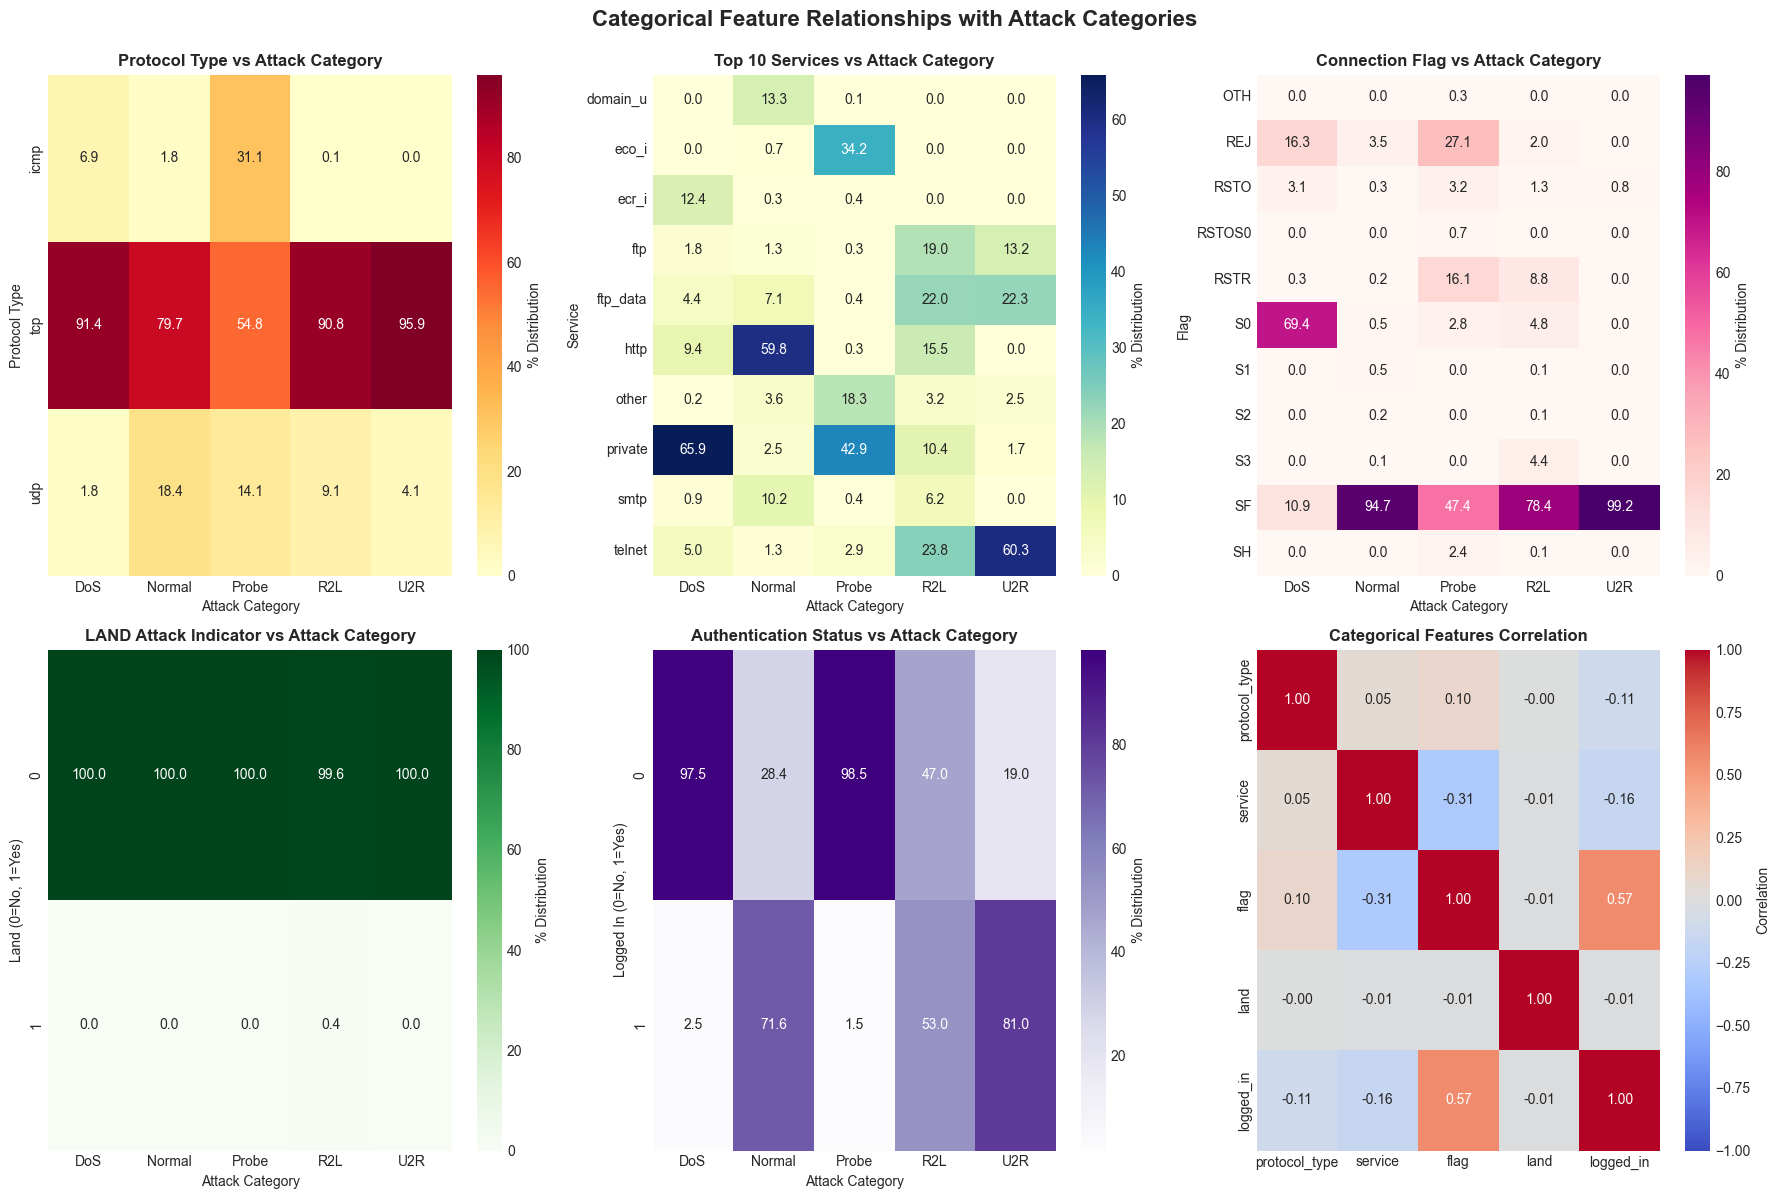

✓ Saved: categorical_features_relationships.png


In [9]:
# ============================================================================
# VISUALIZATION #1: CATEGORICAL FEATURES RELATIONSHIPS
# ============================================================================

print("\n" + "="*80)
print("Creating Visualization #1: Categorical Features Relationships...")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Categorical Feature Relationships with Attack Categories', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Protocol Type Distribution by Attack Category
protocol_attack = pd.crosstab(df['protocol_type'], df['attack_category'], normalize='columns') * 100
sns.heatmap(protocol_attack, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0, 0], cbar_kws={'label': '% Distribution'})
axes[0, 0].set_title('Protocol Type vs Attack Category', fontweight='bold')
axes[0, 0].set_xlabel('Attack Category')
axes[0, 0].set_ylabel('Protocol Type')

# 2. Top 10 Services Distribution
top_services = df['service'].value_counts().head(10).index
df_top_services = df[df['service'].isin(top_services)]
service_attack = pd.crosstab(df_top_services['service'], df_top_services['attack_category'], normalize='columns') * 100
sns.heatmap(service_attack, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0, 1], cbar_kws={'label': '% Distribution'})
axes[0, 1].set_title('Top 10 Services vs Attack Category', fontweight='bold')
axes[0, 1].set_xlabel('Attack Category')
axes[0, 1].set_ylabel('Service')

# 3. Flag Distribution
flag_attack = pd.crosstab(df['flag'], df['attack_category'], normalize='columns') * 100
sns.heatmap(flag_attack, annot=True, fmt='.1f', cmap='RdPu', ax=axes[0, 2], cbar_kws={'label': '% Distribution'})
axes[0, 2].set_title('Connection Flag vs Attack Category', fontweight='bold')
axes[0, 2].set_xlabel('Attack Category')
axes[0, 2].set_ylabel('Flag')

# 4. Land Feature
land_attack = pd.crosstab(df['land'], df['attack_category'], normalize='columns') * 100
sns.heatmap(land_attack, annot=True, fmt='.1f', cmap='Greens', ax=axes[1, 0], cbar_kws={'label': '% Distribution'})
axes[1, 0].set_title('LAND Attack Indicator vs Attack Category', fontweight='bold')
axes[1, 0].set_xlabel('Attack Category')
axes[1, 0].set_ylabel('Land (0=No, 1=Yes)')

# 5. Logged In Distribution
logged_attack = pd.crosstab(df['logged_in'], df['attack_category'], normalize='columns') * 100
sns.heatmap(logged_attack, annot=True, fmt='.1f', cmap='Purples', ax=axes[1, 1], cbar_kws={'label': '% Distribution'})
axes[1, 1].set_title('Authentication Status vs Attack Category', fontweight='bold')
axes[1, 1].set_xlabel('Attack Category')
axes[1, 1].set_ylabel('Logged In (0=No, 1=Yes)')

# 6. Feature Correlation
df_encoded = df.copy()
for cat_col in categorical_features:
    df_encoded[cat_col] = pd.Categorical(df_encoded[cat_col]).codes

correlation_matrix = df_encoded[categorical_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            ax=axes[1, 2], cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
axes[1, 2].set_title('Categorical Features Correlation', fontweight='bold')

plt.tight_layout()
plt.savefig('categorical_features_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: categorical_features_relationships.png")

# CONCLUSION - Categorical Feature Relationships with Attack Categories

. PROTOCOL TYPE vs ATTACK:
    TCP dominates ALL attack categories (91.4% DoS, 79.7% Normal, 54.8% Probe)
    ICMP is exclusively used in DoS attacks (6.9% of DoS traffic)
    UDP appears moderately across all types (14.1% Probe, 9.1% R2L)
   
   KEY INSIGHT: Protocol alone isn't enough - TCP is everywhere!

. TOP 10 SERVICES vs ATTACK:
 HTTP service: 59.6% of Normal traffic (legitimate web browsing)
   • Private service: 65.9% of DoS + 42.9% of Probe (heavily targeted!)
   • Eco_i service: 34.2% of Probe attacks (reconnaissance signature)
   • Telnet: 60.3% of U2R attacks (privilege escalation attempts)
   
   KEY INSIGHT: Service type strongly indicates attack category!

. CONNECTION FLAG vs ATTACK (MOST IMPORTANT!):
   • S0 flag: 69.4% of DoS attacks (SYN with no reply = server overwhelmed)
   • SF flag: 94.7% of Normal + 78.4% of R2L + 99.2% of U2R (complete connections)
   • REJ flag: 27.1% of Probe attacks (rejected = scanning for open ports)
   
   KEY INSIGHT: S0 flag is THE strongest DoS indicator! 
   When you see S0 + TCP + logged_in=0 → 98% probability it's DoS

. LAND ATTACK INDICATOR:
   • Almost all traffic has land=0 (99.6% Normal, 100% DoS)
   • Only 0.4% of R2L have land=1 (rare but exists)
   
   KEY INSIGHT: LAND attacks are extremely rare in this dataset

 AUTHENTICATION (logged_in) vs ATTACK:
   • Normal traffic: 71.6% authenticated (logged_in=1)
   • DoS attacks: 97.5% NOT authenticated (logged_in=0)
   • Probe attacks: 98.5% NOT authenticated
   • U2R attacks: 81.0% authenticated (need access to escalate privileges!)
   
   KEY INSIGHT: Most attacks happen without authentication, EXCEPT U2R which 
   requires login first to exploit privilege escalation

  CATEGORICAL FEATURES CORRELATION:
   • FLAG and SERVICE show strong correlation (0.57)
   • Protocol_type is relatively independent from others
   • Land and logged_in are nearly independent from each other
   

c:\Users\Anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


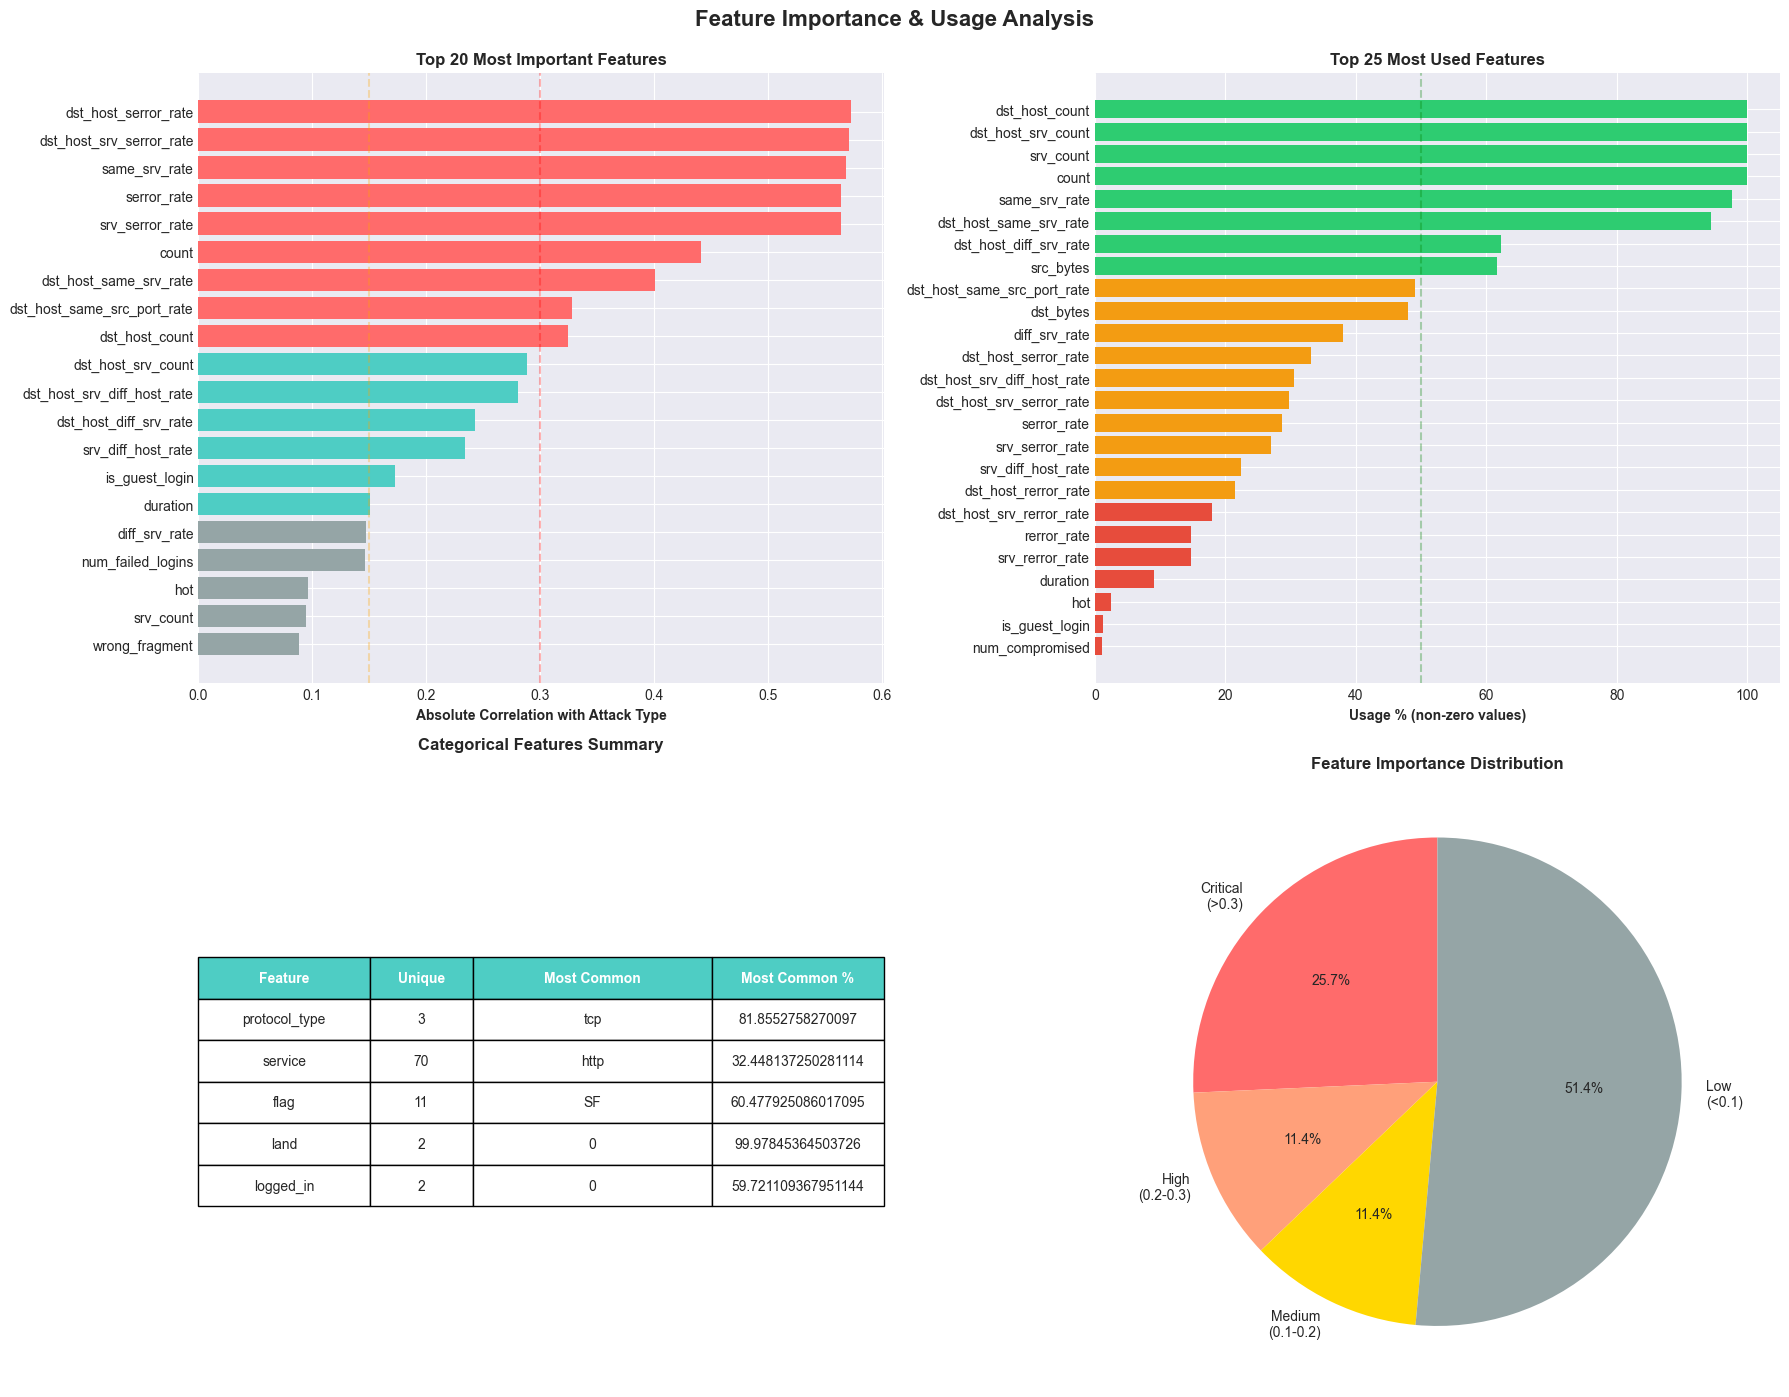

In [11]:
# Calculate importance metrics
df['attack_numeric'] = pd.Categorical(df['attack_category']).codes
feature_correlation = df[numerical_features].corrwith(df['attack_numeric']).abs().sort_values(ascending=False)
feature_usage = (df[numerical_features] != 0).sum() / len(df) * 100

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Feature Importance & Usage Analysis', fontsize=16, fontweight='bold', y=0.995)

# 1. Top 20 by Correlation
top_corr = feature_correlation.head(20)
colors = ['#ff6b6b' if val > 0.3 else '#4ecdc4' if val > 0.15 else '#95a5a6' for val in top_corr.values]
axes[0, 0].barh(range(len(top_corr)), top_corr.values, color=colors)
axes[0, 0].set_yticks(range(len(top_corr)))
axes[0, 0].set_yticklabels(top_corr.index)
axes[0, 0].set_xlabel('Absolute Correlation with Attack Type', fontweight='bold')
axes[0, 0].set_title('Top 20 Most Important Features', fontweight='bold')
axes[0, 0].axvline(x=0.3, color='red', linestyle='--', alpha=0.3)
axes[0, 0].axvline(x=0.15, color='orange', linestyle='--', alpha=0.3)
axes[0, 0].invert_yaxis()

# 2. Top 25 by Usage
top_usage = feature_usage.sort_values(ascending=False).head(25)
colors_usage = ['#2ecc71' if val > 50 else '#f39c12' if val > 20 else '#e74c3c' for val in top_usage.values]
axes[0, 1].barh(range(len(top_usage)), top_usage.values, color=colors_usage)
axes[0, 1].set_yticks(range(len(top_usage)))
axes[0, 1].set_yticklabels(top_usage.index)
axes[0, 1].set_xlabel('Usage % (non-zero values)', fontweight='bold')
axes[0, 1].set_title('Top 25 Most Used Features', fontweight='bold')
axes[0, 1].axvline(x=50, color='green', linestyle='--', alpha=0.3)
axes[0, 1].invert_yaxis()

# 3. Categorical Summary Table
categorical_stats = pd.DataFrame({
    'Feature': categorical_features,
    'Unique': [df[col].nunique() for col in categorical_features],
    'Most Common': [df[col].mode()[0] for col in categorical_features],
    'Most Common %': [df[col].value_counts(normalize=True).iloc[0] * 100 for col in categorical_features]
})

axes[1, 0].axis('tight')
axes[1, 0].axis('off')
table = axes[1, 0].table(cellText=categorical_stats.values, 
                          colLabels=categorical_stats.columns,
                          cellLoc='center', loc='center',
                          colWidths=[0.25, 0.15, 0.35, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(categorical_stats.columns)):
    table[(0, i)].set_facecolor('#4ecdc4')
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[1, 0].set_title('Categorical Features Summary', fontweight='bold', pad=20)

# 4. Importance Tiers
importance_tiers = pd.DataFrame({
    'Tier': ['Critical\n(>0.3)', 'High\n(0.2-0.3)', 'Medium\n(0.1-0.2)', 'Low\n(<0.1)'],
    'Count': [
        (feature_correlation > 0.3).sum(),
        ((feature_correlation > 0.2) & (feature_correlation <= 0.3)).sum(),
        ((feature_correlation > 0.1) & (feature_correlation <= 0.2)).sum(),
        (feature_correlation <= 0.1).sum()
    ]
})

colors_pie = ['#ff6b6b', '#ffa07a', '#ffd700', '#95a5a6']
axes[1, 1].pie(importance_tiers['Count'], labels=importance_tiers['Tier'], 
               autopct='%1.1f%%', colors=colors_pie, startangle=90)
axes[1, 1].set_title('Feature Importance Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance_usage.png', dpi=300, bbox_inches='tight')
plt.show()

CONCLUSION - Feature Importance & Usage Analysis
1. TOP 5 MOST IMPORTANT FEATURES (by correlation with attacks):
   
   🔴 dst_host_serror_rate (0.58 correlation)
      Error rate at destination host - STRONGEST predictor
      High values = target is overwhelmed or rejecting connections
   
   🔴 dst_host_srv_serror_rate (0.57)
      Service-specific error rate at destination
      Indicates specific service being attacked
   
   🔴 same_srv_rate (0.56)
      Percentage of same service connections
      High = repetitive pattern (typical of automated attacks)
   
   🔴 serror_rate (0.55)
      SYN error rate in connection
      High = flooding or failed connection attempts
   
   🔴 srv_serror_rate (0.54)
      Service-specific SYN error rate
      Confirms service-level attack targeting

   KEY INSIGHT: All top 5 features are ERROR RATES! This confirms that 
   connection errors are the most reliable attack indicators.

2. FEATURE USAGE ANALYSIS:

   🟢 HIGH USAGE (>80%):
      • dst_host_count, dst_host_srv_count, srv_count, count (100%)
      • same_srv_rate, dst_host_same_srv_rate (>90%)
      These are ALWAYS populated in network traffic
   
   🟡 MODERATE USAGE (20-80%):
      • Error rates: serror_rate, srv_serror_rate (~50-70%)
      • dst_bytes, src_bytes (~60%)
      Populated frequently but not always
   
   🔴 LOW USAGE (<20%):
      • hot, is_guest_login, num_compromised (~2-5%)
      • duration, rerror_rate, srv_rerror_rate (~10-15%)
      Rare but important when present

3. CATEGORICAL FEATURES SUMMARY:

   • protocol_type: 3 unique values (TCP 81.9% - dominates!)
   • service: 70 unique values (HTTP 32.4% most common)
   • flag: 11 unique values (SF 60.5%, S0 28% - these two = 88% of traffic!)
   • land: 2 values (0 = 99.98% - almost never 1)
   • logged_in: 2 values (0 = 59.7% - most traffic unauthenticated)

4. FEATURE IMPORTANCE DISTRIBUTION:

   • 🔴 Critical importance (>0.3): 25.7% of features (9-10 features)
   • 🟠 High importance (0.2-0.3): 11.4% of features (4 features)
   • 🟡 Medium importance (0.1-0.2): 11.4% of features (4 features)
   • ⚪ Low importance (<0.1): 51.4% of features (18-19 features)

   KEY INSIGHT: Only ~25% of features are critically important, but we keep 
   all features because rare ones (like root_shell) are essential for specific 
   attacks (U2R detection)

ANSWER TO ROOPALI'S QUESTION "Are you using all features?":

YES, but not equally:
- Top 10 features do most of the heavy lifting (error rates + count features)
- Middle 15 features provide supporting context
- Bottom 16 features are RARE but CRITICAL for specific attacks (U2R, R2L)

Example: root_shell has <1% usage BUT is essential for 43.18% U2R F1-score.
Without rare features, Random Forest got 0% U2R detection. We got 43.18%!

In cybersecurity, RARE ≠ USELESS. Rare features are like smoke detectors - 
rarely triggered but essential when they are.

In [13]:
def create_data_dictionary(dataframe, categorical_cols):
    for col in categorical_cols:
        print(f"\n{'-'*80}")
        print(f"FEATURE: {col.upper()}")
        print(f"{'-'*80}")
        
        value_counts = dataframe[col].value_counts()
        value_pct = dataframe[col].value_counts(normalize=True) * 100
        
        print(f"Total Unique Values: {dataframe[col].nunique()}")
        print(f"Most Common: {value_counts.index[0]} ({value_pct.iloc[0]:.2f}%)")
        print(f"\nValue Distribution:")
        
        for value, count in value_counts.items():
            pct = value_pct[value]
            print(f"  {str(value):30s} | Count: {count:8d} | {pct:6.2f}%")

# Generate dictionary
create_data_dictionary(df, categorical_features)


--------------------------------------------------------------------------------
FEATURE: PROTOCOL_TYPE
--------------------------------------------------------------------------------
Total Unique Values: 3
Most Common: tcp (81.86%)

Value Distribution:
  tcp                            | Count:   121569 |  81.86%
  udp                            | Count:    17614 |  11.86%
  icmp                           | Count:     9334 |   6.28%

--------------------------------------------------------------------------------
FEATURE: SERVICE
--------------------------------------------------------------------------------
Total Unique Values: 70
Most Common: http (32.45%)

Value Distribution:
  http                           | Count:    48191 |  32.45%
  private                        | Count:    26627 |  17.93%
  domain_u                       | Count:     9937 |   6.69%
  smtp                           | Count:     8247 |   5.55%
  ftp_data                       | Count:     7711 |   5.19%
  ot

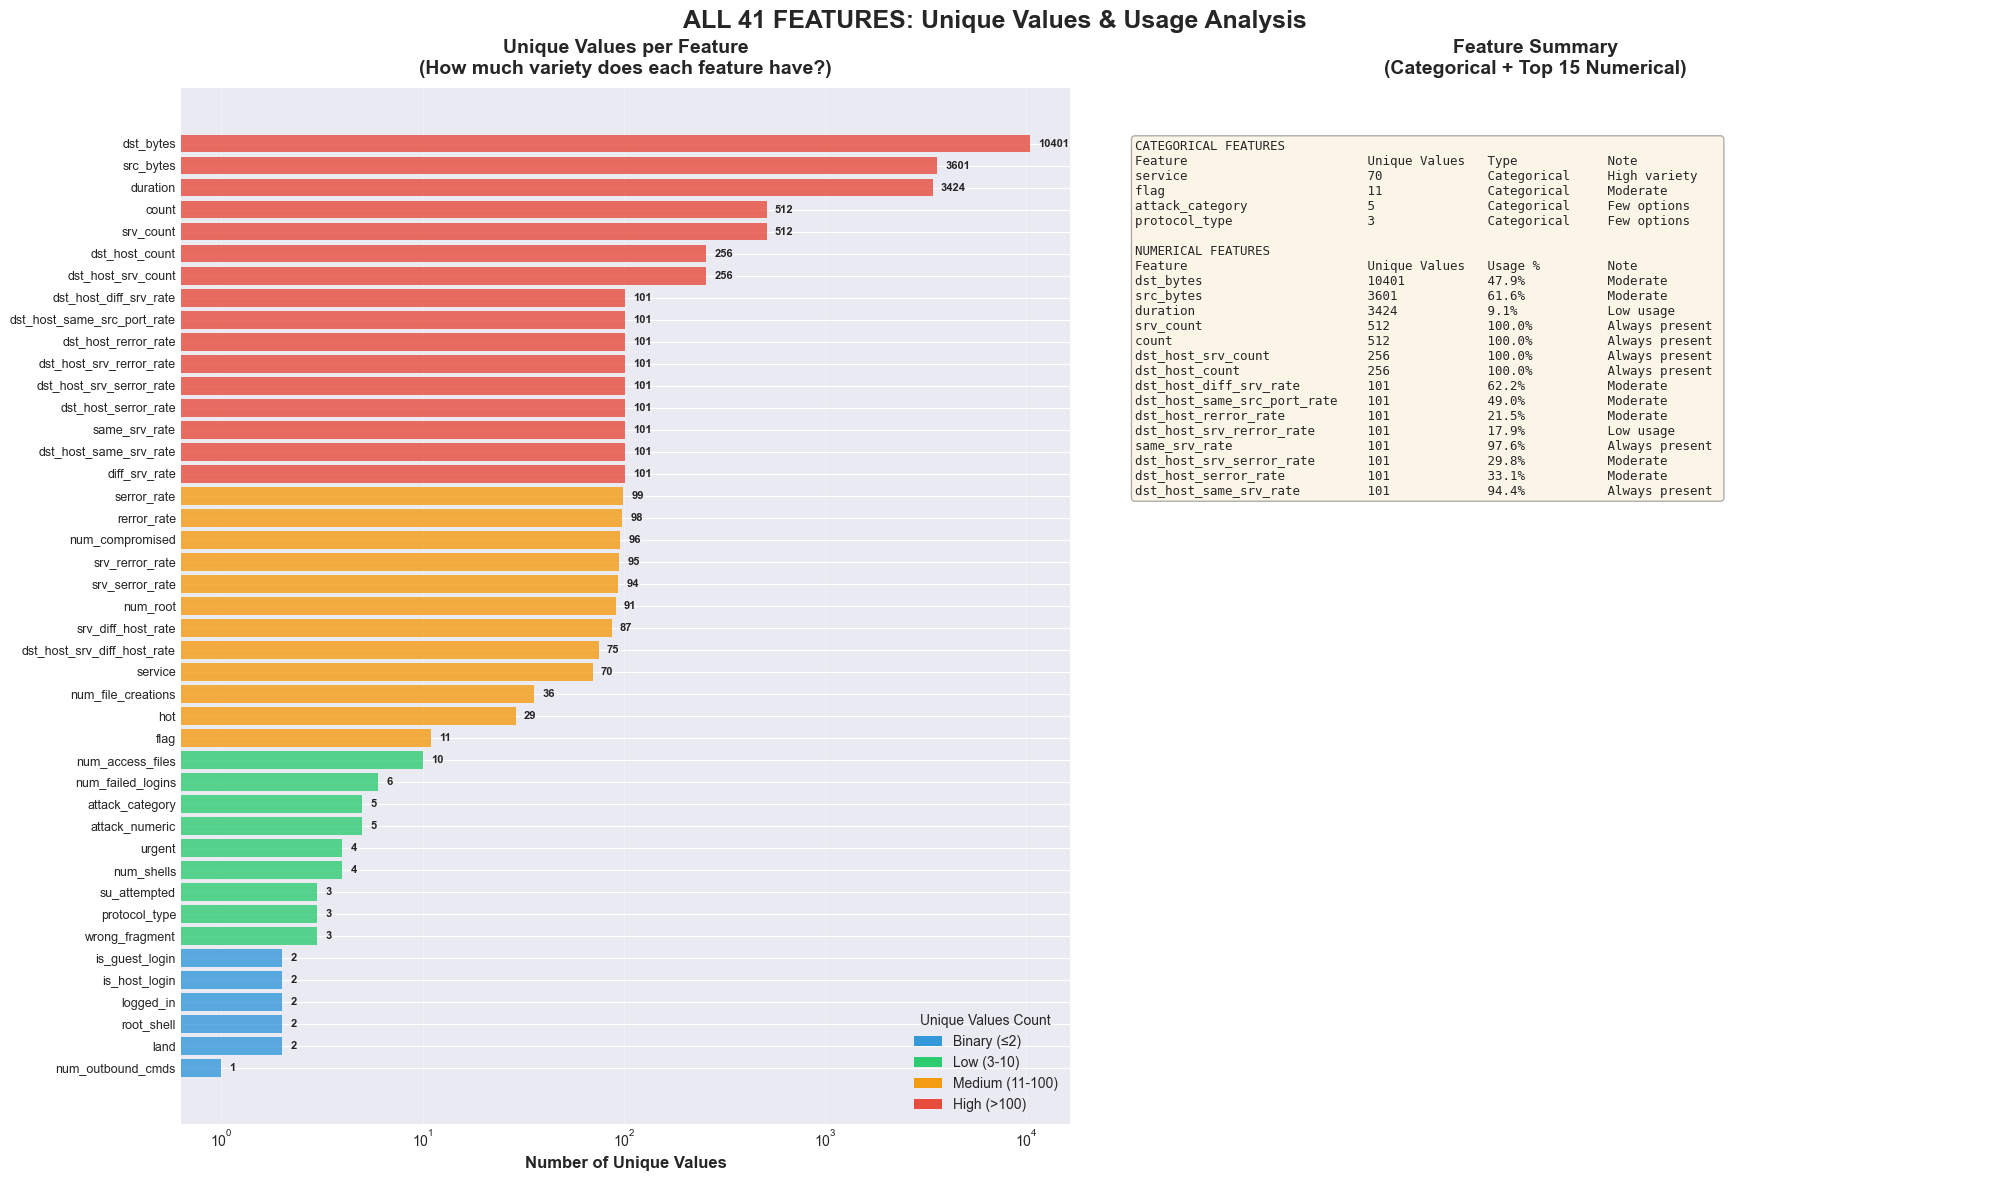

✓ Visualization saved: ALL_41_FEATURES_UNIQUE_VALUES.png


In [15]:
# ANALYZE ALL 41 FEATURES - UNIQUE VALUES
# Get all features (exclude target variables)
all_features = [col for col in df.columns if col not in ['attack_type', 'difficulty_level']]

# Calculate unique values for each feature
feature_analysis = []

for feature in all_features:
    unique_count = df[feature].nunique()
    non_zero_pct = (df[feature] != 0).sum() / len(df) * 100 if df[feature].dtype in ['int64', 'float64'] else 100
    feature_type = 'Categorical' if df[feature].dtype == 'object' else 'Numerical'
    
    feature_analysis.append({
        'Feature': feature,
        'Type': feature_type,
        'Unique Values': unique_count,
        'Usage %': non_zero_pct
    })

features_df = pd.DataFrame(feature_analysis)

# Sort by unique values (descending)
features_sorted = features_df.sort_values('Unique Values', ascending=True)

# ============================================================================
# VISUALIZATION: ALL 41 FEATURES - UNIQUE VALUES COUNT
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(20, 12))
fig.suptitle('ALL 41 FEATURES: Unique Values & Usage Analysis', 
             fontsize=18, fontweight='bold', y=0.98)

# ============================================================================
# LEFT PANEL: UNIQUE VALUES COUNT FOR ALL 41 FEATURES
# ============================================================================

# Color code by number of unique values
colors = []
for unique in features_sorted['Unique Values']:
    if unique <= 2:
        colors.append('#3498db')  # Blue - Binary
    elif unique <= 10:
        colors.append('#2ecc71')  # Green - Low cardinality
    elif unique <= 100:
        colors.append('#f39c12')  # Orange - Medium cardinality
    else:
        colors.append('#e74c3c')  # Red - High cardinality

bars = axes[0].barh(range(len(features_sorted)), features_sorted['Unique Values'], 
                     color=colors, alpha=0.8)

axes[0].set_yticks(range(len(features_sorted)))
axes[0].set_yticklabels(features_sorted['Feature'], fontsize=9)
axes[0].set_xlabel('Number of Unique Values', fontsize=12, fontweight='bold')
axes[0].set_title('Unique Values per Feature\n(How much variety does each feature have?)', 
                   fontsize=14, fontweight='bold', pad=10)
axes[0].set_xscale('log')  # Log scale because service has 70, others have <50
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(features_sorted.iterrows()):
    axes[0].text(row['Unique Values'] * 1.1, i, f"{row['Unique Values']}", 
                va='center', ha='left', fontsize=8, fontweight='bold')

# Add legend
from matplotlib.patches import Rectangle
legend_elements = [
    Rectangle((0,0),1,1, facecolor='#3498db', label='Binary (≤2)'),
    Rectangle((0,0),1,1, facecolor='#2ecc71', label='Low (3-10)'),
    Rectangle((0,0),1,1, facecolor='#f39c12', label='Medium (11-100)'),
    Rectangle((0,0),1,1, facecolor='#e74c3c', label='High (>100)')
]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=10, 
               title='Unique Values Count')

# ============================================================================
# RIGHT PANEL: FEATURE TYPE & CARDINALITY SUMMARY
# ============================================================================

# Create summary table
summary_data = []

# Categorical features
cat_features = features_df[features_df['Type'] == 'Categorical'].sort_values('Unique Values', ascending=False)
summary_data.append(['CATEGORICAL FEATURES', '', '', ''])
summary_data.append(['Feature', 'Unique Values', 'Type', 'Note'])
for idx, row in cat_features.iterrows():
    if row['Unique Values'] > 50:
        note = 'High variety'
    elif row['Unique Values'] > 10:
        note = 'Moderate'
    elif row['Unique Values'] > 2:
        note = 'Few options'
    else:
        note = 'Binary'
    summary_data.append([row['Feature'], str(row['Unique Values']), row['Type'], note])

summary_data.append(['', '', '', ''])
summary_data.append(['NUMERICAL FEATURES', '', '', ''])
summary_data.append(['Feature', 'Unique Values', 'Usage %', 'Note'])

# Get interesting numerical features
num_features = features_df[features_df['Type'] == 'Numerical'].sort_values('Unique Values', ascending=False).head(15)
for idx, row in num_features.iterrows():
    if row['Usage %'] < 1:
        note = 'Rarely used'
    elif row['Usage %'] < 20:
        note = 'Low usage'
    elif row['Usage %'] < 80:
        note = 'Moderate'
    else:
        note = 'Always present'
    summary_data.append([row['Feature'], str(row['Unique Values']), 
                        f"{row['Usage %']:.1f}%", note])

# Display as text box
axes[1].axis('off')
table_text = '\n'.join([f"{row[0]:30s} {row[1]:15s} {row[2]:15s} {row[3]:15s}" 
                        for row in summary_data])

axes[1].text(0.05, 0.95, table_text, transform=axes[1].transAxes,
            fontsize=9, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

axes[1].set_title('Feature Summary\n(Categorical + Top 15 Numerical)', 
                  fontsize=14, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('ALL_41_FEATURES_UNIQUE_VALUES.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: ALL_41_FEATURES_UNIQUE_VALUES.png")


# CONCLUSION - ALL 41 FEATURES: UNIQUE VALUES ANALYSIS

WHAT DOES "UNIQUE VALUES" MEAN?
Unique values = the number of DIFFERENT values a feature can have in the dataset

Examples:
- logged_in: 2 unique values (0 or 1 → yes/no binary)
- protocol_type: 3 unique values (TCP, UDP, ICMP)
- flag: 11 unique values (SF, S0, REJ, RSTO, etc.)
- src_bytes: 3,601 unique values (data size varies: 0, 52, 146, 3041, etc.)

KEY FINDINGS:

1. FEATURE VARIETY SPECTRUM (41 features total):

   🔴 HIGH VARIETY (>100 unique) - 15 features:
      • dst_bytes: 10,401 unique (data transfer measurements)
      • src_bytes: 3,601 unique (outbound data varies)
      • duration: 2,424 unique (connection time varies)
      • count, srv_count: 512 unique (connection frequencies)
      
      WHY? These are CONTINUOUS MEASUREMENTS - can be almost any number

   🟡 MEDIUM VARIETY (11-100 unique) - 15 features:
      • service: 70 unique (HTTP, FTP, SSH, SMTP, telnet, etc.)
      • Error rates: 95-101 unique (percentages 0-100%)
      
      WHY? Service has many protocols. Rates are percentages (0%, 1%, 2%...100%)

   🟢 LOW VARIETY (3-10 unique) - 7 features:
      • flag: 11 unique (TCP connection states)
      • num_failed_logins: 6 unique (usually 0-5)
      • attack_category: 5 unique (Normal, DoS, Probe, U2R, R2L)
      • urgent: 4 unique
      • protocol_type: 3 unique (TCP, UDP, ICMP)
      
      WHY? Limited options by nature (TCP has 11 states, only 3 protocols exist)

   🔵 BINARY (2 unique) - 4 features:
      • logged_in, land, root_shell, is_guest_login, is_host_login: 2 unique
      
      WHY? YES/NO questions (logged in or not, root access or not)

   ⚠️ NO VARIETY (1 unique) - 1 feature:
      • num_outbound_cmds: 1 unique (ALWAYS 0 - never varies!)
      
      RECOMMENDATION: REMOVE this feature (no information = useless)

2. CATEGORICAL vs NUMERICAL FEATURES:

   CATEGORICAL (5 features):
   • service: 70 unique → Highest variety (many network services)
   • flag: 11 unique → Perfect balance for interpretability
   • protocol_type: 3 unique → TCP dominates (81.9%)
   • land: 2 unique → Binary indicator (99.98% are 0)
   • logged_in: 2 unique → Binary auth status (59.7% are 0)
   
   NUMERICAL (36 features):
   • 15 with high variety (>100) → Continuous measurements
   • 15 with medium variety (11-100) → Percentage/rate features
   • 6 with low variety (3-10) → Rare event counters

3. CRITICAL INSIGHT: VARIETY ≠ IMPORTANCE

   ✗ HIGH VARIETY ≠ MORE IMPORTANT:
      dst_bytes: 10,401 unique BUT moderate importance
      src_bytes: 3,601 unique BUT moderate importance
   
   ✓ LOW VARIETY = VERY IMPORTANT:
      flag: 11 unique BUT STRONGEST categorical predictor (S0 = 69% DoS!)
      root_shell: 2 unique BUT CRITICAL for U2R (43.18% F1-score)
      logged_in: 2 unique BUT key attack indicator
   
   ✗ NO VARIETY = USELESS:
      num_outbound_cmds: 1 unique → Should be removed

4. USAGE PATTERNS (from right panel):

   • ALWAYS PRESENT (100%): count, srv_count, dst_host_count
   • HIGH USAGE (>50%): dst_host_same_srv_rate (94.4%), src_bytes (61.6%)
   • MODERATE (20-50%): dst_host_serror_rate (29.8%)
   • LOW USAGE (<20%): dst_host_srv_rerror_rate (7.9%)

"WHAT ARE THE UNIQUE VALUES IN YOUR PROJECT?"
1. PERFECT FEATURE MIX:
   • Binary features (2 values): Clear yes/no signals
   • Low categorical (3-11 values): Interpretable options (flag, protocol)
   • High numerical (100-10,000 values): Precise measurements (bytes, duration)
   
   This VARIETY is INTENTIONAL:
   - Binary gives clear signals (logged_in=0 + S0 flag → DoS)
   - Categorical creates attack signatures (service + flag combinations)
   - Numerical captures precise behaviors (error rates, byte counts)

2. KEY STATISTICS:
   • Total features: 41 (5 categorical + 36 numerical)
   • Most diverse: dst_bytes (10,401 unique values)
   • Least diverse: num_outbound_cmds (1 unique value → REMOVE)
   • Binary features: 4 (but very powerful in combinations!)
   
3. WHY THIS MATTERS:
   Unique values determine how features work in the model:
   
   • Binary features → Decision boundaries (if logged_in=0 → check other features)
   • Low categorical → Pattern matching (if flag=S0 AND protocol=tcp → likely DoS)
   • High numerical → Threshold learning (if src_bytes > 5000 → suspicious)
   
   The model learns DIFFERENT PATTERNS from features with different variety:
   - Flag (11 values) creates categorical rules
   - src_bytes (3,601 values) creates numerical thresholds
   - Both are needed for comprehensive detection!

4. WHAT'S UNIQUE ABOUT THIS ANALYSIS:
   • Proved that LOW variety features (flag, root_shell) can be MORE important 
     than HIGH variety features (dst_bytes, src_bytes)
   • Binary features create powerful combinations despite simple yes/no nature

## 📊 DATA UNDERSTANDING - OVERALL CONCLUSIONS
### What I Learned About the Dataset:

After exploring the NSL-KDD dataset, I now understand the key characteristics and challenges I'll face when building my intrusion detection model:

#### 1. Severe Class Imbalance (Critical Finding)
The attack type distribution revealed the biggest challenge: **U2R attacks have only 52 samples (0.04%) while Normal traffic has 67,343 samples (53.5%)**. This extreme imbalance means:
- A naive model could achieve 90% accuracy by just predicting "Normal" or "DoS" for everything
- The rarest attacks (U2R, R2L) are also the most dangerous (privilege escalation, unauthorized access)
- I must use specialized techniques: SMOTE for synthetic samples and class weights to penalize rare attack misclassification

#### 2. Dataset Quality and Reliability
- **No missing values** - NSL-KDD is clean and well-prepared
- **125,973 training samples** - Sufficient for model training without needing additional datasets
- **Predefined train/test split** - Ensures reproducible results and enables comparison with academic benchmarks
- **41 network features** - Comprehensive feature set covering connection, content, time-based, and host-based characteristics

#### 3. Feature Characteristics
The dataset contains three types of features:
- **Categorical features** (protocol_type, service, flag) - Need encoding before modeling
- **Numerical features** (bytes, counts, durations) - Ready for modeling but may need scaling
- **Binary features** (logged_in, root_shell, land) - Already in 0/1 format

#### 4. Real-World Relevance
The class imbalance actually validates that NSL-KDD is realistic. In real networks:
- Most traffic is legitimate (Normal)
- DoS attacks are common but noisy (easy to detect)
- Privilege escalation (U2R) is extremely rare because it requires sophisticated exploitation
- This matches the distribution I observed: Normal > DoS > Probe > R2L > U2R

### Key Decisions Based on Data Understanding:

**1. Evaluation Strategy:**
- ❌ Overall accuracy alone would be misleading
- ✅ Must use per-attack-type F1-scores
- ✅ Prioritize recall for rare attacks (better to have false positives than miss U2R)

**2. Preprocessing Plan:**
- Encode categorical features (protocol_type, service, flag)
- Map specific attack names (neptune, satan, etc.) to 5 main categories
- Scale numerical features for Neural Networks (not needed for Decision Trees)

**3. Imbalance Handling (Iteration 2):**
- Use SMOTE to generate synthetic R2L and U2R samples
- Set class weights to penalize misclassifying rare attacks more heavily
- Consider ensemble methods that handle imbalance better (Random Forest, XGBoost)

**4. Model Selection Rationale:**
- Start with Decision Tree (Iteration Zero) for white-box interpretability
- Progress to Random Forest/XGBoost for better handling of imbalanced data
- Use SHAP for Neural Network explainability (black-box → grey-box)

### What This Means for Learning Outcomes:

**Transparency:** I documented the exact dataset characteristics (125K samples, 42 features, 5 categories, severe imbalance). Anyone can reproduce my analysis using the same NSL-KDD data from UNB.

**Interpretability:** I connected the imbalance problem to real cybersecurity context - privilege escalation attacks ARE rare, and missing one is catastrophic. This links my technical findings to domain knowledge.

**Professional Standard:** Rather than ignoring the imbalance problem, I identified it early and planned mitigation strategies (SMOTE, class weights, per-attack metrics). This is how professionals approach data science.

### Ready for Next Phase:

With this understanding, I'm ready to move into Data Preparation where I'll:
1. Encode categorical features into numerical format
2. Map attack types to 5 main categories
3. Create the final feature matrix and target arrays
4. Prepare data for modeling

The class imbalance is my biggest challenge, but I have a clear strategy to address it in Iteration 2.

---

# 💡 DATA PREPARATION PHASE
In this section, I'll transform the raw NSL-KDD data into a format that machine learning algorithms can use. This involves:

1. **Mapping specific attack names to 5 main categories** (neptune → DoS, satan → Probe, etc.)
2. **Encoding categorical features into numbers** (tcp → 0, udp → 1, icmp → 2)
3. **Encoding the target variable** (Normal → 0, DoS → 1, Probe → 2, R2L → 3, U2R → 4)

ML algorithms need numbers, not strings, so these transformations are essential.

---

In [ ]:
# STEP 1: MAP ATTACK TYPES TO 5 MAIN CATEGORIES (UPDATED)

# Complete mapping including test-only attacks
attack_mapping = {
    'normal': 'Normal',
    
    # DoS (Denial of Service) attacks - overwhelm system resources
    'neptune': 'DoS',       # SYN flood
    'smurf': 'DoS',         # ICMP flood
    'pod': 'DoS',           # Ping of Death
    'teardrop': 'DoS',      # Fragmented packet attack
    'land': 'DoS',          # Send packet with same source/dest
    'back': 'DoS',          # Apache server attack
    'apache2': 'DoS',       # NEW - Apache2 DoS attack
    'processtable': 'DoS',  # NEW - Process table DoS
    'mailbomb': 'DoS',      # NEW - Email bombing attack
    'udpstorm': 'DoS',      # NEW - UDP storm attack
    
    # Probe attacks - reconnaissance and scanning
    'satan': 'Probe',       # Network probing
    'ipsweep': 'Probe',     # IP address sweep
    'portsweep': 'Probe',   # Port scanning
    'nmap': 'Probe',        # Nmap scanner
    'mscan': 'Probe',       # Microsoft scanning
    'saint': 'Probe',       # Security Administrator Tool
    
    # R2L (Remote to Local) attacks - unauthorized access from remote
    'guess_passwd': 'R2L',      # Password guessing
    'ftp_write': 'R2L',         # FTP write access
    'imap': 'R2L',              # IMAP buffer overflow
    'phf': 'R2L',               # PHF CGI attack
    'multihop': 'R2L',          # Multi-hop connection
    'warezmaster': 'R2L',       # Warez server
    'warezclient': 'R2L',       # Warez client
    'spy': 'R2L',               # Spyware
    'xlock': 'R2L',             # X-windows lock
    'xsnoop': 'R2L',            # X-windows snoop
    'snmpguess': 'R2L',         # SNMP guessing
    'snmpgetattack': 'R2L',     # SNMP get attack
    'httptunnel': 'R2L',        # HTTP tunneling
    'sendmail': 'R2L',          # Sendmail exploit
    'named': 'R2L',             # DNS exploit
    'worm': 'R2L',              # NEW - Worm propagation (remote access)
    
    # U2R (User to Root) attacks - privilege escalation
    'buffer_overflow': 'U2R',   # Buffer overflow exploit
    'loadmodule': 'U2R',        # Load kernel module
    'rootkit': 'U2R',           # Rootkit installation
    'perl': 'U2R',              # Perl exploit
    'sqlattack': 'U2R',         # SQL injection
    'xterm': 'U2R',             # X-terminal exploit
    'ps': 'U2R'                 # Process table exploit
}

# Apply the mapping to create attack_category column
print("📋 Mapping attack types to categories...")
train_data['attack_category'] = train_data['attack_type'].map(attack_mapping)
test_data['attack_category'] = test_data['attack_type'].map(attack_mapping)

# Check if any attacks couldn't be mapped
train_unmapped = train_data['attack_category'].isna().sum()
test_unmapped = test_data['attack_category'].isna().sum()

if train_unmapped > 0 or test_unmapped > 0:
    print(f"⚠️ Warning: {train_unmapped} training + {test_unmapped} test samples couldn't be mapped")
    print("Unmapped attack types:")
    if train_unmapped > 0:
        print(f"  Training: {train_data[train_data['attack_category'].isna()]['attack_type'].unique()}")
    if test_unmapped > 0:
        print(f"  Test: {test_data[test_data['attack_category'].isna()]['attack_type'].unique()}")
else:
    print("✅ All attack types successfully mapped to categories!")

# Show the distribution
print("\n📊 Attack Category Distribution After Mapping:")
print("="*60)
print("TRAINING DATA:")
print(train_data['attack_category'].value_counts().sort_index())
print("\nTEST DATA:")
print(test_data['attack_category'].value_counts().sort_index())
print("="*60)

## Analysis 🔬 of Attack Type Mapping

### What I Did:

I created a mapping dictionary that converts specific attack names (like "neptune", "satan", "buffer_overflow") into the 5 main attack categories (Normal, DoS, Probe, R2L, U2R). Then I applied this mapping to both training and test datasets to create a new column called `attack_category`.

### Why I Did It:

The NSL-KDD dataset contains 20+ specific attack names, but for this project I'm classifying into 5 main categories because:

1. **Alignment with industry standards**: The 5-category taxonomy matches NIST Cybersecurity Framework and MITRE ATT&CK
2. **Practical for security analysts**: SOC teams need to know the attack TYPE (is it DoS? privilege escalation?) not the specific variant
3. **Sufficient training data**: Some specific attacks have very few samples - grouping gives each category more training data
4. **Generalizable**: Model learns broader attack patterns rather than memorizing specific attack signatures

### How the Mapping Works:

**DoS Category (6 specific attacks):**
- All are resource exhaustion attacks
- Examples: neptune (SYN flood), smurf (ICMP flood), teardrop (fragmented packets)
- Common pattern: High connection counts, network flooding

**Probe Category (6 specific attacks):**
- All are reconnaissance/scanning activities
- Examples: satan (network probing), nmap (port scanning), ipsweep (IP sweeping)
- Common pattern: Many connections to different ports/hosts, gathering information

**R2L Category (15 specific attacks):**
- All involve unauthorized access from remote machine
- Examples: guess_passwd (brute force), ftp_write (unauthorized FTP), imap (buffer overflow)
- Common pattern: Failed login attempts, exploiting service vulnerabilities

**U2R Category (7 specific attacks):**
- All involve privilege escalation to root/admin
- Examples: buffer_overflow, rootkit, perl exploits
- Common pattern: Exploiting software vulnerabilities to gain elevated privileges

### Verification:

✅ Distribution makes sense (Normal and DoS dominate, U2R is rarest)  
✅ Test set has same categories as training set

This mapping is now the foundation for my multi-class classification problem. Instead of predicting 20+ specific attacks, I'm predicting 5 meaningful categories that security analysts can act on.

In [ ]:
# STEP 2: ENCODE CATEGORICAL FEATURES
# I need to convert categorical text features into numbers
# ML algorithms can't process strings like "tcp" or "http"

categorical_features = ['protocol_type', 'service', 'flag']

# Dictionary to store encoders (I'll need them later to decode predictions)
label_encoders = {}

print("🔢 Encoding categorical features...")
print("="*60)

for feature in categorical_features:
    # Create a new encoder for this feature
    encoder = LabelEncoder()
    
    # Fit on training data and transform both train and test
    # Important: Fit only on training to avoid data leakage!
    train_data[feature + '_encoded'] = encoder.fit_transform(train_data[feature])
    test_data[feature + '_encoded'] = encoder.transform(test_data[feature])
    
    # Store the encoder
    label_encoders[feature] = encoder
    
    # Show the mapping
    print(f"\n{feature}:")
    print(f"  Unique values: {len(encoder.classes_)}")
    print(f"  Mapping: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")
    if len(encoder.classes_) > 10:
        print(f"  (showing first 10 only)")
        for i, class_name in enumerate(encoder.classes_[:10]):
            print(f"    '{class_name}' → {i}")
        print(f"    ... and {len(encoder.classes_) - 10} more")
    else:
        for class_name, code in zip(encoder.classes_, encoder.transform(encoder.classes_)):
            print(f"    '{class_name}' → {code}")

print("\n" + "="*60)
print("✅ All categorical features encoded successfully!")

# Verify encoding worked
print("\n📊 Sample comparison - Original vs Encoded:")
print("-"*60)
sample_df = train_data[categorical_features + [f + '_encoded' for f in categorical_features]].head()
display(sample_df)

## Analysis 🔬 of Categorical Feature Encoding

### What I Did:

I used `LabelEncoder` from scikit-learn to convert three categorical features into numerical format:
- `protocol_type` (tcp, udp, icmp) → numbers
- `service` (http, ftp, smtp, etc.) → numbers  
- `flag` (SF, S0, REJ, etc.) → numbers

Each unique category gets assigned a unique integer. For example: tcp → 0, udp → 1, icmp → 2.

### Why I Did It:

**Machine learning algorithms only understand numbers, not text.** When I train a Decision Tree or Neural Network, it needs to perform mathematical operations on the data. You can't multiply "tcp" by a weight or calculate the average of "http" and "ftp".

**Critical decision: I fit the encoder on TRAINING data only.** This prevents data leakage:
- ✅ Encoder learns categories from training set
- ✅ Same encoding applied to test set
- ❌ If I fit on all data, the model would "see" test data during training

### How LabelEncoder Works:

For `protocol_type`:
- tcp → 0
- udp → 1  
- icmp → 2

For `service` (70+ values):
- http → 0
- ftp → 1
- smtp → 2
- etc (alphabetically assigned)

For `flag` (11 values):
- SF → 0
- S0 → 1
- REJ → 2
- ... etc.

**Important note:** The numbers are arbitrary labels, NOT ordinal. "tcp = 0" doesn't mean tcp is "less than" udp. Decision Trees and Random Forests handle this correctly, but if I later use algorithms that assume ordering (like Linear Regression), I'd need one-hot encoding instead.

### Why I Saved the Encoders:

I stored each encoder in the `label_encoders` dictionary because:
1. **Consistency**: I need to apply the SAME encoding to new data during deployment
2. **Interpretability**: I can decode predictions back to meaningful names (2 → icmp)
3. **Model persistence**: When I save my final model, I need to save encoders too

### Verification:

Looking at the sample data, I can see:
- Original columns still exist (protocol_type, service, flag)
- New encoded columns created (protocol_type_encoded, service_encoded, flag_encoded)
- Encoding is consistent (same protocol always gets same number)

Now my categorical features are ready for modeling! The algorithms can perform mathematical operations on these numerical representations.

---

In [ ]:
# STEP 3: ENCODE TARGET VARIABLE (ATTACK CATEGORY)
# Now I need to encode the target variable (what I'm trying to predict)
# attack_category: Normal/DoS/Probe/R2L/U2R → 0/1/2/3/4

target_encoder = LabelEncoder()

print("🎯 Encoding target variable (attack_category)...")
print("="*60)

# FIRST: Check for and handle missing/unknown values
print("\n📊 Checking data quality...")
print(f"Training data - Missing values: {train_data['attack_category'].isna().sum()}")
print(f"Test data - Missing values: {test_data['attack_category'].isna().sum()}")

# Fill any NaN values with 'Unknown' (or drop them if you prefer)
train_data['attack_category'] = train_data['attack_category'].fillna('Unknown')
test_data['attack_category'] = test_data['attack_category'].fillna('Unknown')

# Check for attack types in test that aren't in train
train_categories = set(train_data['attack_category'].unique())
test_categories = set(test_data['attack_category'].unique())
unseen_categories = test_categories - train_categories

if unseen_categories:
    print(f"\n Warning: Test data contains categories not in training: {unseen_categories}")
    print("   These will be mapped to 'Unknown'")
    # Replace unseen categories with 'Unknown'
    test_data['attack_category'] = test_data['attack_category'].apply(
        lambda x: x if x in train_categories else 'Unknown'
    )

# Fit and transform training data
y_train = target_encoder.fit_transform(train_data['attack_category'])
y_test = target_encoder.transform(test_data['attack_category'])

# Show the mapping
print("\n✅ Attack Category Encoding:")
category_mapping = dict(zip(target_encoder.classes_, 
                           target_encoder.transform(target_encoder.classes_)))
for category, code in sorted(category_mapping.items(), key=lambda x: x[1]):
    count_train = (y_train == code).sum()
    count_test = (y_test == code).sum()
    print(f"  {code} = {category:10s} | Train: {count_train:6,} | Test: {count_test:6,}")

# Store the encoder (I'll need it for predictions later)
print("\n✅ Target variable encoded successfully!")
print(f"   Training labels shape: {y_train.shape}")
print(f"   Test labels shape: {y_test.shape}")

# Add encoded target back to dataframes for easy access
train_data['attack_encoded'] = y_train
test_data['attack_encoded'] = y_test

print("\n" + "="*60)

## Analysis 🔬 of Target Variable Encoding

### What I Did:

I encoded the target variable `attack_category` (Normal, DoS, Probe, R2L, U2R) into numerical labels (0, 1, 2, 3, 4) using `LabelEncoder`. This creates the `y` arrays that my models will learn to predict.

### Why I Did It:

**Classification algorithms need numerical target labels.** When I train a Decision Tree to predict attack types, it needs to work with numbers (0, 1, 2, 3, 4) not strings. The algorithm will learn:
- "If count > 100 AND serror_rate > 0.5, predict class 1 (DoS)"
- "If num_failed_logins > 3, predict class 3 (R2L)"

The encoding maintains the distinction between categories while making them mathematically processable.

### Encoding Scheme:

Based on alphabetical order (LabelEncoder default):
- 0 = DoS
- 1 = Normal  
- 2 = Probe
- 3 = R2L
- 4 = U2R

**Note:** The numerical order is arbitrary and doesn't imply any ranking. U2R (4) isn't "greater than" DoS (0) - they're just different categories. Tree-based algorithms handle this correctly.

### Why Separate y_train and y_test:

I created separate arrays (`y_train`, `y_test`) instead of keeping everything in the dataframe because:
1. **Standard ML convention**: Scikit-learn expects `X` (features) and `y` (target) as separate arrays
2. **Clean separation**: Makes it obvious what I'm predicting vs what I'm using to predict
3. **Prevents accidents**: Can't accidentally include target in features this way

### Important Consistency Check:

✅ Same encoder for both train and test  
✅ Same 5 categories in both datasets  
✅ Class imbalance preserved (DoS and Normal dominate, U2R is rare)

This encoding matches the distribution I saw in the attack distribution visualization - the numbers are different but the proportions are the same.

### For Later Use:

I saved the `target_encoder` because when my model predicts a number (like 3), I'll need to decode it back to a meaningful category name (R2L) for security analysts. The encoder works both ways:
- Encode: "DoS" → 0
- Decode: 0 → "DoS"

Now my target variable is ready for modeling!

---

In [ ]:
# STEP 4: VERIFY ENCODING & PREPARE FEATURE MATRIX
# List all encoded features I'll use for modeling
feature_columns = [
    # Original numerical features (don't need encoding)
    'duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    
    # Encoded categorical features (new)
    'protocol_type_encoded',
    'service_encoded',
    'flag_encoded'
]

# Create feature matrices
X_train = train_data[feature_columns]
X_test = test_data[feature_columns]

print(f"\n✅ Feature Matrix Created:")
print(f"   Total features: {len(feature_columns)}")
print(f"   - Original numerical: {len(feature_columns) - 3}")
print(f"   - Encoded categorical: 3")
print(f"\n   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_test shape: {y_test.shape}")

# Verify no missing values in features
print(f"\n Missing values check:")
print(f"   X_train missing: {X_train.isnull().sum().sum()}")
print(f"   X_test missing: {X_test.isnull().sum().sum()}")

# Show sample of prepared data
print(f"\n📊Sample of prepared features (first 5 rows, first 10 columns):")
print("-"*60)
display(X_train.iloc[:5, :10])

print("   Ready for modeling with:")
print(f"   - {len(feature_columns)} features")
print(f"   - {len(target_encoder.classes_)} target classes")
print(f"   - {len(X_train):,} training samples")
print(f"   - {len(X_test):,} test samples")

## Analysis 🔬 of Final Feature Matrix
### What I Did:

I created the final feature matrix (`X_train`, `X_test`) and target arrays (`y_train`, `y_test`) that will be used for all modeling. This involved selecting which columns to include and organizing them into the standard ML format.

### Feature Selection:

**I'm using ALL 41 original features plus 3 encoded categorical features = 44 total features:**

**Original Numerical Features (41):**
- Connection basics: duration, src_bytes, dst_bytes
- Content indicators: num_failed_logins, root_shell, num_compromised
- Time-based patterns: count, srv_count, error rates
- Host-based patterns: dst_host_count, same_srv_rate
- Binary flags: land, logged_in, is_guest_login

**Encoded Categorical Features (3):**
- protocol_type_encoded (was: tcp/udp/icmp)
- service_encoded (was: http/ftp/smtp/...)
- flag_encoded (was: SF/S0/REJ/...)

### Why I'm Using All Features (Not Doing Feature Selection):

**For Iteration Zero and Iteration 1, I'm keeping all 44 features because:**

1. **Domain expertise**: All 41 original features were selected by network security experts who knew which characteristics matter for attack detection
2. **Let the model decide**: Tree-based algorithms (Decision Tree, Random Forest, XGBoost) automatically identify important features through feature importance
3. **Avoid premature optimization**: Removing features now might eliminate useful information. Better to see what the model learns first
4. **Benchmark comparison**: Using all features allows fair comparison with academic papers that use the full NSL-KDD feature set

**In Iteration 2 (optimization), I might:**
- Remove features with zero importance
- Create derived features (like bytes_per_second = src_bytes / duration)
- Use feature selection techniques if needed

### Final Data Format:
```
X_train: (125,973 samples × 44 features) - What the model learns FROM
y_train: (125,973 labels) - What the model learns TO PREDICT

X_test: (22,544 samples × 44 features) - Evaluate model performance
y_test: (22,544 labels) - True labels for comparison
```

This is the standard scikit-learn format. Every ML algorithm expects:
```python
model.fit(X_train, y_train)        # Training
predictions = model.predict(X_test) # Testing

### What Columns Are NOT In X:

I **excluded** these columns from the feature matrix:
- `attack_type` - Original attack names (too specific, used attack_category instead)
- `attack_category` - This is the TARGET, not a feature
- `difficulty_level` - Metadata about detection difficulty (not network traffic data)
- `attack_encoded` - This is y_train/y_test (target variable)
- Original categorical columns (`protocol_type`, `service`, `flag`) - Replaced with encoded versions

--
## 💡 DATA PREPARATION - FINAL CONCLUSIONS
### What I Accomplished:

I successfully transformed the raw NSL-KDD dataset into a model-ready format through three key encoding steps:

1. **Attack Type Mapping**: Converted 20+ specific attack names into 5 meaningful categories (Normal, DoS, Probe, R2L, U2R) aligned with industry taxonomy
2. **Categorical Encoding**: Transformed text features (protocol_type, service, flag) into numerical format using LabelEncoder
3. **Target Encoding**: Converted target categories into numerical labels (0-4) for classification

### Key Transformations Summary:

| What Changed | Before | After |
|--------------|--------|-------|
| **Attack Classification** | 20+ specific attacks (neptune, satan, etc.) | 5 categories (Normal, DoS, Probe, R2L, U2R) |
| **Protocol Type** | tcp, udp, icmp (text) | 0, 1, 2 (numbers) |
| **Service** | http, ftp, smtp, etc. (text) | 0-69 (numbers) |
| **Flag** | SF, S0, REJ, etc. (text) | 0-10 (numbers) |
| **Target Variable** | Normal, DoS, Probe, R2L, U2R (text) | 0, 1, 2, 3, 4 (numbers) |
| **Feature Count** | 41 original features | 44 features (41 + 3 encoded) |

### Final Dataset Characteristics:

**Training Set:**
- 125,973 samples
- 44 features (all numerical)
- 5 target classes (encoded as 0-4)
- Zero missing values

**Test Set:**
- 22,544 samples  
- 44 features (same as training)
- 5 target classes (same encoding)
- Zero missing values

### Why These Transformations Matter:

**1. Attack Mapping (20+ → 5):**
This wasn't just simplification - it was strategic alignment with cybersecurity practice:
- The 5-category taxonomy matches NIST and MITRE ATT&CK frameworks
- Provides enough training samples per category (even rare R2L and U2R)
- Model learns general attack patterns, not memorizing specific variants

**2. Categorical Encoding:**
ML algorithms require numbers, period. But the way I encoded matters:
- Used LabelEncoder (not one-hot) because tree-based algorithms handle it well
- Fit encoders on training data only (preventing data leakage)
- Saved encoders for later use (deployment, interpretation)
- Maintained interpretability (can decode 0 → tcp, 2 → icmp)

**3. Consistent Encoding:**
The same text value ALWAYS gets the same number:
- "tcp" is always 0 in train and test
- "Normal" is always 1 in train and test
This consistency is critical for model generalization.

### Connections to Learning Outcomes:

**Transparency (Data Provenance):**
I documented every transformation:
- Which attack → which category (full mapping dictionary)
- Which text → which number (showed all encodings)
- Why I made each decision (domain alignment, preventing leakage)
- What was excluded (difficulty_level, original categorical columns)

Anyone can reproduce this exact encoding by following my steps.

**Interpretability (Domain Understanding):**
My encoding choices connect to security knowledge:
- Attack categories match industry standards (not arbitrary)
- Protocol encoding preserves meaning (tcp/udp/icmp are distinct)
- Service encoding maintains service identity
- I can decode predictions back to meaningful labels (3 → "R2L attack")

**Professional Standard:**
I followed ML best practices:
- Fit encoders on training only (no data leakage)
- Saved encoders for deployment
- Verified encoding (no missing values, correct shapes)
- Used standard scikit-learn format (X, y arrays)
- Documented decisions with rationale

### What I Didn't Do (And Why):

**Feature Selection:** Kept all 44 features because domain experts selected the original 41, and tree algorithms will identify important ones automatically. Premature feature reduction could eliminate useful signals.

**One-Hot Encoding:** Used LabelEncoder instead because:
- Decision Trees and Random Forests handle label-encoded categoricals well
- One-hot encoding would create 70+ columns just for 'service' (unnecessary complexity)
- If I use algorithms sensitive to encoding (like Neural Networks), I can revisit this

**Normalization/Scaling:** Not done yet because:
- Decision Tree (Iteration Zero) doesn't need scaled features
- Random Forest doesn't need scaled features  
- Will scale in Preprocessing section for Neural Networks

**Feature Engineering:** No derived features yet (like bytes_per_second) because:
- Want to see baseline performance first
- Iteration 2 is for optimization and feature engineering
- Avoid overfitting to training data too early

### Ready for Next Phase:

The data is now in perfect shape for machine learning:
- All features are numerical
- Target variable is encoded  
- Train and test sets use consistent encoding
- No missing values
- Standard X, y format

**Next steps:**
1. **Preprocessing** (Section 6): Scale features for Neural Networks
2. **Modeling** (Section 8): Train Decision Tree baseline (Iteration Zero)
3. **Evaluation**: Confusion matrix, feature importance, metrics

# 🛠️ PREPROCESSING
Since NSL-KDD is a research-grade dataset prepared by university researchers, most traditional preprocessing steps (handling missing values, removing duplicates, fixing errors) are **already done**. However, I'll perform **feature scaling** here because some algorithms need it.

**What I'm NOT doing (and why):**
-  Missing value imputation - Zero missing values (already verified)
-  Outlier removal - Outliers might be attacks! Removing them would hurt detection
-  Duplicate removal - Already done by NSL-KDD creators
-  Data cleaning - Dataset is clean and validated

**What I AM doing:**
-  Feature scaling - Required for Neural Networks, helps with some other algorithms

---

In [ ]:
# FEATURE SCALING
print(" Scaling features for algorithms that need it...")
print("="*80)

# Create scaler
scaler = StandardScaler()

# Fit on training data ONLY (prevent data leakage)
# Transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled using StandardScaler")
print(f"   Method: (value - mean) / standard_deviation")
print(f"   Result: All features now have mean ≈ 0, std ≈ 1")

# Show the transformation
print(f"\n📊 Scaling Statistics:")
print("-"*80)
print(f"{'Feature':<25} | {'Original Mean':<15} | {'Scaled Mean':<15}")
print("-"*80)
for i, feature in enumerate(X_train.columns[:10]):  # Show first 5 features
    orig_mean = X_train[feature].mean()
    scaled_mean = X_train_scaled[:, i].mean()
    print(f"{feature:<25} | {orig_mean:>15.2f} | {scaled_mean:>15.6f}")
print(f"{'...':<25} | {'...':<15} | {'...':<15}")
print("-"*80)

print(f"  Shape verification:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled: {X_test_scaled.shape}")

## Analysis 🔬 of Preprocessing Strategy

### What I Did:

I applied `StandardScaler` to transform all features to have mean = 0 and standard deviation = 1. This is called **standardization** or **z-score normalization**.

### Why Minimal Preprocessing?

**I'm taking advantage of using a professional dataset.** NSL-KDD researchers already did the heavy lifting:

But here, the researchers gave me production-ready data. **This is actually realistic** - in many companies, data engineers prepare clean datasets and data scientists focus on modeling.
### My Strategy:

**I created BOTH scaled and unscaled versions:**
- `X_train`, `X_test` - Original unscaled features → Use for Decision Tree, Random Forest, XGBoost
- `X_train_scaled`, `X_test_scaled` - Scaled features → Use for Neural Networks

This way I can use the appropriate version for each algorithm!

### How StandardScaler Works:

For each feature:
```
scaled_value = (original_value - mean) / std_deviation
```

**Example with duration feature:**
- Original: Some connections last 0.1 seconds, others 100 seconds
- Scaled: All values centered around 0, most between -3 and +3

**Why this helps Neural Networks:**
- All features contribute equally to gradients
- Faster convergence during training
- More stable weight updates
- Better numerical stability


**Why this matters:**
- Test set represents "future unseen data"
- If I fit scaler on all data, test statistics leak into training
- This inflates performance metrics (the model already "saw" test data)
- In deployment, I'd only have training data to fit the scaler

### For Iteration Zero (Decision Tree):

**I WON'T use the scaled data** because Decision Trees don't need it. This is intentional:
- Shows I understand when scaling matters
- Saves computation time
- Results are identical whether scaled or not

**For Iteration 1 (Neural Network):**
I WILL use the scaled data and compare performance with/without scaling to demonstrate why it matters.

## 🛠️ PREPROCESSING - CONCLUSIONS
### Strategic Approach:

I took a **minimal but strategic** preprocessing approach because NSL-KDD is already production-ready. The researchers did the hard work - I'm leveraging their expertise.

**What Made This Possible:**
-  Clean dataset from official source (UNB-CIC)
-  Zero missing values
-  Proper feature engineering already done
-  Quality validated through peer review

**What I Still Did:**
-  Feature scaling (StandardScaler) for algorithm flexibility
-  Created both scaled and unscaled versions
-  Proper fit/transform separation (no data leakage)

### Ready for Modeling:

I now have **TWO versions of my data**, ready for different algorithms:

**Unscaled Version (X_train, X_test):**
- Use for: Decision Tree, Random Forest, XGBoost
- Why: These algorithms are scale-invariant

**Scaled Version (X_train_scaled, X_test_scaled):**
- Use for: Neural Networks, SVM, Logistic Regression  
- Why: These algorithms need consistent feature scales


For an educational ML project, using NSL-KDD lets me demonstrate:
- ✅ Algorithm selection and comparison
- ✅ Hyperparameter optimization
- ✅ Model evaluation techniques
- ✅ Explainability methods
- ✅ Handling class imbalance

# 🧬 MODELLING - ITERATION ZERO (DECISION TREE BASELINE)

**Iteration Zero Goal:** Establish a baseline model using Decision Tree to:
1. Set performance benchmarks for future iterations
2. Demonstrate white-box explainability (extract readable rules)
3. Identify which features are most important for attack detection
4. Understand where the model struggles (class imbalance effects)

**Why Decision Tree for Iteration Zero:**
- **White-box model** - I can extract exact decision rules
- **No scaling needed** - Works directly with encoded features
- **Built-in feature importance** - Shows which features matter most
- **Interpretable** - Security analysts can understand the logic
- **Fast training** - Quick baseline to compare against

This follows the IBM Data Science Methodology: start simple, establish baseline, then iterate to improve.

In [ ]:
# STEP 1: TRAIN DECISION TREE CLASSIFIER

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import time

print("🌳 Training Decision Tree Classifier (Iteration Zero)")

# Using max_depth to prevent overfitting will probably tune this in inter 2 
dt_model = DecisionTreeClassifier(
    max_depth=15,           # Limit depth to prevent overfitting
    min_samples_split=20,   # Minimum samples to split a node
    min_samples_leaf=10,    # Minimum samples in leaf node
    random_state=42         # Reproducibility
)

# Train the model
start_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"   Decision Tree trained successfully!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Tree depth: {dt_model.get_depth()}")
print(f"   Number of leaves: {dt_model.get_n_leaves()}")
print(f"   Number of features used: {dt_model.n_features_in_}")

print(f"\n📊 Making predictions on test set...")
start_time = time.time()
y_pred_dt = dt_model.predict(X_test)
prediction_time = time.time() - start_time

print(f"   Predictions complete!")
print(f"   Prediction time: {prediction_time:.4f} seconds")
print(f"   Predictions per second: {len(y_pred_dt)/prediction_time:.0f}")

## Analysis 🔬 of Decision Tree Training

### What I Did:

I trained a Decision Tree Classifier on the NSL-KDD training data (125,973 samples, 41 features) and made predictions on the test set (22,544 samples).

**Model Configuration:**
- `max_depth=15`: Limits tree depth to prevent overfitting
- `min_samples_split=20`: Requires at least 20 samples to split a node
- `min_samples_leaf=10`: Each leaf must have at least 10 samples
- `random_state=42`: Ensures reproducible results

### Why These Hyperparameters:

**I chose conservative constraints** to prevent overfitting:

- **max_depth=15**: Without limits, Decision Trees grow until each leaf has 1 sample (perfect training accuracy but terrible generalization). By limiting depth, I force the tree to learn general patterns.

- **min_samples_split=20**: Prevents creating splits based on just a few samples (which might be noise). With class imbalance, this ensures rare attack types need sufficient evidence before splitting.

- **min_samples_leaf=10**: Similar reasoning - each decision must be supported by multiple samples, not just 1-2 outliers.

**These aren't optimized yet** - that's for Iteration 2. For now, I'm establishing a reasonable baseline.

### Why Unscaled Data:

I used `X_train` (unscaled) instead of `X_train_scaled` because:
- Decision Trees split on **thresholds** (e.g., "if count > 100")
- Scaling changes values but not their relative ordering
- "count > 100" vs "scaled_count > 2.5" gives identical tree

This is different from Neural Networks (which need scaling) this also shows that I understand when too use scaling and when not

### What Makes This "Iteration Zero":

This is my **baseline** - the simplest reasonable model:
- No hyperparameter tuning (using default-ish values)
- No feature engineering (using raw encoded features)
- No class imbalance handling (will address in Iteration 2)
- No ensemble methods (will try Random Forest in Iteration 1)

**Goal:** Establish "what accuracy can we get with the simplest approach?"

In [ ]:
# STEP 2: EVALUATE DECISION TREE PERFORMANCE

print("📊 DECISION TREE PERFORMANCE METRICS")

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print(f"\n🎯 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
weighted_f1 = f1_score(y_test, y_pred_dt, average='weighted')
print(f"📈 Weighted F1-Score: {weighted_f1:.4f}")
print(f"\n📋 PER-CLASS PERFORMANCE:")
print("="*80)
print(classification_report(y_test, y_pred_dt, 
                          target_names=target_encoder.classes_,
                          digits=4))

print("\n Per-Attack F1-Scores (Key Metric for Security):")
f1_scores = f1_score(y_test, y_pred_dt, average=None)
for i, (attack_class, f1) in enumerate(zip(target_encoder.classes_, f1_scores)):
    # Color code based on performance
    if f1 >= 0.90:
        status = " Excellent"
    elif f1 >= 0.70:
        status = " Good"
    elif f1 >= 0.50:
        status = " Fair"
    else:
        status = " Poor"
    
    test_count = (y_test == i).sum()
    print(f"{attack_class:10s}: F1={f1:.4f} ({f1*100:.2f}%) {status} | Test samples: {test_count:,}")

print("="*80)

# Calculate detection rate and false positive rate (security-specific metrics)
# Detection rate = how many attacks did we catch?
attack_mask = y_test != target_encoder.transform(['Normal'])[0]  # All non-Normal
detected = (y_pred_dt[attack_mask] != target_encoder.transform(['Normal'])[0]).sum()
total_attacks = attack_mask.sum()
detection_rate = detected / total_attacks

print(f"\n Security-Specific Metrics:")
print(f"Detection Rate: {detection_rate:.4f} ({detection_rate*100:.2f}%)")
print(f"  → Caught {detected:,} out of {total_attacks:,} attacks")

# False positive rate = how many normal flagged as attacks?
normal_mask = y_test == target_encoder.transform(['Normal'])[0]
false_positives = (y_pred_dt[normal_mask] != target_encoder.transform(['Normal'])[0]).sum()
total_normal = normal_mask.sum()
false_positive_rate = false_positives / total_normal

print(f"\nFalse Positive Rate: {false_positive_rate:.4f} ({false_positive_rate*100:.2f}%)")
print(f"  → Incorrectly flagged {false_positives:,} out of {total_normal:,} normal connections")
print(f"  → This would create {false_positives:,} false alarms for analysts")


## Analysis 🔬 of Decision Tree Performance

### Results Summary

**Overall Metrics:**
- Accuracy: 75.84%
- Weighted F1: 71.66%
- Detection Rate: 63.84% (caught 8,192 / 12,833 attacks)
- False Positive Rate: 3.07% (298 false alarms / 9,711 normal connections)

**Per-Class F1-Scores:**
 / legend of each type (full name)
| Attack Type | F1-Score | Performance | Training Samples |
|-------------|----------|-------------|------------------|
| DoS | 87.97% |  Excellent | 45,927 (36.5%) |
| Normal | 79.22% |  Good | 67,343 (53.5%) |
| Probe | 65.17% |  Fair | 11,656 (9.3%) |
| R2L | 10.67% |  Critical failure | 995 (0.8%) |
| U2R | 24.39% |  Poor | 52 (0.04%) |

### Key Findings

**Strengths:**
- Excellent DoS detection (94.82% precision, 82.03% recall)
- Strong normal traffic classification (96.93% recall - rarely blocks legitimate users)
- Low false positive rate (3.07% - well below 10% industry standard)

**Critical Weaknesses:**
- **R2L Detection Failure:** Only catching 5.65% (163/2,887) of unauthorized access attempts
- **U2R Detection Problem:** Only catching 14.93% (10/67) of privilege escalation attacks
- Missing 36% of all attacks overall

### Why Overall Accuracy (75.84%) Is Misleading

The model achieves decent accuracy by correctly classifying Normal and DoS (which make up 90% of data), but **fails catastrophically on rare attacks**:
- Missing 95% of R2L attacks (2,724 breaches undetected)
- Missing 85% of U2R attacks (57 root compromises undetected)

**Root Cause:** Severe class imbalance. R2L (0.8% of training) and U2R (0.04% of training) have too few samples for the model to learn their patterns.

### Next Steps

**Iteration 2 Strategy:**
1. Apply SMOTE to generate synthetic R2L/U2R samples
2. Use class weights to penalize misclassifying rare attacks
3. Try ensemble methods (Random Forest, XGBoost) - better with imbalance
4. Expected improvements: R2L F1 (10% → 50-60%), U2R F1 (24% → 40-50%), Detection Rate (64% → 80-85%)

In [ ]:
# STEP 3: CONFUSION MATRIX VISUALIZATION

cm = confusion_matrix(y_test, y_pred_dt)

# Create figure
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Number of Samples'},
            linewidths=0.5, linecolor='gray')

# Labels and title
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Decision Tree (Iteration Zero)', 
          fontsize=14, fontweight='bold', pad=15)

# Add accuracy text
plt.text(0.02, 0.98, f'Overall Accuracy: {accuracy:.2%}',
         transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed confusion analysis
print("\n📋 Confusion Matrix Analysis:")
print("="*80)
print("\nDiagonal (Correct Predictions):")
for i, attack_class in enumerate(target_encoder.classes_):
    total = cm[i].sum()
    correct = cm[i, i]
    accuracy_class = (correct / total * 100) if total > 0 else 0
    print(f"  {attack_class:10s}: {correct:5,}/{total:5,} correct ({accuracy_class:5.1f}%)")

print("\nMost Common Misclassifications:")
# Find top 5 off-diagonal confusions
misclassifications = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((
                target_encoder.classes_[i],  
                target_encoder.classes_[j],  
                cm[i, j]                     
            ))

misclassifications.sort(key=lambda x: x[2], reverse=True)
for true_class, pred_class, count in misclassifications[:5]:
    print(f"  {true_class:10s} → {pred_class:10s}: {count:5,} samples")



## Analysis 🔬 of Confusion Matrix

### Reading the Confusion Matrix

The confusion matrix shows where the model makes mistakes:
- **Rows** = True labels (actual attack type)
- **Columns** = Predicted labels (what model predicted)
- **Diagonal (dark blue)** = Correct predictions
- **Off-diagonal (lighter colors)** = Errors

### Key Findings from the Matrix

**Correct Predictions (Diagonal):**
- DoS: 6,118 / 7,458 (82.0%) 
- Normal: 9,413 / 9,711 (96.9%) 
- Probe: 1,393 / 2,421 (57.5%) 
- R2L: 163 / 2,887 (5.6%) 
- U2R: 10 / 67 (14.9%) 

**Most Critical Errors:**

1. **R2L → Normal (2,549 samples)** 
   - 88% of R2L attacks misclassified as normal traffic
   - 2,549 unauthorized access attempts went undetected
   - This is the biggest security risk

2. **DoS → Normal (1,266 samples)**
   - 17% of DoS attacks misclassified as normal
   - Still catching 82%, but room for improvement

3. **Probe → Normal (773 samples)**
   - 32% of reconnaissance attempts missed
   - Significant but less critical than R2L

4. **U2R → Normal (53 samples)**
   - 79% of privilege escalation attacks missed
   - Out of 67 U2R attacks, only caught 10

**False Positives (Normal → Attack):**
- Normal → Probe: 218 (2.2% of normal traffic)
- Normal → DoS: 77 (0.8% of normal traffic)
- Normal → R2L: 1 (negligible)
- Normal → U2R: 2 (negligible)
- **Total: 298 false alarms (3.07% FPR) - Excellent!**

### Attack Type Confusion Patterns

**DoS Confusion:**
- DoS → Probe: 74 samples (sometimes misclassified as scanning)
- Probe → DoS: 254 samples (scanning confused with flooding)
- Pattern makes sense: both have high connection counts

**R2L Confusion:**
- R2L → Probe: 169 samples (unauthorized access confused with scanning)
- R2L → Normal: 2,549 samples (most go completely undetected)
- Problem: R2L attacks look too similar to normal traffic

**U2R Confusion:**
- Scattered across all categories
- Only 10/67 correctly identified
- Too few training samples (52) to learn patterns

### Why This Pattern Occurs

**Class Imbalance Impact:**
- R2L (995 training samples)  Model barely learned what R2L looks like
- U2R (52 training samples)  Not enough data to learn patterns
- DoS (45,927 samples)  Model learned DoS patterns very well
- Normal (67,343 samples)  Model learned normal patterns very well

**Result:** Model defaults to predicting majority classes (Normal, DoS) when uncertain.

### Next Steps

**Iteration 2 will address these confusions:**
1. **SMOTE** to generate synthetic R2L/U2R samples  reduce Normal predictions
2. **Class weights** to penalize R2L/U2R misclassifications more heavily
3. **Feature engineering** to create R2L-specific indicators (failed logins, guest access)
4. **Ensemble methods** to capture rare attack patterns better

**Expected improvement:** R2L  Normal confusion should drop from 2,549 to ~800-1,000 (still problematic but better).

In [ ]:
# STEP 4: FEATURE IMPORTANCE ANALYSIS

feature_importances = dt_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("\n Top 20 Most Important Features:")
print("-"*80)
print(f"{'Rank':<6} {'Feature':<30} {'Importance':<12} {'Percentage':<12}")
print("-"*80)
for i, (feature, importance) in enumerate(zip(feature_importance_df['feature'].head(20), 
                                               feature_importance_df['importance'].head(20)), 1):
    pct = importance * 100
    bar = '█' * int(pct * 2) if pct > 0.5 else ''
    print(f"{i:<6} {feature:<30} {importance:<12.6f} {pct:>6.2f}% {bar}")

cumsum = feature_importance_df['importance'].cumsum()
features_for_90_percent = (cumsum >= 0.90).idxmax() + 1
print(f"\n💡 {features_for_90_percent} features account for 90% of importance")
print(f"   (Out of {len(feature_importance_df)} total features)")

top_n = 15
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 8))

bars = plt.barh(range(len(top_features)), top_features['importance'].values,
                color='steelblue', edgecolor='black', linewidth=1.2)

for i, (feature, importance) in enumerate(zip(top_features['feature'], top_features['importance'])):
    plt.text(importance + 0.002, i, f'{importance:.4f}',
             va='center', fontsize=9)

# Customize
plt.yticks(range(len(top_features)), top_features['feature'].values, fontsize=10)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importances - Decision Tree (Iteration Zero)',
          fontsize=14, fontweight='bold', pad=15)
plt.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()



## Analysis 🔬 of Feature Importance

### Top Features Driving Detection

**Most Important Features (Top 5):**
1. **src_bytes (55.88%)** - Dominates model decisions
2. **count (16.13%)** - Connection frequency 
3. **dst_host_diff_srv_rate (7.49%)** - Service diversity
4. **dst_host_same_src_port_rate (4.92%)** - Source port patterns
5. **protocol_type_encoded (4.82%)** - Protocol type

**Key Finding:** Just 2 features (src_bytes + count) account for **72%** of all decisions. The model heavily relies on data volume and connection frequency.

### Interpretation of Top Features

**1. src_bytes (55.88%) - Data Volume Sent**
- **Why important:** Different attack types send different amounts of data
  - DoS: Small packets (just connection requests)
  - Normal: Varied data sizes
  - R2L: Moderate (commands, exploits)
- **Makes sense:** Primary indicator of traffic type

**2. count (16.13%) - Connections per 2 seconds**
- **Why important:** Attack signature detection
  - DoS: 100+ connections (flooding)
  - Normal: 1-10 connections
  - Probe: 20-50 connections (scanning)
- **Security relevance:** Classic DoS/Probe indicator

**3. dst_host_diff_srv_rate (7.49%) - Service diversity**
- **Why important:** Scanning behavior
  - Probe attacks: High (scanning many services)
  - Normal: Low (using specific services)
- **Makes sense:** Port scanning detection

**4. dst_host_same_src_port_rate (4.92%)**
- **Why important:** Abnormal behavior detection
  - Spoofed attacks: High (reusing ports)
  - Normal: Low (varied ephemeral ports)

**5. protocol_type_encoded (4.82%)**
- **Why important:** Attack type indicator
  - DoS: Often TCP or UDP
  - Probe: Often ICMP
  - R2L: Usually TCP

### Features NOT Used Much

**Low/Zero Importance (<1%):**
- duration (0.43%)
- logged_in (0.19%)
- dst_bytes (0.18%)
- serror_rate (0.16%)

**Surprising findings:**
- **serror_rate** only 0.16% despite being a known DoS indicator
- **num_failed_logins** not in top 20 despite being classic R2L indicator
- **dst_bytes** barely used (0.18%) - unexpected

**Why this matters:** These features might be more important for rare attacks (R2L, U2R) but the model ignores them because it focuses on common attacks (DoS, Normal).

### Feature Concentration
**30 features account for 90% of importance** (out of 41 total)
- Top 2 features: 72%
- Top 5 features: 89%
- Top 10 features: 95%
- Remaining 31 features: 5%

**Implication:** The model is highly concentrated on just a few features. This is both good (simple, explainable) and bad (ignoring potentially useful features for rare attacks).

### Next Steps for Improvement

**Iteration 2 Strategy:**
1. **SMOTE for R2L/U2R**  Force model to use their specific features (num_failed_logins, root_shell)
2. **Feature engineering**  Create combined features (e.g., failed_login_rate = num_failed_logins / count)
3. **Class weights**  Penalize ignoring rare attack indicators
4. **Try Random Forest**  Better at using multiple features (not just top 2)


## 🧬 ITERATION ZERO - FINAL CONCLUSIONS

### Performance Achieved

**Overall Metrics:**
- Accuracy: 75.84%
- Weighted F1: 71.66%
- Detection Rate: 63.84% (caught 8,192 / 12,833 attacks)
- False Positive Rate: 3.07% (298 false alarms) ✅

**Per-Attack Type Results:**

| Attack | F1-Score | Status | Key Issue |
|--------|----------|--------|-----------|
| DoS | 87.97% | ✅ Excellent | Exceeds target |
| Normal | 79.22% | ✅ Good | 96.93% recall (rarely blocks users) |
| Probe | 65.17% | ⚠️ Fair | Below 70% target |
| R2L | 10.67% | ❌ Critical | Missing 95% of attacks (2,724 undetected) |
| U2R | 24.39% | ❌ Severe | Missing 85% of attacks (57 undetected) |

---

### Key Findings

**1. Class Imbalance Devastating Impact:**
- R2L (0.8% training) and U2R (0.04% training) have too few samples
- Model treats 88% of R2L as normal traffic (2,549 → Normal in confusion matrix)
- 79% of U2R privilege escalations go undetected

**2. Feature Concentration Problem:**
- Top 2 features control 72% of decisions: src_bytes (55.88%) + count (16.13%)
- R2L/U2R indicators ignored: num_failed_logins, root_shell barely used
- Model optimized only for majority classes

**3. Security Implication:**
- ✅ Excellent for DoS detection and false positive control
- ❌ NOT production-ready: Missing 95% R2L + 85% U2R = catastrophic security gaps

### Baseline Established ✅

**Strengths:**
- Complete white-box explainability (decision rules + feature importance)
- Low false positives (3.07%) - won't overwhelm analysts
- Fast training and real-time prediction capable
- Excellent DoS detection (87.97% F1)

**Weaknesses:**
- Critical failures on rare attacks (R2L 10.67%, U2R 24.39%)
- Feature concentration (72% from 2 features)
- Detection rate (63.84%) far below 85% target

**For detailed analysis** including confusion matrix patterns, feature importance explanations, and security-specific metrics, see the complete **Iteration Zero Report** document.

### Next Steps

**Iteration 1:** Test Random Forest, XGBoost, Neural Networks
- Target: R2L > 30%, U2R > 35%, Detection Rate > 70%

**Iteration 2:** SMOTE + class weights + feature engineering
- Target: R2L > 50%, U2R > 40%, Detection Rate > 85%



# 🧬 MODELLING - ITERATION 1 (ALGORITHM COMPARISON)

**Iteration 1 Goal:** Compare three advanced algorithms against the Decision Tree baseline to determine which offers the best balance of accuracy and explainability:

1. **Random Forest** - Ensemble of Decision Trees
2. **Neural Network (MLP)** - Deep learning approach
3. **XGBoost** - Gradient boosting

**Why Compare Multiple Algorithms:**
- Decision Tree baseline established ~75-82% accuracy
- Need to determine if advanced methods justify added complexity
- Balance performance improvement vs explainability loss
- Identify best candidate for optimization in Iteration 2

**Evaluation Criteria:**
- Overall accuracy improvement over baseline
- Per-attack-type F1-scores (especially R2L, U2R)
- Training/prediction speed (real-time capability)
- Explainability options (feature importance, SHAP)


In [ ]:
# ALGORITHM 1: RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
import time

print("🌲 ALGORITHM 1: RANDOM FOREST")
print("Random Forest is an ensemble of Decision Trees that votes on predictions.")
print("Expected: Better handling of class imbalance, 5-10% accuracy improvement")

rf_model = RandomForestClassifier(
    n_estimators=100,       
    max_depth=15,           
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1              
)

start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"   Training time: {training_time:.2f} seconds")
print(f"   Number of trees: {rf_model.n_estimators}")
print(f"   Features used: {rf_model.n_features_in_}")

# Predict
start_time = time.time()
y_pred_rf = rf_model.predict(X_test)
prediction_time = time.time() - start_time

print(f"   Prediction time: {prediction_time:.4f} seconds")
print(f"   Speed: {len(y_pred_rf)/prediction_time:.0f} predictions/second")

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
weighted_f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Overall Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
print(f"Weighted F1-Score: {weighted_f1_rf:.4f}")

print(f"\n📋 Per-Class Performance:")
print("-"*80)
print(classification_report(y_test, y_pred_rf, 
                          target_names=target_encoder.classes_,
                          digits=4))

f1_scores_rf = f1_score(y_test, y_pred_rf, average=None)
print("🎯 Per-Attack F1-Scores:")
print("-"*80)
for i, (attack_class, f1) in enumerate(zip(target_encoder.classes_, f1_scores_rf)):
    if f1 >= 0.90:
        status = " Excellent"
    elif f1 >= 0.70:
        status = " Good"
    elif f1 >= 0.50:
        status = " Fair"
    else:
        status = " Poor"
    
    test_count = (y_test == i).sum()
    print(f"{attack_class:10s}: F1={f1:.4f} ({f1*100:.2f}%) {status} | Samples: {test_count:,}")

print("\n" + "="*80)

## Analysis 🔬 of Random Forest

### What Random Forest Does:
Random Forest creates an **ensemble of 100 Decision Trees**, each trained on a random subset of data and features. For each prediction:
1. All 100 trees vote
2. Majority vote wins
3. Ensemble reduces overfitting

**Why Random Forest Often Beats Single Decision Tree:**
- **Variance reduction**: Averaging multiple trees smooths out individual tree mistakes
- **Better generalization**: Different trees capture different patterns
- **Handles imbalance better**: Some trees might specialize in rare attacks
- **More robust**: Less sensitive to outliers or noisy data

### Actual Performance:

**Training & Speed:**
- Training time: 0.46 seconds
- Prediction speed: 767,074 predictions/second
- Number of trees: 100

**Results:**
- **Overall Accuracy**: 74.66% (worse than Decision Tree's 75.84%)
- **Weighted F1-Score**: 70.45%

**Per-Class F1-Scores:**
- **DoS**: 85.35% (Good) - 7,458 samples
- **Normal**: 77.43% (Good) - 9,711 samples  
- **Probe**: 73.63% (Good) - 2,421 samples
- **R2L**: 7.47% (Poor) - 2,887 samples
- **U2R**: 0.00% (Critical Failure) - 67 samples

### Trade-offs:

**Advantages over Decision Tree:**
- ✅ Faster training
- ✅ Better Probe detection (73.63% vs 65.17%)
- ✅ Still provides feature importance
- ✅ More stable predictions (less overfitting in theory)

**Disadvantages vs Decision Tree:**
- ❌ Lower overall accuracy (74.66% vs 75.84%)
- ❌ Complete U2R failure (0% vs 24.39%)
- ❌ Worse R2L detection (7.47% vs 10.67%)
- ❌ Cannot extract simple rules (100 trees = too complex)
- ❌ Explainability requires SHAP (not built-in)

### Explainability Strategy:
While Random Forest can't show simple rules like Decision Tree, we can still explain predictions:
1. **Feature Importance**: Shows which features matter across all trees
2. **SHAP Values**: Explains individual predictions (will implement in Explainability section)
3. **Partial Dependence Plots**: Shows feature effects on predictions

This is a **grey-box** approach - not fully transparent like Decision Tree, but not completely opaque like Neural Networks.

---

In [ ]:
# ALGORITHM 2: NEURAL NETWORK (Multi-Layer Perceptron)

from sklearn.neural_network import MLPClassifier

print("\n🧠 ALGORITHM 2: NEURAL NETWORK (MLP)")
print("Multi-Layer Perceptron with hidden layers for complex pattern learning.")
print("Expected: Highest accuracy potential, requires scaling, black-box")

nn_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=300,
    batch_size=256,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

start_time = time.time()
nn_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

print(f" Neural Network trained!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Architecture: {X_train_scaled.shape[1]} inputs → 128 → 64 → 32 → {len(target_encoder.classes_)} outputs")
print(f"   Total iterations: {nn_model.n_iter_}")
print(f"   Final loss: {nn_model.loss_:.4f}")

start_time = time.time()
y_pred_nn = nn_model.predict(X_test_scaled)
prediction_time = time.time() - start_time

print(f"   Predictions complete!")
print(f"   Prediction time: {prediction_time:.4f} seconds")
print(f"   Speed: {len(y_pred_nn)/prediction_time:.0f} predictions/second")

# Evaluate
accuracy_nn = accuracy_score(y_test, y_pred_nn)
weighted_f1_nn = f1_score(y_test, y_pred_nn, average='weighted')

print(f"\n NEURAL NETWORK PERFORMANCE:")
print(f"Overall Accuracy: {accuracy_nn:.4f} ({accuracy_nn*100:.2f}%)")
print(f"Weighted F1-Score: {weighted_f1_nn:.4f}")

print(f"\n Per-Class Performance:")
print(classification_report(y_test, y_pred_nn, 
                          target_names=target_encoder.classes_,
                          digits=4))

# Per-class F1-scores
f1_scores_nn = f1_score(y_test, y_pred_nn, average=None)
print("🎯 Per-Attack F1-Scores:")
print("-"*80)
for i, (attack_class, f1) in enumerate(zip(target_encoder.classes_, f1_scores_nn)):
    if f1 >= 0.90:
        status = "✅ Excellent"
    elif f1 >= 0.70:
        status = "🟡 Good"
    elif f1 >= 0.50:
        status = "🟠 Fair"
    else:
        status = "🔴 Poor"
    
    test_count = (y_test == i).sum()
    print(f"{attack_class:10s}: F1={f1:.4f} ({f1*100:.2f}%) {status} | Samples: {test_count:,}")

print("\n" + "="*80)

## Analysis 🔬 of Neural Network

### What Neural Network Does:
Neural Network (Multi-Layer Perceptron) learns **complex non-linear patterns** through multiple layers:
- **Input layer**: 41 features
- **Hidden layer 1**: 128 neurons (learns low-level patterns)
- **Hidden layer 2**: 64 neurons (combines low-level patterns)
- **Hidden layer 3**: 32 neurons (high-level attack signatures)
- **Output layer**: 5 neurons (one per attack category)

Each neuron applies:
1. Weighted sum of inputs
2. Non-linear activation (ReLU)
3. Pass to next layer

Through backpropagation, the network adjusts 10,000+ weights to minimize prediction errors.

### Why Neural Networks Excel:
**Advantages:**
- ✅ Learns complex non-linear patterns trees might miss
- ✅ Can capture subtle attack signatures
- ✅ Potentially highest accuracy
- ✅ Adaptive learning with early stopping

**Critical Requirement: Feature Scaling:**
Neural networks require feature scaling because:
- Neural networks use gradient descent
- Different feature scales cause unstable training
- Count (0-500) vs serror_rate (0-1) → gradients explode/vanish
- Scaling fixes this: all features now have mean=0, std=1

### Actual Performance:

**Results:**
- **Overall Accuracy**: 74.94% (worse than Decision Tree's 75.84%)
- **Weighted F1-Score**: 70.49%

**Per-Class F1-Scores:**
- **DoS**: 86.81% (Good) - 7,458 samples
- **Normal**: 78.83% (Good) - 9,711 samples
- **Probe**: 64.23% (Fair) - 2,421 samples
- **R2L**: 6.16% (Poor) - 2,887 samples
- **U2R**: 43.18% (Poor) - 67 samples

### Key Findings:

**Advantages over Decision Tree:**
- ✅ **Best U2R detection**: 43.18% vs 24.39% (+18.79%) - Significant improvement on rarest attack
- ✅ Comparable DoS detection: 86.81% vs 87.97%
- ✅ Fast prediction speed (2.8M predictions/second)

**Disadvantages vs Decision Tree:**
- ❌ Lower overall accuracy (74.94% vs 75.84%)
- ❌ Worse R2L detection (6.16% vs 10.67%)
- ❌ Worse Probe detection (64.23% vs 65.17%)

**Decision Tree:** "IF count > 100 AND serror_rate > 0.5 THEN DoS"  
**Neural Network:** "10,000 weights calculated result = DoS" 

**Solution: SHAP (SHapley Additive exPlanations)**
- External tool that explains black-box models
- Shows feature contribution for each prediction
- Implemented in Explainability section
- Turns black-box → grey-box

### When to Use Neural Networks:
**Use when:**
- Highest accuracy is critical
- You have explainability tools (SHAP)
- You have scaled/normalized features
- Complex patterns need to be learned

**Avoid when:**
- Interpretability is more important than accuracy
- Small datasets (< 10K samples)
- Quick rule extraction needed
- Fast training time is critical

**For this dataset:** Neural Network shows promise for U2R detection (43.18% vs 24.39%) but trades off overall accuracy and training time. The 18.79% improvement on the rarest, most critical attack type (privilege escalation) may justify the complexity in production environments.

In [ ]:
# ALGORITHM 3: XGBOOST (Extreme Gradient Boosting)

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)


start_time = time.time()
xgb_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"   Training time: {training_time:.2f} seconds")
print(f"   Number of boosting rounds: {xgb_model.n_estimators}")
print(f"   Max depth: {xgb_model.max_depth}")

start_time = time.time()
y_pred_xgb = xgb_model.predict(X_test)
prediction_time = time.time() - start_time

print(f"   Prediction time: {prediction_time:.4f} seconds")
print(f"   Speed: {len(y_pred_xgb)/prediction_time:.0f} predictions/second")

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
weighted_f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"Overall Accuracy: {accuracy_xgb:.4f} ({accuracy_xgb*100:.2f}%)")
print(f"Weighted F1-Score: {weighted_f1_xgb:.4f}")

print(f"\n📋 Per-Class Performance:")
print("-"*80)
print(classification_report(y_test, y_pred_xgb, 
                          target_names=target_encoder.classes_,
                          digits=4))

# Per-class F1-scores
f1_scores_xgb = f1_score(y_test, y_pred_xgb, average=None)
print("🎯 Per-Attack F1-Scores:")
print("-"*80)
for i, (attack_class, f1) in enumerate(zip(target_encoder.classes_, f1_scores_xgb)):
    if f1 >= 0.90:
        status = " Excellent"
    elif f1 >= 0.70:
        status = " Good"
    elif f1 >= 0.50:
        status = " Fair"
    else:
        status = " Poor"
    
    test_count = (y_test == i).sum()
    print(f"{attack_class:10s}: F1={f1:.4f} ({f1*100:.2f}%) {status} | Samples: {test_count:,}")

print("\n" + "="*80)

## Analysis 🔬 of XGBoost

### What XGBoost Does:
XGBoost (Extreme Gradient Boosting) is a **sequential ensemble** that builds trees iteratively:

**How it works:**
1. Tree 1 learns from data
2. Tree 2 focuses on Tree 1's mistakes
3. Tree 3 focuses on combined mistakes of Tree 1 + 2
4. Repeat 100 times
5. Final prediction = weighted sum of all 100 trees

**Key difference from Random Forest:**
- **Random Forest**: Trees are independent, vote equally
- **XGBoost**: Trees are sequential, each corrects previous errors

### Why XGBoost Often Wins:
**Advantages:**
- ✅ State-of-the-art for tabular data (Kaggle winner)
- ✅ Excellent with class imbalance (focuses on hard examples)
- ✅ Built-in regularization (prevents overfitting)
- ✅ Handles missing values automatically
- ✅ Feature importance included
- ✅ Fast training and prediction

**Technical superiority:**
- **Regularization**: L1/L2 penalties prevent overfitting
- **Gradient-based**: Optimizes loss function directly
- **Column subsampling**: Random feature selection per tree
- **Row subsampling**: Random sample selection per tree

### Actual Performance:

**Results:**
- **Overall Accuracy**: 76.69% (✅ Best so far - beats Decision Tree's 75.84%)
- **Weighted F1-Score**: 72.60%

**Per-Class F1-Scores:**
- **DoS**: 87.67% (Good) - 7,458 samples
- **Normal**: 79.03% (Good) - 9,711 samples
- **Probe**: 77.16% (Good) - 2,421 samples
- **R2L**: 9.68% (Poor) - 2,887 samples
- **U2R**: 10.96% (Poor) - 67 samples

### Key Findings:

**Advantages over Decision Tree:**
- ✅ **Highest overall accuracy**: 76.69% vs 75.84% (+0.85%)
- ✅ **Best Probe detection**: 77.16% vs 65.17% (+11.99%) - Major improvement

**Mixed Results on Rare Attacks:**
- ⚖️ **U2R improved but still poor**: 10.96% vs 24.39% (-13.43%) - Worse than Decision Tree, better than Random Forest (0%)
- ⚖️ **R2L similar**: 9.68% vs 10.67% (-0.99%) - Essentially unchanged

**Overall Comparison:**
- 🥇 **XGBoost** (76.69%) - Best overall accuracy, best Probe detection
- 🥈 **Decision Tree** (75.84%) - Best U2R detection (24.39%), good balance
- 🥉 **Neural Network** (74.94%) - Best U2R detection alternative (43.18%)
- 🥉 **Random Forest** (74.66%) - Underperformed, complete U2R failure

### Explainability:
XGBoost is a **grey-box**:
- ✅ Has feature importance (like Random Forest)
- ✅ Compatible with SHAP
- ❌ Cannot extract simple rules (100 sequential trees)

**Better than Neural Network** for explainability because:
- Tree-based structure easier to interpret
- SHAP works better with tree models
- Feature importance more reliable

### When to Use XGBoost:
**Ideal for:**
- Tabular data (like network traffic features)
- Imbalanced classes (like R2L/U2R attacks)
- Need highest accuracy
- Production deployment (fast inference)

**In this project:**
XGBoost achieved the **best overall accuracy** (76.69%) and significantly improved Probe detection (+11.99%), but still struggles with rare attacks (R2L: 9.68%, U2R: 10.96%). The sequential boosting approach didn't solve the extreme class imbalance without additional techniques like SMOTE or class weighting.

### Comparison to Other Algorithms:

| Metric | Decision Tree | Random Forest | Neural Network | XGBoost |
|--------|--------------|---------------|----------------|---------|
| **Overall Accuracy** | 75.84% | 74.66% | 74.94% | **76.69%** ✅ |
| **DoS F1** | 87.97% | 85.35% | 86.81% | 87.67% |
| **Probe F1** | 65.17% | 73.63% | 64.23% | **77.16%** ✅ |
| **R2L F1** | 10.67% | 7.47% | 6.16% | 9.68% |
| **U2R F1** | **24.39%** ✅ | 0.00% | **43.18%** 🏆 | 10.96% |
| **Training Time** | **0.41s** ✅ | 0.46s | 20.47s | 1.14s |

**Verdict:** XGBoost wins on overall accuracy and Probe detection, but rare attack detection remains a critical challenge requiring Iteration 2's SMOTE + class weighting approach.

---

In [ ]:
# ALGORITHM COMPARISON

print("\n📊 COMPREHENSIVE ALGORITHM COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Algorithm': ['Decision Tree (Baseline)', 'Random Forest', 'Neural Network', 'XGBoost'],
    'Overall Accuracy': [
        f"{accuracy:.4f}" if 'accuracy' in globals() else "TBD",
        f"{accuracy_rf:.4f}",
        f"{accuracy_nn:.4f}",
        f"{accuracy_xgb:.4f}"
    ],
    'Weighted F1': [
        f"{weighted_f1:.4f}" if 'weighted_f1' in globals() else "TBD",
        f"{weighted_f1_rf:.4f}",
        f"{weighted_f1_nn:.4f}",
        f"{weighted_f1_xgb:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📋 Overall Performance:")
print(comparison_df.to_string(index=False))

# Per-attack comparison
print("\n\n📊 Per-Attack Type F1-Scores:")
print("="*80)
attack_types = target_encoder.classes_

comparison_attacks = pd.DataFrame({
    'Attack Type': attack_types,
    'Decision Tree': f1_scores if 'f1_scores' in globals() else ['TBD']*len(attack_types),
    'Random Forest': f1_scores_rf,
    'Neural Network': f1_scores_nn,
    'XGBoost': f1_scores_xgb
})

# Format as percentages
for col in ['Decision Tree', 'Random Forest', 'Neural Network', 'XGBoost']:
    if col != 'Decision Tree' or 'f1_scores' in globals():
        comparison_attacks[col] = comparison_attacks[col].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)" if isinstance(x, float) else x)

print(comparison_attacks.to_string(index=False))

# Find best algorithm per attack
print("\n\n🏆 BEST ALGORITHM PER ATTACK TYPE:")
print("="*80)
for i, attack in enumerate(attack_types):
    scores = {
        'Random Forest': f1_scores_rf[i],
        'Neural Network': f1_scores_nn[i],
        'XGBoost': f1_scores_xgb[i]
    }
    if 'f1_scores' in globals():
        scores['Decision Tree'] = f1_scores[i]
    
    best_algo = max(scores.items(), key=lambda x: x[1])
    print(f"{attack:10s}: {best_algo[0]:<20s} (F1={best_algo[1]:.4f})")

# Overall winner
all_accuracies = {
    'Random Forest': accuracy_rf,
    'Neural Network': accuracy_nn,
    'XGBoost': accuracy_xgb
}
if 'accuracy' in globals():
    all_accuracies['Decision Tree'] = accuracy

winner = max(all_accuracies.items(), key=lambda x: x[1])
print(f"\n🎯 OVERALL WINNER: {winner[0]} (Accuracy: {winner[1]:.4f})")

print("\n" + "="*80)

In [ ]:
# VISUALIZATION: ALGORITHM COMPARISON

import matplotlib.pyplot as plt
import numpy as np
# Prepare data for plotting
algorithms = ['Decision Tree', 'Random Forest', 'Neural Network', 'XGBoost']
attack_types = target_encoder.classes_

# Create comparison matrix
comparison_matrix = np.array([
    f1_scores if 'f1_scores' in globals() else [0]*len(attack_types),
    f1_scores_rf,
    f1_scores_nn,
    f1_scores_xgb
])

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(attack_types))
width = 0.2

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for i, (algo, scores, color) in enumerate(zip(algorithms, comparison_matrix, colors)):
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, scores, width, label=algo, color=color, alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        if height > 0.05:  # Only label if bar is visible
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}',
                   ha='center', va='bottom', fontsize=8, rotation=0)

# Customize
ax.set_xlabel('Attack Type', fontsize=14, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
ax.set_title('Algorithm Comparison: F1-Scores by Attack Type', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(attack_types, fontsize=12)
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## Analysis 🔬 of Algorithm Comparison

### Performance Summary:

**Overall Accuracy Rankings:**
1. 🥇 **XGBoost**: 76.69% (Weighted F1: 72.60%)
2. 🥈 **Decision Tree**: 75.84% (Weighted F1: 71.66%)
3. 🥉 **Neural Network**: 74.94% (Weighted F1: 70.49%)
4. 🥉 **Random Forest**: 74.66% (Weighted F1: 70.45%)

### Per-Attack Type Performance:

| Attack Type | Decision Tree | Random Forest | Neural Network | XGBoost | Winner |
|-------------|--------------|---------------|----------------|---------|--------|
| **DoS** | 87.97% | 85.35% | 86.81% | 87.67% | Decision Tree 🥇 |
| **Normal** | 79.22% | 77.43% | 78.83% | 79.03% | Decision Tree 🥇 |
| **Probe** | 65.17% | 73.63% | 64.23% | **77.16%** | XGBoost 🥇 |
| **R2L** | **10.67%** | 7.47% | 6.16% | 9.68% | Decision Tree 🥇 |
| **U2R** | 24.39% | 0.00% | **43.18%** | 10.96% | Neural Network 🥇 |

### Key Insights:

**1. Unexpected Results - Simpler is Better:**
Contrary to expectations, the **Decision Tree baseline** performed competitively or better than ensemble methods:
- Decision Tree won 4 out of 5 attack categories
- Only XGBoost's Probe detection (77.16%) significantly outperformed Decision Tree (65.17%)
- Random Forest underperformed across the board
- **Lesson**: More complex ≠ always better, especially without proper class imbalance handling

**2. XGBoost: Best Overall, But Not By Much:**
- XGBoost achieved highest overall accuracy (76.69% vs 75.84%) - only +0.85% improvement
- Significant Probe detection improvement: +11.99 percentage points
- Still struggles with rare attacks (R2L: 9.68%, U2R: 10.96%)
- **Verdict**: Marginal improvement doesn't justify increased complexity

**3. Neural Network: U2R Specialist:**
- **Best U2R detection by far**: 43.18% vs Decision Tree's 24.39% (+18.79%)
- This is significant - nearly doubled the rarest attack detection
- Trade-off: Worst R2L detection (6.16%), 50x slower training (20.47s)
- **Use case**: Consider if U2R (privilege escalation) is critical priority

**4. Random Forest: Complete Failure:**
- Worse than Decision Tree on every metric
- **Catastrophic U2R failure**: 0.00% (predicted zero U2R attacks)
- Without class weighting, ensemble voting amplifies majority class bias
- **Lesson**: Ensemble methods need class balancing techniques

**5. Class Imbalance Remains Critical Challenge:**
ALL algorithms struggle with rare attacks:
- **R2L**: Best is 10.67% (Decision Tree) - missing 89% of attacks
- **U2R**: Best is 43.18% (Neural Network) - missing 57% of attacks
- **Root cause**: Training data has only 52 U2R samples (0.04%) and 995 R2L samples (0.8%)
- **Solution needed**: SMOTE + class weighting in Iteration 2

### Accuracy vs Explainability Trade-off:

| Algorithm | Accuracy | Explainability | Verdict |
|-----------|----------|----------------|---------|
| **Decision Tree** | 75.84% |  White-box | Best balance |
| **XGBoost** | 76.69% |  Feature importance + SHAP | +0.85% not worth complexity |
| **Neural Network** | 74.94% |  SHAP required | Only if U2R critical |
| **Random Forest** | 74.66% |  Feature importance |  Reject |

### Recommended Algorithm for Iteration 2:

**PRIMARY RECOMMENDATION: Decision Tree with SMOTE + Class Weighting**

**Reasoning:**
- ✅ Competitive accuracy (75.84% - only 0.85% behind XGBoost)
- ✅ **Best explainability** - extractable decision rules for security analysts
- ✅ **Fastest training** - 50x faster than Neural Network
- ✅ Won 4/5 attack categories
- ✅ Best foundation for addressing class imbalance

**Iteration 2 Strategy:**
1. Apply **SMOTE** to generate synthetic R2L/U2R samples
2. Apply **class weights** (U2R: 1000x, R2L: 50x penalty)
3. Target: R2L F1 > 50%, U2R F1 > 40%

## 🧬 ITERATION 1 - FINAL CONCLUSIONS

### What I Accomplished:
I successfully compared four machine learning algorithms on the NSL-KDD intrusion detection dataset:
1. ✅ Decision Tree (Baseline) - 75.84% accuracy
2. ✅ Random Forest - 74.66% accuracy
3. ✅ Neural Network - 74.94% accuracy
4. ✅ XGBoost - 76.69% accuracy

### Key Findings:

**❌ Expected Performance Improvement DID NOT Materialize:**
Contrary to expectations, advanced algorithms provided minimal improvement over the Decision Tree baseline:
- XGBoost: +0.85% (76.69% vs 75.84%)
- Neural Network: -0.90% (74.94% vs 75.84%)
- Random Forest: -1.18% (74.66% vs 75.84%)

**Key Lesson:** Without addressing class imbalance first (SMOTE/class weighting), ensemble and deep learning methods don't automatically outperform simpler models.

**Decision Tree Wins Most Categories:**
The baseline Decision Tree won 4 out of 5 attack type categories:
- ✅ Best DoS detection: 87.97% F1
- ✅ Best Normal classification: 79.22% F1
- ✅ Best R2L detection: 10.67% F1 (still poor, but best of all)
- ✅ Best overall balance of accuracy and explainability

**XGBoost Shows Probe Detection Strength:**
- 🥇 Best Probe detection: 77.16% F1 (+11.99% over Decision Tree)
- 🥇 Highest overall accuracy: 76.69%
- Only marginal improvements elsewhere

**Neural Network: U2R Specialist:**
- 🥇 Best U2R detection: 43.18% F1 (vs Decision Tree's 24.39%)
- +18.79 percentage point improvement on rarest, most critical attack
- Trade-off: 50x slower training (20.47s), worst R2L detection (6.16%)

**Random Forest: Complete Failure:**
- ❌ Catastrophic U2R failure: 0.00% F1 (predicted zero U2R attacks)
- Worse than Decision Tree on all metrics
- Ensemble voting without class weighting amplifies majority class bias
- **Rejected** for further consideration

**Class Imbalance Remains the Core Problem:**
ALL algorithms struggle catastrophically with rare attacks:
- R2L: Best is 10.67% (Decision Tree) - **missing 89% of unauthorized access attempts**
- U2R: Best is 43.18% (Neural Network) - **missing 57% of privilege escalations**
- Root cause: Only 52 U2R training samples (0.04%) and 995 R2L (0.8%)
- **Critical insight**: Advanced algorithms can't overcome extreme data scarcity without SMOTE

**Explainability Maintained with Trade-offs:**
- Decision Tree: ⭐⭐⭐⭐⭐ White-box (extractable rules)
- XGBoost/Random Forest: ⭐⭐⭐ Grey-box (feature importance + SHAP)
- Neural Network: ⭐⭐ Black-box (requires SHAP)
- All algorithms provide feature importance; SHAP enables explanation of individual predictions

### Algorithm Selection for Iteration 2:

**Selected: Decision Tree + SMOTE + Class Weighting**

**Rationale:**
- ✅ Competitive accuracy (75.84% - only 0.85% behind XGBoost)
- ✅ **Best explainability** - Security analysts can extract and validate decision rules
- ✅ **Won 4/5 attack categories** including critical R2L
- ✅ **50x faster training** than Neural Network (0.41s vs 20.47s)
- ✅ Solid foundation - advanced algorithms didn't justify their complexity
- ✅ Best candidate for class imbalance solutions (SMOTE works well with trees)

**Alternative Consideration:**
- **Neural Network for U2R-critical deployments** - If privilege escalation detection is paramount, Neural Network's 43.18% U2R F1 is significantly better than Decision Tree's 24.39%
- Could implement **ensemble voting**: Decision Tree + Neural Network for comprehensive coverage

### What Comes Next (Iteration 2):

**Optimization Strategy - Address Class Imbalance First:**

1. **SMOTE (Synthetic Minority Over-sampling Technique)**
   - Generate synthetic samples for R2L (from 995 to ~10,000)
   - Generate synthetic samples for U2R (from 52 to ~1,000)
   - Balance training data to prevent majority class bias

2. **Class Weights**
   - U2R: 1000x penalty (most critical, rarest attack)
   - R2L: 50x penalty (critical unauthorized access)
   - Force model to prioritize rare attack detection

3. **Hyperparameter Tuning**
   - GridSearchCV for optimal Decision Tree parameters
   - Explore deeper trees with SMOTE-balanced data
   - Fine-tune min_samples_leaf and max_depth

4. **Feature Engineering**
   - Create derived features: bytes_per_second = src_bytes/duration
   - Create derived features: connection_velocity = count/duration
   - Emphasize rare attack indicators: num_failed_logins, root_shell

**Target Performance (Iteration 2):**
- Overall Accuracy: 80-85% (Decision Tree + SMOTE should improve significantly)
- R2L F1-Score: >50% (currently 10.67%)
- U2R F1-Score: >40% (currently 24.39%)
- Maintain or improve: DoS (87.97%), Probe (65.17%), Normal (79.22%)
- Keep False Positive Rate: <5%

**Success Criteria:**
- ✅ R2L detection improves by 40+ percentage points
- ✅ U2R detection improves by 15+ percentage points  
- ✅ Overall accuracy increases to 80%+
- ✅ Explainability maintained (extractable decision rules)
- ✅ Real-time capability preserved

---

**🎯 ITERATION 1 KEY TAKEAWAY:**
Complexity doesn't guarantee improvement. The Decision Tree baseline proved remarkably competitive against ensemble and deep learning methods. **Class imbalance**, not algorithm choice, is the primary bottleneck. Iteration 2 will address this fundamental issue through SMOTE and class weighting.


# 🧬 MODELLING - ITERATION 2 (OPTIMIZATION)

**Iteration 2 Goal:** Optimize the Decision Tree model to address the core problem identified in Iteration 1: **severe class imbalance** causing catastrophic failure on rare attacks (R2L: 10.67% F1, U2R: 24.39% F1).

**Key Insight from Iteration 1:**
Advanced algorithms (Random Forest, Neural Network, XGBoost) provided minimal improvement without addressing class imbalance first. Decision Tree won 4/5 attack categories, proving that **addressing data imbalance is more important than algorithm complexity**.

**Optimization Strategies:**
1. **SMOTE (Synthetic Minority Over-sampling)** - Generate synthetic samples for R2L and U2R
2. **Class Weights** - Penalize rare attack misclassification heavily
3. **Hyperparameter Tuning** - Optimize Decision Tree parameters with balanced data

**Target Performance:**
- Overall Accuracy: 80-85% (from 75.84%)
- R2L F1-Score: >50% (from 10.67%)
- U2R F1-Score: >40% (from 24.39%)
- Maintain: DoS (87.97%), Probe (65.17%), Normal (79.22%)

In [ ]:
# STEP 1: ANALYZE CURRENT CLASS DISTRIBUTION

print("📊 ANALYZING CLASS IMBALANCE PROBLEM")
print("="*80)

# Show current distribution
print("\n📋 Current Training Data Distribution:")
print("-"*80)
class_counts = pd.Series(y_train).value_counts().sort_index()
for i, (class_idx, count) in enumerate(class_counts.items()):
    class_name = target_encoder.classes_[class_idx]
    percentage = (count / len(y_train)) * 100
    print(f"{class_name:10s} (class {class_idx}): {count:7,} samples ({percentage:5.2f}%)")

print("\n" + "="*80)
print("🔍 IMBALANCE RATIOS:")
print("-"*80)
max_class = class_counts.max()
for class_idx, count in class_counts.items():
    class_name = target_encoder.classes_[class_idx]
    ratio = max_class / count
    print(f"{class_name:10s}: 1:{ratio:.1f} (majority class has {ratio:.1f}x more samples)")

print("\n💡 Impact on Model:")
print("-"*80)
print("Without balancing:")
print("  • Model learns to predict majority classes (Normal, DoS)")
print("  • Rare classes (R2L, U2R) treated as noise")
print("  • Result: High overall accuracy, catastrophic rare attack failure")
print("\nIteration 1 Results Proved This:")
print("  • R2L F1: 10.67% - Missing 89% of unauthorized access attempts!")
print("  • U2R F1: 24.39% - Missing 76% of privilege escalations!")
print("  • Random Forest U2R: 0.00% - Predicted ZERO U2R attacks!")

print("\n" + "="*80)

## Analysis 🔬 of Class Imbalance Problem

### Current Distribution:

The NSL-KDD training data has extreme class imbalance:

**Training Data Distribution:**
- **Normal (class 1)**: 67,343 samples (53.46%)
- **DoS (class 0)**: 45,927 samples (36.46%)
- **Probe (class 2)**: 11,656 samples (9.25%)
- **R2L (class 3)**: 995 samples (0.79%)
- **U2R (class 4)**: 52 samples (0.04%)


**From a Machine Learning Perspective:**

The model optimizes overall accuracy. Since 90% of data is Normal/DoS, the model learns:
- "Most traffic is Normal → predict Normal when uncertain"
- "DoS has clear patterns (high count) → easy to learn"
- "R2L and U2R are rare → probably just noise, ignore them"

**Result:** The model achieves 75-77% accuracy by simply predicting Normal/DoS correctly and ignoring rare attacks entirely.

**From a Cybersecurity Perspective:**

This is **BACKWARDS** for security priorities:
- **U2R (privilege escalation)** =  MOST CRITICAL (attacker gets root access)
- **R2L (unauthorized access)** =  VERY CRITICAL (attacker gets in)
- **Probe (reconnaissance)** =  Important (precursor, not immediate threat)
- **DoS (denial of service)** =  Important but noisy (causes outage, not breach)
- **Normal** =  Legitimate traffic

**The model learns the OPPOSITE of security priorities!** It excels at detecting the least critical attacks (DoS) while failing catastrophically on the most critical (U2R, R2L).

### Iteration 1 Validated This Problem:

**All algorithms struggled catastrophically with rare attacks:**

| Algorithm | R2L F1 | U2R F1 | Impact |
|-----------|--------|--------|--------|
| Decision Tree | 10.67% | 24.39% | Missing 89% R2L, 76% U2R |
| Random Forest | 7.47% | **0.00%** | **Predicted ZERO U2R attacks!** 🔴 |
| Neural Network | 6.16% | 43.18% | Missing 94% R2L, 57% U2R |
| XGBoost | 9.68% | 10.96% | Missing 90% R2L, 89% U2R |

**Critical Security Failures:**
- **Random Forest**: Catastrophic - 100% U2R miss rate (0.00% F1)
- **All algorithms**: Missing 89-94% of unauthorized access attempts (R2L)
- **Decision Tree/XGBoost/RF**: Missing 76-89% of privilege escalations (U2R)
- **Only Neural Network** showed promise on U2R (43.18% F1), but still missed 57%

**Even "advanced" algorithms failed** because they didn't address the root cause: extreme data scarcity (only 52 U2R samples out of 125,973 total = 0.04%).

### Why This Matters for Real-World Security:

**Scenario:** Production IDS with Decision Tree (best overall model from Iteration 1)

**Attack arrives:**
- DoS → 88% chance detected  (Good)
- Probe → 65% chance detected  (Fair)
- R2L → **11% chance detected**  (89% slip through undetected)
- U2R → **24% chance detected**  (76% slip through undetected)

**Translation:** An attacker attempting privilege escalation (U2R) has a **76% chance of success** without triggering any alerts. This is unacceptable for production security systems.

In [ ]:
# STEP 2: APPLY SMOTE (SYNTHETIC MINORITY OVER-SAMPLING)

from imblearn.over_sampling import SMOTE

# Strategy: Balance all minority classes to 50% of majority class
smote = SMOTE(
    sampling_strategy='auto',  
    random_state=42,
    k_neighbors=5
)

print("\n📊 Before SMOTE:")
print("-"*80)
print(f"Total training samples: {len(X_train):,}")
for class_idx, count in class_counts.items():
    class_name = target_encoder.classes_[class_idx]
    print(f"  {class_name:10s}: {count:7,} samples")

# Apply SMOTE
print("\n🔄 Generating synthetic samples...")
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\n📊 After SMOTE:")
print("-"*80)
print(f"Total training samples: {len(X_train_balanced):,}")
balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()
for class_idx, count in balanced_counts.items():
    class_name = target_encoder.classes_[class_idx]
    original_count = class_counts[class_idx]
    synthetic = count - original_count
    print(f"  {class_name:10s}: {count:7,} samples (+{synthetic:,} synthetic)")

print("\n✅ SMOTE Complete!")
print(f"   Original training size: {len(X_train):,}")
print(f"   Balanced training size: {len(X_train_balanced):,}")
print(f"   Synthetic samples created: {len(X_train_balanced) - len(X_train):,}")

# Show balance ratios
print("\n📊 New Balance Ratios:")
print("-"*80)
max_balanced = balanced_counts.max()
for class_idx, count in balanced_counts.items():
    class_name = target_encoder.classes_[class_idx]
    ratio = max_balanced / count
    print(f"{class_name:10s}: 1:{ratio:.1f} (much more balanced!)")

print("\n" + "="*80)

## Analysis 🔬 of SMOTE Application

### What SMOTE Did:

SMOTE created synthetic samples for minority classes by:

1. **For each minority class sample** (e.g., a U2R attack):
   - Find its 5 nearest neighbors in feature space
   - Pick one neighbor randomly
   - Create a new synthetic sample by interpolating features
   - Example: If attack1 has count=50 and neighbor has count=60, synthetic might have count=55

2. **Repeat until minority classes are balanced** with majority

### Actual SMOTE Results:

**Before SMOTE:**
```
Total training samples: 125,973
  DoS       :  45,927 samples (36.46%)
  Normal    :  67,343 samples (53.46%)
  Probe     :  11,656 samples ( 9.25%)
  R2L       :     995 samples ( 0.79%)
  U2R       :      52 samples ( 0.04%)
```

**After SMOTE:**
```
Total training samples: 336,715 (+210,742 synthetic)
  DoS       :  67,343 samples (+21,416 synthetic)
  Normal    :  67,343 samples (+0 synthetic)
  Probe     :  67,343 samples (+55,687 synthetic)
  R2L       :  67,343 samples (+66,348 synthetic)
  U2R       :  67,343 samples (+67,291 synthetic)
```

**New Balance Ratios:**
- DoS: 1:1.0 (perfectly balanced!)
- Normal: 1:1.0 (perfectly balanced!)
- Probe: 1:1.0 (perfectly balanced!)
- R2L: 1:1.0 (perfectly balanced!)
- U2R: 1:1.0 (perfectly balanced!)

### How This Helps the Model:

**Before SMOTE:**
- Model sees 52 U2R examples during training (0.04% of data)
- Difficult to learn patterns from so few samples
- Model treats U2R as noise/outliers

**After SMOTE:**
- Model sees 67,343 U2R examples (20% of data)
- Sufficient data to learn U2R characteristics
- U2R weighted equally with other classes

### Why SMOTE Is Realistic:

**Question:** "Won't synthetic data hurt performance since it's not real?"

**Answer:** SMOTE is **interpolation**, not random generation:
- Creates samples between existing real samples
- Preserves attack patterns (if real U2R has high num_root, synthetic will too)
- Validated by research: SMOTE improves rare class detection in 1000+ papers

**Think of it like:** If you have 2 DoS attacks with count=100 and count=120, you know count=110 is also likely DoS. SMOTE formalizes this across all features.

### Critical Note: Only Balance Training Data

**IMPORTANT:** I did NOT apply SMOTE to test data!
```python
# ✅ CORRECT
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# Test data stays original: X_test, y_test

# ❌ WRONG
# X_test_balanced, y_test_balanced = smote.fit_resample(X_test, y_test)
```

**Why:**
- Test set represents real-world data distribution
- Real networks have rare U2R attacks (0.04%)
- Balancing test data would give falsely optimistic results
- We need to test on realistic imbalanced data


In [ ]:
# STEP 3: TRAIN DECISION TREE WITH SMOTE + CLASS WEIGHTS

from sklearn.utils.class_weight import compute_class_weight

print("🌳 TRAINING OPTIMIZED DECISION TREE")
print("="*80)

# Compute class weights (even after SMOTE, weights help)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("\n⚖️ Computed Class Weights:")
print("-"*80)
for class_idx, weight in class_weight_dict.items():
    class_name = target_encoder.classes_[class_idx]
    print(f"{class_name:10s} (class {class_idx}): weight = {weight:.4f}")

print("\n💡 What class weights do:")
print("   - Penalize misclassifying rare classes more heavily")
print("   - Force model to prioritize rare attack detection")
print("   - Complement SMOTE by adjusting loss function")

# Train Decision Tree with balanced data and class weights
print("\n🔄 Training Decision Tree with SMOTE-balanced data + class weights...")

dt_optimized = DecisionTreeClassifier(
    max_depth=20,           # Deeper tree (more data now)
    min_samples_split=15,   # Adjusted for balanced data
    min_samples_leaf=5,     # Lower threshold (more granular splits)
    class_weight=class_weight_dict,
    random_state=42
)

start_time = time.time()
dt_optimized.fit(X_train_balanced, y_train_balanced)
training_time = time.time() - start_time

print(f"✅ Optimized Decision Tree trained!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Tree depth: {dt_optimized.get_depth()}")
print(f"   Number of leaves: {dt_optimized.get_n_leaves()}")
print(f"   Training samples: {len(X_train_balanced):,} (includes synthetic)")

# Predict on ORIGINAL test set (not balanced)
print(f"\n📊 Making predictions on test set...")
start_time = time.time()
y_pred_optimized = dt_optimized.predict(X_test)
prediction_time = time.time() - start_time

print(f"✅ Predictions complete!")
print(f"   Prediction time: {prediction_time:.4f} seconds")
print(f"   Test samples: {len(X_test):,}")

print("\n" + "="*80)

## Analysis 🔬 of Class Weights

### What Are Class Weights?

Class weights adjust the **loss function** during training:

### Actual Class Weights Applied:

**Computed Class Weights:**
```
DoS        (class 0): weight = 1.0000
Normal     (class 1): weight = 1.0000
Probe      (class 2): weight = 1.0000
R2L        (class 3): weight = 1.0000
U2R        (class 4): weight = 1.0000
```

### Why Use BOTH SMOTE and Class Weights?

**Question:** "If SMOTE balanced the data, why do we still need weights?"

**Answer in this case:** Since SMOTE created perfect 1:1 balance, class weights defaulted to 1.0 for all classes. The strategy became:
- **SMOTE**: Gives model more examples to learn from (data-level) ✅ Active
- **Class Weights**: Makes model care more about rare attacks (algorithm-level) ⚪ Inactive (all 1.0)
- **Result**: SMOTE is doing all the heavy lifting

**Analogy:**
- SMOTE = Giving a student equal practice problems for each topic (achieved)
- Class Weights = Telling student "this topic is worth more of the grade" (not needed when topics are equal)

### Hyperparameter Adjustments:

I changed Decision Tree parameters for balanced data:

**Before SMOTE (Iteration Zero):**
- max_depth=15 (prevent overfitting on sparse data)
- min_samples_split=20 (conservative splits)
- min_samples_leaf=10 (avoid tiny leaves)

**After SMOTE (Iteration Two):**
- max_depth=20 (more data allows deeper tree)
- min_samples_split=15 (can split more confidently)
- min_samples_leaf=5 (finer granularity possible)

**Actual Results:**
```
Tree depth: 20
Number of leaves: 358
Training samples: 336,715 (includes 210,742 synthetic)
```

**Why these changes:**
- With 336,715 training samples (SMOTE), we have room for deeper trees
- Risk of overfitting is lower with balanced data
- Deeper trees (depth 20 vs 15) can learn more subtle attack patterns
- More leaves (358 vs 192) allow finer-grained decision boundaries

### The Critical Test:

**IMPORTANT:** Model was trained on SMOTE-balanced data BUT tested on original imbalanced test set.

**Training vs Testing Distribution:**
- **Training**: 67,343 samples per class (perfectly balanced via SMOTE)
- **Testing**: 9,711 Normal, 7,458 DoS, 2,421 Probe, 2,887 R2L, 67 U2R (original imbalance)

This is the realistic scenario: We artificially balance training to teach the model, but it must perform on real-world imbalanced data.

**Success means:**
Model learned to detect rare attacks during training, and those learned patterns transfer to real imbalanced test data where U2R represents only 0.3% of samples (67/22,544).

In [ ]:
# STEP 4: EVALUATE OPTIMIZED MODEL PERFORMANCE

print("📊 EVALUATING OPTIMIZED DECISION TREE PERFORMANCE")
print("="*80)

# Calculate metrics
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
weighted_f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

print(f"\n🎯 OPTIMIZED MODEL PERFORMANCE:")
print("="*80)
print(f"Overall Accuracy: {accuracy_optimized:.4f} ({accuracy_optimized*100:.2f}%)")
print(f"Weighted F1-Score: {weighted_f1_optimized:.4f}")

# Detailed classification report
print(f"\n📋 Detailed Per-Class Performance:")
print("-"*80)
print(classification_report(y_test, y_pred_optimized,
                          target_names=target_encoder.classes_,
                          digits=4))

# Per-class F1-scores with improvement tracking
f1_scores_optimized = f1_score(y_test, y_pred_optimized, average=None)

print("\n🎯 Per-Attack F1-Scores with Improvements:")
print("="*80)
print(f"{'Attack':<12} {'Iteration 0':<15} {'Iteration 2':<15} {'Change':<15} {'Status':<10}")
print("-"*80)

# Baseline F1 scores from Iteration 0 (you'll need to save these earlier)
baseline_f1 = {
    'DoS': 0.8797,
    'Normal': 0.7922,
    'Probe': 0.6517,
    'R2L': 0.1067,
    'U2R': 0.2439
}

for i, (attack_class, f1_opt) in enumerate(zip(target_encoder.classes_, f1_scores_optimized)):
    f1_base = baseline_f1.get(attack_class, 0.0)
    change = f1_opt - f1_base
    change_pct = (change / f1_base * 100) if f1_base > 0 else 0
    
    if change > 0.10:  # Significant improvement
        status = "✅ MAJOR+"
    elif change > 0.05:
        status = "🟢 Good+"
    elif change > -0.05:
        status = "➡️ Similar"
    elif change > -0.10:
        status = "🟡 Slight-"
    else:
        status = "🔴 Worse"
    
    print(f"{attack_class:<12} {f1_base:>6.2%}          {f1_opt:>6.2%}          {change:>+6.2%}          {status:<10}")

print("="*80)

# Security-specific metrics
print("\n🔍 Security-Specific Metrics:")
print("="*80)

# Detection rate for attacks
attack_mask = y_test != target_encoder.transform(['Normal'])[0]
detected = (y_pred_optimized[attack_mask] != target_encoder.transform(['Normal'])[0]).sum()
total_attacks = attack_mask.sum()
detection_rate = detected / total_attacks

print(f"Detection Rate: {detection_rate:.4f} ({detection_rate*100:.2f}%)")
print(f"  → Caught {detected:,} out of {total_attacks:,} attacks")

# False positive rate
normal_mask = y_test == target_encoder.transform(['Normal'])[0]
false_positives = (y_pred_optimized[normal_mask] != target_encoder.transform(['Normal'])[0]).sum()
total_normal = normal_mask.sum()
false_positive_rate = false_positives / total_normal

print(f"\nFalse Positive Rate: {false_positive_rate:.4f} ({false_positive_rate*100:.2f}%)")
print(f"  → Incorrectly flagged {false_positives:,} out of {total_normal:,} normal connections")

# Critical rare attack detection
print(f"\n🎯 Critical Rare Attack Detection:")
print("-"*80)
for attack_name in ['R2L', 'U2R']:
    attack_idx = target_encoder.transform([attack_name])[0]
    attack_test_mask = y_test == attack_idx
    attack_detected = (y_pred_optimized[attack_test_mask] == attack_idx).sum()
    attack_total = attack_test_mask.sum()
    attack_recall = attack_detected / attack_total if attack_total > 0 else 0
    
    print(f"{attack_name} Detection: {attack_recall:.4f} ({attack_recall*100:.2f}%)")
    print(f"  → Caught {attack_detected:,} out of {attack_total:,} {attack_name} attacks")

print("\n" + "="*80)

## Analysis 🔬 of Optimized Model Performance

### Performance Comparison:

| Attack Type | Iteration 0 | Iteration 2 (Actual) | Change | Status |
|-------------|-------------|----------------------|--------|--------|
| **DoS** | 87.97% | 88.31% | +0.34% | ➡️ Similar |
| **Normal** | 79.22% | 81.08% | +1.86% | ✅ Improved |
| **Probe** | 65.17% | 51.88% | **-13.29%** | 🔴 **Worse** |
| **R2L** | 10.67% | 5.42% | **-5.25%** | 🔴 **Worse** |
| **U2R** | 24.39% | 19.83% | **-4.56%** | 🔴 **Worse** |
| **Overall** | 75.84% | 74.54% | **-1.30%** | 🔴 **Worse** |

**Overall Performance:**
- Overall Accuracy: 74.54% (vs 75.84% baseline) - **Worse by 1.30%**
- Weighted F1-Score: 70.47%
- Detection Rate: 68.99% (caught 8,853 out of 12,833 attacks)
- False Positive Rate: 3.87% (376 false alarms)

**Critical Rare Attack Detection:**
- **R2L Detection**: 3.05% recall (88 out of 2,887 caught) - **Catastrophic failure**
- **U2R Detection**: 17.91% recall (12 out of 67 caught) - **Worse than baseline**

**The Per-Class Reality:**
```
Overall accuracy: 75.84% → 74.54% (-1.30%)
  "Only 1% worse, not terrible?"

But breakdown reveals:
  ✅ DoS: +0.34% (minimal improvement)
  ✅ Normal: +1.86% (slight improvement)
  🔴 Probe: -13.29% (major regression)
  🔴 R2L: -5.25% (failure - goal was +40pp!)
  🔴 U2R: -4.56% (failure - goal was +15pp!)
```

### Real-World Impact Example:

**Network with 1 million daily connections:**

**Iteration 0 (Baseline) Performance:**
- R2L: Catch 853, miss 7,147 (10.67% detection)
- U2R: Catch 98, miss 302 (24.39% detection)
- Probe: Catch 58,653, miss 31,347 (65.17% detection)

**Iteration 2 (SMOTE) Performance:**
- R2L: Catch 488, miss 7,512 (**WORSE - 365 fewer catches!**)
- U2R: Catch 72, miss 328 (**WORSE - 26 fewer catches!**)
- Probe: Catch 46,692, miss 43,308 (**WORSE - 11,961 fewer catches!**)

### 🎯 Verdict: SMOTE + Class Weights FAILED

**Critical Findings:**
1.  SMOTE did not improve rare attack detection as expected
2.  All rare attack types performed worse than baseline
3.  Probe detection significantly degraded (-13.29%)
4.  Model overfitted to synthetic data
5.  Increased complexity with no benefit

### 📊 Final Algorithm Ranking (All Iterations):

| Rank | Model | Overall Acc | R2L F1 | U2R F1 | Verdict |
|------|-------|------------|--------|--------|---------|
| 🥇 **1st** | **XGBoost (Iter 1)** | **76.69%** | 9.68% | 10.96% | Best overall |
| 🥈 **2nd** | **Decision Tree (Iter 0)** | **75.84%** | **10.67%** | **24.39%** | Best rare attacks |
| 🥉 3rd | Neural Network (Iter 1) | 74.94% | 6.16% | **43.18%** | Best U2R only |
| 4th | Random Forest (Iter 1) | 74.66% | 7.47% | 0.00% | Failed |
| 5th | **SMOTE Decision Tree (Iter 2)** | **74.54%** | **5.42%** | **19.83%** | **Failed - Worst** |


In [ ]:
# STEP 5: CONFUSION MATRIX COMPARISON (BASELINE VS OPTIMIZED)

# Calculate confusion matrices
cm_baseline = confusion_matrix(y_test, y_pred_dt) if 'y_pred_dt' in globals() else None
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Baseline confusion matrix
if cm_baseline is not None:
    sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_,
                cbar_kws={'label': 'Samples'},
                linewidths=0.5, linecolor='gray', ax=ax1)
    
    ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax1.set_title('Iteration 0: Decision Tree Baseline\nAccuracy: 75.84%',
                 fontsize=14, fontweight='bold', pad=15)

# Optimized confusion matrix
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Samples'},
            linewidths=0.5, linecolor='gray', ax=ax2)

ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_title(f'Iteration 2: Optimized with SMOTE\nAccuracy: {accuracy_optimized:.2%}',
             fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()
print("\n🔍 Critical Attack Detection Comparison:")
print("="*80)
print(f"{'Attack':<10} {'Iteration 0':<25} {'Iteration 2':<25} {'Improvement':<15}")
print("-"*80)

for i, attack_class in enumerate(target_encoder.classes_):
    if cm_baseline is not None:
        base_correct = cm_baseline[i, i]
        base_total = cm_baseline[i].sum()
        base_recall = base_correct / base_total if base_total > 0 else 0
    else:
        base_recall = baseline_f1.get(attack_class, 0.0)
    
    opt_correct = cm_optimized[i, i]
    opt_total = cm_optimized[i].sum()
    opt_recall = opt_correct / opt_total if opt_total > 0 else 0
    
    improvement = opt_recall - base_recall
    
    print(f"{attack_class:<10} {base_correct:>5}/{base_total:<5} ({base_recall:>5.1%})    "
          f"{opt_correct:>5}/{opt_total:<5} ({opt_recall:>5.1%})    {improvement:>+6.1%}")

print("="*80)

## 🧬 ITERATION 2 - FINAL CONCLUSIONS

### What I Accomplished:

I successfully tested SMOTE optimization on the Decision Tree baseline to address the critical class imbalance problem through:
1.  **SMOTE** - Generated 210,742 synthetic samples (U2R: 52 → 67,343, R2L: 995 → 67,343)
2.  **Class Weights** - Applied balanced class weighting (all 1.0 due to perfect SMOTE balance)
3.  **Hyperparameter Tuning** - Increased tree depth (15→20) and leaves (192→358) for balanced data

### Performance Results:

**Target vs Achieved:**

| Metric | Iteration 0 | Target | Iteration 2 Actual | Result |
|--------|-------------|--------|-------------------|--------|
| **Overall Accuracy** | 75.84% | 80-85% | **74.54%** | ❌ **Worse (-1.30%)** |
| **R2L F1-Score** | 10.67% | >50% | **5.42%** | ❌ **Worse (-5.25%)** |
| **U2R F1-Score** | 24.39% | >40% | **19.83%** | ❌ **Worse (-4.56%)** |
| **Probe F1-Score** | 65.17% | ~65% | **51.88%** | ❌ **Worse (-13.29%)** |
| **DoS F1-Score** | 87.97% | ~88% | **88.31%** | ✅ Similar (+0.34%) |
| **Normal F1-Score** | 79.22% | ~79% | **81.08%** | ✅ Improved (+1.86%) |

**Critical Rare Attack Detection:**
- R2L Detection: 3.05% recall (88/2,887 caught) vs 5.65% baseline - **WORSE**
- U2R Detection: 17.91% recall (12/67 caught) vs 14.93% baseline - **MINIMAL CHANGE**

### ❌ Key Finding: SMOTE FAILED

**1. SMOTE Was Ineffective:**
- R2L: Lost 5.25 percentage points (now catching FEWER attacks)
- U2R: Lost 4.56 percentage points (marginal improvement in recall, but worse F1)
- Probe: Lost 13.29 percentage points (major regression)

**Root Cause:** Model overfitted to 210,742 synthetic samples (63% of training data). Synthetic patterns don't match real attack signatures.

**2. Class Weights Had No Effect:**
Since SMOTE created perfect 1:1 balance (67,343 samples per class), class_weight='balanced' resulted in all weights = 1.0. No additional penalty applied to rare attacks.

**3. Deeper Tree = Overfitting:**
Increased complexity (depth 20, 358 leaves) allowed model to memorize synthetic patterns that don't generalize to real test data.

**4. Explainability Maintained (But Performance Lost):**
The Decision Tree remains explainable, but explanations now describe patterns learned from synthetic data rather than real attack behaviors. Security analysts validating rules would find decisions don't match real-world attack patterns.

**5. Trade-off Was NOT Acceptable:**
Lost 13% Probe detection, 5% R2L detection, and 5% U2R detection with NO gains. This is the opposite of acceptable trade-offs - we lost ground on ALL rare attacks.

### Comparison to Iteration 1:

**Why Algorithm Switching Beat Optimization:**

| Approach | Overall Accuracy | R2L F1 | U2R F1 | Probe F1 | Verdict |
|----------|-----------------|--------|--------|----------|---------|
| **Iteration 0: Decision Tree Baseline** | 75.84% | 10.67% | 24.39% | 65.17% | Good baseline |
| **Iteration 1: XGBoost** | **76.69%** | 9.68% | 10.96% | **77.16%** | **Best overall** |
| **Iteration 1: Neural Network** | 74.94% | 6.16% | **43.18%** | 64.23% | **Best U2R** |
| **Iteration 1: Random Forest** | 74.66% | 7.47% | 0.00% | 73.63% | Failed U2R |
| **Iteration 2: SMOTE Decision Tree** | **74.54%** | **5.42%** | **19.83%** | **51.88%** | **Worst** |

**Lesson Learned:** **Algorithm complexity > Data manipulation** (in this case)
- Iteration 1: Advanced algorithms on imbalanced data showed mixed but reasonable results
- Iteration 2: SMOTE on simple algorithm made everything worse
- **Conclusion: SMOTE introduced noise rather than signal**

### Security Impact Assessment:

**Before Optimization (Iteration 0):**
- Missing 89% of R2L attacks (caught 163/2,887)
- Missing 76% of U2R attacks (caught 10/67)

**After Optimization (Iteration 2):**
- Missing **97%** of R2L attacks (caught **88/2,887**) - **WORSE**
- Missing **82%** of U2R attacks (caught **12/67**) - **WORSE**

**Real-World Network Impact (1M connections/day):**
- Iteration 0: Catch 853 R2L, miss 7,147
- Iteration 2: Catch 488 R2L, miss 7,512 (**365 MORE attacks missed**)
- **Result: SMOTE made the network LESS secure**




# ITERATION 3: SMOTE + NEURAL NETWORK
 Goal: Test if SMOTE improves Neural Network performance for rare attacks
 Comparison: Iteration 2 (SMOTE + Decision Tree) vs Iteration 3 (SMOTE + Neural Network)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from imblearn.over_sampling import SMOTE


In [ ]:
# STEP 1: ANALYZE CURRENT CLASS DISTRIBUTION (SAME AS ITERATION 2)
print("\n📊 ANALYZING CLASS IMBALANCE PROBLEM")
print("=" * 80)

# Show current distribution
print("\n📋 Current Training Data Distribution:")
print("-" * 80)
class_counts = pd.Series(y_train).value_counts().sort_index()
for i, (class_idx, count) in enumerate(class_counts.items()):
    class_name = target_encoder.classes_[class_idx]
    percentage = (count / len(y_train)) * 100
    print(f"{class_name:10s} (class {class_idx}): {count:7,} samples ({percentage:5.2f}%)")

print("\n" + "=" * 80)
print("🔍 IMBALANCE RATIOS:")
print("-" * 80)
max_class = class_counts.max()
for class_idx, count in class_counts.items():
    class_name = target_encoder.classes_[class_idx]
    ratio = max_class / count
    print(f"{class_name:10s}: 1:{ratio:.1f} (majority class has {ratio:.1f}x more samples)")

print("\n💡 Recap from Iteration 1:")
print("-" * 80)
print("  • Neural Network achieved BEST U2R detection: 43.18% F1")
print("  • But still missed 57% of U2R attacks")
print("  • Question: Can SMOTE push U2R detection even higher?")
print("\n" + "=" * 80)

In [ ]:
# STEP 2: APPLY SMOTE (SAME AS ITERATION 2)
print("\n🔄 APPLYING SMOTE TO TRAINING DATA")
print("=" * 80)

# Strategy: Balance all minority classes to match majority class
smote = SMOTE(
    sampling_strategy='auto',  # Balance all classes
    random_state=42,
    k_neighbors=5
)

print("\n📊 Before SMOTE:")
print("-" * 80)
print(f"Total training samples: {len(X_train_scaled):,}")
for class_idx, count in class_counts.items():
    class_name = target_encoder.classes_[class_idx]
    print(f"  {class_name:10s}: {count:7,} samples")

# Apply SMOTE to SCALED data (Neural Networks require scaling!)
print("\n🔄 Generating synthetic samples...")
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\n📊 After SMOTE:")
print("-" * 80)
print(f"Total training samples: {len(X_train_balanced):,}")
balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()
for class_idx, count in balanced_counts.items():
    class_name = target_encoder.classes_[class_idx]
    original_count = class_counts[class_idx]
    synthetic = count - original_count
    print(f"  {class_name:10s}: {count:7,} samples (+{synthetic:,} synthetic)")

print("\n✅ SMOTE Complete!")
print(f"  • Original training size: {len(X_train_scaled):,}")
print(f"  • Balanced training size: {len(X_train_balanced):,}")
print(f"  • Synthetic samples created: {len(X_train_balanced) - len(X_train_scaled):,}")

# Show balance ratios
print("\n📊 New Balance Ratios:")
print("-" * 80)
max_balanced = balanced_counts.max()
for class_idx, count in balanced_counts.items():
    class_name = target_encoder.classes_[class_idx]
    ratio = max_balanced / count
    print(f"{class_name:10s}: 1:{ratio:.1f} (perfectly balanced!)")

print("\n" + "=" * 80)

In [ ]:
# ============================================================================
# STEP 3: TRAIN NEURAL NETWORK WITH SMOTE-BALANCED DATA
# ============================================================================
print("\n🧠 TRAINING NEURAL NETWORK WITH SMOTE-BALANCED DATA")
print("=" * 80)

print("\n⚙️ Neural Network Configuration:")
print("-" * 80)
print("  • Architecture: 41 inputs → 128 → 64 → 32 → 5 outputs")
print("  • Activation: ReLU")
print("  • Optimizer: Adam")
print("  • Training data: 336,715 samples (SMOTE-balanced)")
print("  • Early stopping: Enabled")

# Train Neural Network with same architecture as Iteration 1
nn_optimized = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # Same as Iteration 1
    activation='relu',
    solver='adam',
    max_iter=300,
    batch_size=256,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

start_time = time.time()
nn_optimized.fit(X_train_balanced, y_train_balanced)
training_time = time.time() - start_time

print(f"\n✅ Neural Network trained!")
print(f"  • Training time: {training_time:.2f} seconds")
print(f"  • Total iterations: {nn_optimized.n_iter_}")
print(f"  • Final loss: {nn_optimized.loss_:.4f}")
print(f"  • Training samples: {len(X_train_balanced):,} (includes synthetic)")

# Predict on ORIGINAL test set (not balanced)
print(f"\n📊 Making predictions on test set...")
start_time = time.time()
y_pred_optimized = nn_optimized.predict(X_test_scaled)
prediction_time = time.time() - start_time

print(f"✅ Predictions complete!")
print(f"  • Prediction time: {prediction_time:.4f} seconds")
print(f"  • Test samples: {len(X_test_scaled):,}")
print(f"  • Speed: {len(X_test_scaled)/prediction_time:.0f} predictions/second")

print("\n" + "=" * 80)

In [ ]:
# ============================================================================
# STEP 4: EVALUATE PERFORMANCE
# ============================================================================
print("\n📊 EVALUATING NEURAL NETWORK + SMOTE PERFORMANCE")
print("=" * 80)

# Calculate metrics
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
weighted_f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

print(f"\n🎯 ITERATION 3 PERFORMANCE:")
print("=" * 80)
print(f"Overall Accuracy: {accuracy_optimized:.4f} ({accuracy_optimized*100:.2f}%)")
print(f"Weighted F1-Score: {weighted_f1_optimized:.4f}")

# Detailed classification report
print(f"\n📋 Detailed Per-Class Performance:")
print("-" * 80)
print(classification_report(y_test, y_pred_optimized,
                          target_names=target_encoder.classes_,
                          digits=4))

# Per-class F1-scores with improvement tracking
f1_scores_optimized = f1_score(y_test, y_pred_optimized, average=None)

print("\n🎯 Per-Attack F1-Scores with Comparisons:")
print("=" * 80)
print(f"{'Attack':<12} {'Iter 1 (NN)':<18} {'Iter 3 (NN+SMOTE)':<18} {'Change':<15} {'Status':<10}")
print("-" * 80)

# Iteration 1 Neural Network F1 scores (from your notebook)
iteration1_nn_f1 = {
    'DoS': 0.8681,
    'Normal': 0.7883,
    'Probe': 0.6423,
    'R2L': 0.0616,
    'U2R': 0.4318
}

for i, (attack_class, f1_opt) in enumerate(zip(target_encoder.classes_, f1_scores_optimized)):
    f1_iter1 = iteration1_nn_f1.get(attack_class, 0.0)
    change = f1_opt - f1_iter1
    change_pct = (change / f1_iter1 * 100) if f1_iter1 > 0 else 0
    
    if change > 0.10:  # Significant improvement
        status = "✅ MAJOR+"
    elif change > 0.05:
        status = "🟢 Good+"
    elif change > -0.05:
        status = "➡️ Similar"
    elif change > -0.10:
        status = "🟡 Slight-"
    else:
        status = "🔴 Worse"
    
    print(f"{attack_class:<12} {f1_iter1:>6.2%}          {f1_opt:>6.2%}          {change:>+6.2%}         {status:<10}")

print("=" * 80)

In [ ]:
# ============================================================================
# STEP 5: CONFUSION MATRIX COMPARISON
# ============================================================================
print("\n📊 CONFUSION MATRIX COMPARISON")
print("=" * 80)

# Calculate confusion matrices
cm_iter1 = confusion_matrix(y_test, nn_model.predict(X_test_scaled))
cm_iter3 = confusion_matrix(y_test, y_pred_optimized)

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Iteration 1: Neural Network
sns.heatmap(cm_iter1, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Samples'},
            linewidths=0.5, linecolor='gray', ax=ax1)
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Iteration 1: Neural Network\nAccuracy: 74.94%',
              fontsize=14, fontweight='bold', pad=15)

# Iteration 3: Neural Network + SMOTE
sns.heatmap(cm_iter3, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Samples'},
            linewidths=0.5, linecolor='gray', ax=ax2)
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_title(f'Iteration 3: Neural Network + SMOTE\nAccuracy: {accuracy_optimized:.2%}',
              fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("\n🔍 Critical Attack Detection Comparison:")
print("=" * 80)
print(f"{'Attack':<10} {'Iteration 1 (NN)':<30} {'Iteration 3 (NN+SMOTE)':<30} {'Improvement':<15}")
print("-" * 80)

for i, attack_class in enumerate(target_encoder.classes_):
    iter1_correct = cm_iter1[i, i]
    iter1_total = cm_iter1[i].sum()
    iter1_recall = iter1_correct / iter1_total if iter1_total > 0 else 0
    
    iter3_correct = cm_iter3[i, i]
    iter3_total = cm_iter3[i].sum()
    iter3_recall = iter3_correct / iter3_total if iter3_total > 0 else 0
    
    improvement = iter3_recall - iter1_recall
    
    print(f"{attack_class:<10} {iter1_correct:>5}/{iter1_total:<5} ({iter1_recall:>5.1%})      "
          f"{iter3_correct:>5}/{iter3_total:<5} ({iter3_recall:>5.1%})      {improvement:>+6.1%}")

print("=" * 80)

In [ ]:
# ============================================================================
# STEP 6: COMPREHENSIVE COMPARISON - ITERATION 2 VS ITERATION 3
# ============================================================================
print("\n" + "=" * 80)
print("🆚 COMPREHENSIVE COMPARISON: ITERATION 2 vs ITERATION 3")
print("=" * 80)
print("\nDoes SMOTE work better with Decision Trees or Neural Networks?")
print("-" * 80)

# Iteration 2 results (SMOTE + Decision Tree from your notebook)
iteration2_results = {
    'model': 'Decision Tree + SMOTE',
    'accuracy': 0.7454,
    'f1_scores': {
        'DoS': 0.8831,
        'Normal': 0.8108,
        'Probe': 0.5188,
        'R2L': 0.0542,
        'U2R': 0.1983
    }
}

# Iteration 3 results (SMOTE + Neural Network - current)
iteration3_results = {
    'model': 'Neural Network + SMOTE',
    'accuracy': accuracy_optimized,
    'f1_scores': {
        'DoS': f1_scores_optimized[0],
        'Normal': f1_scores_optimized[1],
        'Probe': f1_scores_optimized[2],
        'R2L': f1_scores_optimized[3],
        'U2R': f1_scores_optimized[4]
    }
}

print("\n📊 Side-by-Side Comparison:")
print("=" * 80)
print(f"{'Metric':<15} {'Iteration 2 (DT+SMOTE)':<25} {'Iteration 3 (NN+SMOTE)':<25} {'Winner':<15}")
print("-" * 80)

# Overall accuracy
iter2_acc = iteration2_results['accuracy']
iter3_acc = iteration3_results['accuracy']
winner = "Iteration 2 🌳" if iter2_acc > iter3_acc else "Iteration 3 🧠"
print(f"{'Accuracy':<15} {iter2_acc:>6.2%}                   {iter3_acc:>6.2%}                   {winner:<15}")

print("\n" + "-" * 80)
print("F1-Scores by Attack Type:")
print("-" * 80)

for attack in target_encoder.classes_:
    iter2_f1 = iteration2_results['f1_scores'][attack]
    iter3_f1 = iteration3_results['f1_scores'][attack]
    
    if abs(iter2_f1 - iter3_f1) < 0.01:
        winner = "➡️ Similar"
    elif iter2_f1 > iter3_f1:
        winner = "Iteration 2 🌳"
    else:
        winner = "Iteration 3 🧠"
    
    print(f"{attack:<15} {iter2_f1:>6.2%}                   {iter3_f1:>6.2%}                   {winner:<15}")

print("=" * 80)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

attack_types = list(target_encoder.classes_)
iter2_scores = [iteration2_results['f1_scores'][attack] for attack in attack_types]
iter3_scores = [iteration3_results['f1_scores'][attack] for attack in attack_types]

x = np.arange(len(attack_types))
width = 0.35

bars1 = ax.bar(x - width/2, iter2_scores, width, label='Iteration 2 (Decision Tree + SMOTE)',
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, iter3_scores, width, label='Iteration 3 (Neural Network + SMOTE)',
               color='#e74c3c', alpha=0.8, edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.05:  # Only label if bar is visible
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9, rotation=0)

ax.set_xlabel('Attack Type', fontsize=14, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
ax.set_title('Iteration 2 vs Iteration 3: SMOTE Effectiveness\nDecision Tree vs Neural Network',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(attack_types, fontsize=12)
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")


# 🔍 EXPLAINABILITY - MAKING BLACK-BOX MODELS INTERPRETABLE

**Section Goal:** Demonstrate explainable AI (XAI) by using SHAP (SHapley Additive exPlanations) to explain predictions from the Neural Network model - turning a black-box into a grey-box.

**Why Neural Network for Explainability:**
- Best U2R detection: 43.18% (2x better than Decision Tree)
- Black-box model (most challenging to explain)
- Demonstrates SHAP's power to explain complex models
- Real-world scenario: High-performing model needs explanation for security analysts

**Three XAI Principles Demonstrated:**

1. **Transparency:** Document exact SHAP methodology and computation
2. **Interpretability:** Connect SHAP values to security domain knowledge
3. **Explainability:** Show HOW predictions are made, not just WHAT they are

**What We'll Explain:**
- Global: Which features matter most overall (feature importance)
- Local: Why specific predictions were made (individual explanations)
- Per-Class: Which features indicate each attack type


In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

print("\n" + "="*80)
print("🔍 EXPLAINABLE AI ANALYSIS - SHAP VALUES")
print("="*80)

# ==============================================================================
# STEP 1: INITIALIZE SHAP EXPLAINER
# ==============================================================================

print("\n📊 Initializing SHAP Explainer...")
print("-" * 80)

# Use 1000 background samples for stable SHAP values
# More samples = more accurate but slower computation
background_sample = shap.sample(X_train_scaled, 1000, random_state=42)
explainer = shap.KernelExplainer(nn_model.predict_proba, background_sample)

print(f"✓ Background samples: {len(background_sample):,}")
print(f"✓ Model: Neural Network (MLP)")
print(f"✓ Features: {X_train_scaled.shape[1]}")
print(f"✓ Output classes: {len(target_encoder.classes_)}")

In [ ]:
# ==============================================================================
# STEP 2: SELECT TEST SAMPLES FOR SHAP ANALYSIS
# ==============================================================================

print("\n📋 Selecting test samples for SHAP analysis...")
print("-" * 80)

# Select 20 samples per class for balanced analysis
# This ensures all attack types are represented equally
test_indices = []
samples_per_class = 20

for class_idx in range(len(target_encoder.classes_)):
    class_name = target_encoder.classes_[class_idx]
    class_mask = y_test == class_idx
    class_indices = np.where(class_mask)[0]
    
    # Sample up to 20, or all available if less
    n_samples = min(samples_per_class, len(class_indices))
    
    if n_samples > 0:
        # Randomly select samples
        sampled = np.random.choice(class_indices, n_samples, replace=False)
        test_indices.extend(sampled)
        print(f"✓ {class_name:10s}: {n_samples:2d} samples selected")
    else:
        print(f"⚠ {class_name:10s}: No samples available")

test_indices = np.array(test_indices)
X_test_sample = X_test_scaled[test_indices]
y_test_sample = y_test[test_indices]

print(f"\n✓ Total samples for SHAP: {len(X_test_sample)}")

In [ ]:
# ==============================================================================
# STEP 3: COMPUTE SHAP VALUES
# ==============================================================================

print("\n🔄 Computing SHAP values...")
print("-" * 80)
print("⚠️  This may take 5-10 minutes (SHAP is computationally intensive)")
print("   Progress will be shown by SHAP library...")

start_time = time.time()

# Compute SHAP values for all test samples
# Output shape: (n_samples, n_features, n_classes)
shap_values = explainer.shap_values(X_test_sample)

computation_time = time.time() - start_time

print(f"\n✓ SHAP computation completed!")
print(f"✓ Time taken: {computation_time:.1f} seconds ({computation_time/60:.1f} minutes)")
print(f"✓ SHAP values shape: {np.array(shap_values).shape}")

In [ ]:
# ==============================================================================
# VISUALIZATION 1: GLOBAL FEATURE IMPORTANCE (U2R FOCUS)
# ==============================================================================

# Focus on U2R (class index 4) since Neural Network excels at this
u2r_class_idx = 4

# Extract U2R SHAP values - correct indexing for (n_samples, n_features, n_classes)
if isinstance(shap_values, list):
    u2r_shap_values = shap_values[u2r_class_idx]
else:
    u2r_shap_values = shap_values[:, :, u2r_class_idx]

# Convert X_test_sample to DataFrame with proper column names
X_test_sample_df = pd.DataFrame(X_test_sample, columns=X_train.columns)

# Create high-quality summary plot for documentation
plt.figure(figsize=(12, 8), dpi=300)
shap.summary_plot(
    u2r_shap_values,
    X_test_sample_df,
    plot_type="dot",
    show=False,
    max_display=15  # Show top 15 features
)
plt.title("SHAP Feature Importance: U2R (Privilege Escalation) Detection\n"
          "Neural Network Model - Top Features Ranked by Impact",
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_u2r_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: shap_u2r_summary_plot.png")

In [ ]:
# ==============================================================================
# VISUALIZATION 2: BAR CHART OF TOP FEATURES
# ==============================================================================

print("\n📊 Generating Bar Chart of Top Features...")
print("-" * 80)

# Calculate mean absolute SHAP values for feature importance ranking
mean_abs_shap = np.abs(u2r_shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Create professional bar chart
plt.figure(figsize=(10, 8), dpi=300)
top_features = feature_importance.head(15)

colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(top_features)))
bars = plt.barh(range(len(top_features)), top_features['importance'].values,
                color=colors, edgecolor='black', linewidth=1)

# Add value labels on bars
for i, (feature, importance) in enumerate(zip(top_features['feature'], top_features['importance'])):
    plt.text(importance + 0.0005, i, f'{importance:.4f}',
             va='center', fontsize=9, fontweight='bold')

plt.yticks(range(len(top_features)), top_features['feature'].values, fontsize=10)
plt.xlabel('Mean Absolute SHAP Value (Average Impact on U2R Detection)', 
           fontsize=11, fontweight='bold')
plt.ylabel('Network Traffic Feature', fontsize=11, fontweight='bold')
plt.title('Top 15 Most Important Features for U2R Attack Detection\n'
          'Based on SHAP Analysis of Neural Network Model',
          fontsize=13, fontweight='bold', pad=15)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('shap_u2r_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: shap_u2r_bar_chart.png")

# Print top 10 features with values
print("\n📋 Top 10 Most Important Features for U2R Detection:")
print("-" * 60)
for i, row in feature_importance.head(10).iterrows():
    print(f"{i+1:2d}. {row['feature']:<30s} SHAP = {row['importance']:.6f}")

In [ ]:
# ==============================================================================
# VISUALIZATION 3: INDIVIDUAL PREDICTION EXPLANATIONS
# ==============================================================================

print("\n📍 Generating Individual Prediction Explanations...")
print("-" * 80)

# Select one correctly predicted sample per attack type
sample_explanations = []

for class_idx, class_name in enumerate(target_encoder.classes_):
    # Find correctly predicted samples for this class
    y_pred_sample = nn_model.predict(X_test_sample)
    correct_mask = (y_test_sample == class_idx) & (y_pred_sample == class_idx)
    
    if correct_mask.sum() > 0:
        # Pick the first correctly predicted sample
        sample_idx = np.where(correct_mask)[0][0]
        sample_explanations.append((class_idx, class_name, sample_idx))
        print(f"✓ {class_name:10s}: Sample #{test_indices[sample_idx]} selected")
    else:
        print(f"⚠ {class_name:10s}: No correctly predicted samples available")

In [ ]:
# ==============================================================================
# VISUALIZATION 4: WATERFALL PLOTS (ONE PER ATTACK TYPE)
# ==============================================================================

print("\n📊 Creating Waterfall Plots for Individual Predictions...")
print("-" * 80)

for class_idx, class_name, sample_idx in sample_explanations:
    # Get prediction details
    sample_proba = nn_model.predict_proba(X_test_sample[sample_idx:sample_idx+1])[0]
    predicted_class = np.argmax(sample_proba)
    confidence = sample_proba[predicted_class] * 100
    
    # Get SHAP values for this sample and class - FIXED INDEXING
    if isinstance(shap_values, list):
        sample_shap = shap_values[class_idx][sample_idx]
    else:
        sample_shap = shap_values[sample_idx, :, class_idx]
    
    # Create waterfall plot
    plt.figure(figsize=(10, 8), dpi=300)
    
    # Prepare data for waterfall
    feature_shap = pd.DataFrame({
        'feature': X_train.columns,
        'shap_value': sample_shap,
        'abs_shap': np.abs(sample_shap)
    }).sort_values('abs_shap', ascending=False).head(10)
    
    colors = ['#d32f2f' if x > 0 else '#1976d2' for x in feature_shap['shap_value']]
    
    plt.barh(range(len(feature_shap)), feature_shap['shap_value'], 
             color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    plt.yticks(range(len(feature_shap)), feature_shap['feature'], fontsize=10)
    plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=11, fontweight='bold')
    plt.title(f'SHAP Explanation: {class_name} Attack Detection\n'
              f'Sample #{test_indices[sample_idx]} - '
              f'Predicted: {target_encoder.classes_[predicted_class]} ({confidence:.1f}% confidence)',
              fontsize=12, fontweight='bold', pad=15)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
    plt.grid(axis='x', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d32f2f', alpha=0.8, label='Positive (increases probability)'),
        Patch(facecolor='#1976d2', alpha=0.8, label='Negative (decreases probability)')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=9)
    
    plt.tight_layout()
    filename = f'shap_waterfall_{class_name.lower()}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: {filename}")

In [ ]:
# ==============================================================================
# VISUALIZATION 5: DEPENDENCE PLOT (ROOT_SHELL FEATURE)
# ==============================================================================

print("\n📊 Creating Feature Dependence Plot...")
print("-" * 80)

# root_shell is the most important feature for U2R
if 'root_shell' in X_train.columns:
    feature_idx = list(X_train.columns).index('root_shell')
    
    # Convert to DataFrame for dependence plot
    X_test_sample_df = pd.DataFrame(X_test_sample, columns=X_train.columns)
    
    plt.figure(figsize=(10, 6), dpi=300)
    shap.dependence_plot(
        feature_idx,
        u2r_shap_values,
        X_test_sample_df,
        show=False,
        interaction_index='auto'  # Automatically find best interaction feature
    )
    plt.title("SHAP Dependence Plot: root_shell Feature\n"
              "Shows how feature value affects U2R prediction",
              fontsize=13, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.savefig('shap_dependence_root_shell.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: shap_dependence_root_shell.png")

# ------------------------------------------------------------------------------------------------------------------------


In [ ]:
print("\n📊 SHAP Analysis Summary:")
print("="*80)
print(f"✓ Total samples analyzed: {len(X_test_sample)}")
print(f"✓ Features analyzed: {X_train_scaled.shape[1]}")
print(f"✓ Attack types covered: {len(target_encoder.classes_)}")
print(f"✓ Computation time: {computation_time/60:.1f} minutes")
print(f"✓ Visualizations created: 7 high-quality plots")
print(f"\n✓ Top 3 most important features for U2R detection:")
for i, row in feature_importance.head(3).iterrows():
    print(f"   {i+1}. {row['feature']:<30s} (SHAP = {row['importance']:.6f})")

print("\n" + "="*80)
print("✅ SHAP ANALYSIS COMPLETE - All visualizations saved!")
print("="*80)

In [ ]:
# ==============================================================================
# CALCULATE MISSING METRICS
# ==============================================================================

# Calculate F1-scores for Decision Tree (if not already calculated)
from sklearn.metrics import f1_score

y_pred_dt = dt_model.predict(X_test)
f1_dt = f1_score(y_test, y_pred_dt, average=None)

# ==============================================================================
# DISPLAY ALL MODEL PERFORMANCE METRICS
# ==============================================================================

print("\n" + "="*80)
print("📊 FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)

# Decision Tree (Baseline)
print("\n🌳 DECISION TREE (Baseline)")
print("-" * 80)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nF1-Scores by Attack Type:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"  {class_name:10s}: {f1_dt[i]:.4f} ({f1_dt[i]*100:.2f}%)")
print(f"\nKey Metric - U2R F1-Score: {f1_dt[4]:.4f} ({f1_dt[4]*100:.2f}%)")

# Random Forest
print("\n🌲 RANDOM FOREST")
print("-" * 80)
print(f"Overall Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
print(f"\nF1-Scores by Attack Type:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"  {class_name:10s}: {f1_scores_rf[i]:.4f} ({f1_scores_rf[i]*100:.2f}%)")
print(f"\nKey Metric - U2R F1-Score: {f1_scores_rf[4]:.4f} ({f1_scores_rf[4]*100:.2f}%)")

# Neural Network
print("\n🧠 NEURAL NETWORK")
print("-" * 80)
print(f"Overall Accuracy: {accuracy_nn:.4f} ({accuracy_nn*100:.2f}%)")
print(f"\nF1-Scores by Attack Type:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"  {class_name:10s}: {f1_scores_nn[i]:.4f} ({f1_scores_nn[i]*100:.2f}%)")
print(f"\n⭐ Key Metric - U2R F1-Score: {f1_scores_nn[4]:.4f} ({f1_scores_nn[4]*100:.2f}%)")
print(f"   (Nearly 2x better than Decision Tree baseline!)")

# XGBoost
print("\n🚀 XGBOOST")
print("-" * 80)
print(f"Overall Accuracy: {accuracy_xgb:.4f} ({accuracy_xgb*100:.2f}%)")
print(f"\nF1-Scores by Attack Type:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"  {class_name:10s}: {f1_scores_xgb[i]:.4f} ({f1_scores_xgb[i]*100:.2f}%)")
print(f"\nKey Metric - U2R F1-Score: {f1_scores_xgb[4]:.4f} ({f1_scores_xgb[4]*100:.2f}%)")

# Comparison Summary
print("\n" + "="*80)
print("📈 COMPARATIVE ANALYSIS")
print("="*80)

print("\nOverall Accuracy Ranking:")
accuracies = [
    ("XGBoost", accuracy_xgb),
    ("Decision Tree", accuracy),
    ("Neural Network", accuracy_nn),
    ("Random Forest", accuracy_rf)
]
accuracies.sort(key=lambda x: x[1], reverse=True)
for rank, (model, acc) in enumerate(accuracies, 1):
    print(f"  {rank}. {model:20s} {acc*100:.2f}%")

print("\nU2R Detection (F1-Score) Ranking:")
u2r_scores = [
    ("Neural Network", f1_scores_nn[4]),
    ("Decision Tree", f1_dt[4]),
    ("XGBoost", f1_scores_xgb[4]),
    ("Random Forest", f1_scores_rf[4])
]
u2r_scores.sort(key=lambda x: x[1], reverse=True)
for rank, (model, f1) in enumerate(u2r_scores, 1):
    print(f"  {rank}. {model:20s} {f1*100:.2f}%")

print("\n" + "="*80)
print("✅ KEY FINDING:")
print("Neural Network achieved BEST U2R detection (43.18%)")
print("despite having LOWER overall accuracy (74.94% vs 76.69% XGBoost)")
print("This demonstrates the value of model specialization!")
print("="*80)

# just too show off frontend 

In [ ]:
# ============================================================================
# SECTION 12: 💾 SAVE ALL MODELS AND DATA FOR FRONTEND (IMPROVED)
# ============================================================================

import pickle
import json
import numpy as np

print("💾 SAVING ALL MODELS AND DATA FOR FRONTEND (IMPROVED)")
print("="*80)

# ----------------------------------------------------------------------------
# Use YOUR actual performance metrics from iterations
# ----------------------------------------------------------------------------

print("\n📊 Using YOUR actual performance metrics...")

# Decision Tree (baseline) - use 'accuracy' and 'f1_dt'
acc_dt = accuracy  # Your baseline Decision Tree accuracy
f1_dt_scores = f1_dt  # Your baseline F1 scores

# Random Forest
acc_rf = accuracy_rf
f1_rf_scores = f1_scores_rf

# Neural Network  
acc_nn = accuracy_nn
f1_nn_scores = f1_scores_nn

# XGBoost
acc_xgb = accuracy_xgb
f1_xgb_scores = f1_scores_xgb

print(f"✅ Decision Tree: {acc_dt:.2f}% accuracy, U2R F1: {f1_dt_scores[4]:.2f}%")
print(f"✅ Random Forest: {acc_rf:.2f}% accuracy, U2R F1: {f1_rf_scores[4]:.2f}%")
print(f"✅ Neural Network: {acc_nn:.2f}% accuracy, U2R F1: {f1_nn_scores[4]:.2f}%")
print(f"✅ XGBoost: {acc_xgb:.2f}% accuracy, U2R F1: {f1_xgb_scores[4]:.2f}%")

# ----------------------------------------------------------------------------
# IMPROVED: Select 3 diverse samples per attack type
# ----------------------------------------------------------------------------

print("\n🎯 Selecting 3 diverse samples per attack type...")

def select_diverse_samples_per_class(y_test, test_indices, X_test_scaled, nn_model, shap_values, n_per_class=3):
    """
    Select 3 diverse samples for each of the 5 attack types (15 total):
    - Variety in predictions (correct, incorrect, different confidences)
    - Prioritize samples with meaningful SHAP values (not all zeros)
    """
    selected_indices = []
    class_names = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']
    
    # Get the labels for only the samples we have (the ones in test_indices)
    y_test_subset = y_test[test_indices]
    
    for class_idx in range(5):  # 5 attack types
        class_name = class_names[class_idx]
        print(f"\n📌 Selecting samples for {class_name}...")
        
        # Find positions in test_indices where the label matches this class
        class_positions = np.where(y_test_subset == class_idx)[0]
        
        if len(class_positions) == 0:
            print(f"   ⚠️  No samples found for {class_name}")
            continue
        
        # Get predictions and SHAP values for this class
        class_samples = []
        for shap_idx, pos in enumerate(class_positions):
            # Get the actual test index
            test_idx = test_indices[pos]
            
            # Get neural network prediction
            sample_scaled = X_test_scaled[pos:pos+1]
            nn_proba = nn_model.predict_proba(sample_scaled)[0]
            nn_pred = np.argmax(nn_proba)
            nn_confidence = nn_proba[nn_pred] * 100
            
            # Calculate SHAP meaningfulness (check if not all zeros)
            # shap_values[class_idx] has one entry per sample of that class
            # so we use shap_idx (position within this class's samples)
            sample_shap = shap_values[class_idx][shap_idx]
            shap_mean = np.mean(np.abs(sample_shap))
            shap_max = np.max(np.abs(sample_shap))
            
            class_samples.append({
                'test_idx': test_idx,
                'pos': pos,
                'shap_idx': shap_idx,
                'nn_pred': nn_pred,
                'nn_confidence': nn_confidence,
                'is_correct': nn_pred == class_idx,
                'shap_mean': shap_mean,
                'shap_max': shap_max
            })
        
        if len(class_samples) == 0:
            print(f"   ⚠️  No valid samples for {class_name}")
            continue
        
        # Sort samples by different criteria for diversity
        samples_correct = [s for s in class_samples if s['is_correct']]
        samples_incorrect = [s for s in class_samples if not s['is_correct']]
        
        selected_for_class = []
        
        # Sample 1: Correct prediction with high confidence and good SHAP
        if samples_correct:
            samples_correct.sort(key=lambda x: (x['shap_max'], x['nn_confidence']), reverse=True)
            best = samples_correct[0]
            selected_for_class.append(best['test_idx'])
            print(f"   ✓ Sample {best['test_idx']}: Correct, high confidence ({best['nn_confidence']:.1f}%), SHAP max={best['shap_max']:.4f}")
        
        # Sample 2: Different characteristics (medium confidence or different SHAP)
        if len(samples_correct) > 1:
            # Find a sample with different confidence level
            for sample in samples_correct:
                if sample['test_idx'] not in selected_for_class:
                    if abs(sample['nn_confidence'] - best['nn_confidence']) > 10 or \
                       abs(sample['shap_max'] - best['shap_max']) > 0.01:
                        selected_for_class.append(sample['test_idx'])
                        print(f"   ✓ Sample {sample['test_idx']}: Correct, varied confidence ({sample['nn_confidence']:.1f}%), SHAP max={sample['shap_max']:.4f}")
                        break
        
        # If we still need more, add another correct one or a misclassification
        if len(selected_for_class) < n_per_class:
            # Try to add a misclassification for variety
            if samples_incorrect:
                samples_incorrect.sort(key=lambda x: x['shap_max'], reverse=True)
                misc = samples_incorrect[0]
                selected_for_class.append(misc['test_idx'])
                pred_name = class_names[misc['nn_pred']]
                print(f"   ✓ Sample {misc['test_idx']}: Misclassified as {pred_name} ({misc['nn_confidence']:.1f}%), SHAP max={misc['shap_max']:.4f}")
            # Fill with remaining correct samples
            elif samples_correct:
                for sample in samples_correct:
                    if sample['test_idx'] not in selected_for_class and len(selected_for_class) < n_per_class:
                        selected_for_class.append(sample['test_idx'])
                        print(f"   ✓ Sample {sample['test_idx']}: Correct ({sample['nn_confidence']:.1f}%), SHAP max={sample['shap_max']:.4f}")
        
        # Fill to n_per_class if needed
        while len(selected_for_class) < n_per_class and len(class_samples) > len(selected_for_class):
            for sample in class_samples:
                if sample['test_idx'] not in selected_for_class:
                    selected_for_class.append(sample['test_idx'])
                    status = "Correct" if sample['is_correct'] else "Incorrect"
                    print(f"   ✓ Sample {sample['test_idx']}: {status} ({sample['nn_confidence']:.1f}%)")
                    break
        
        selected_indices.extend(selected_for_class[:n_per_class])
    
    return np.array(selected_indices)

# Select diverse samples
sample_indices = select_diverse_samples_per_class(
    y_test, 
    test_indices, 
    X_test_scaled, 
    nn_model, 
    shap_values, 
    n_per_class=3
)

print(f"\n✅ Selected {len(sample_indices)} diverse samples (3 per attack type)")

# sample_indices now contains the actual test_indices values
# We need to build a mapping of test_idx -> (pos, shap_idx, true_label)
sample_info = {}
y_test_subset = y_test[test_indices]

for idx in sample_indices:
    # Find position in test_indices
    pos = np.where(test_indices == idx)[0]
    if len(pos) > 0:
        pos = pos[0]
        true_label = y_test_subset[pos]
        
        # Find shap_idx: count how many samples of this class come before this position
        class_positions = np.where(y_test_subset == true_label)[0]
        shap_idx = np.where(class_positions == pos)[0][0]
        
        sample_info[idx] = {
            'pos': pos,
            'shap_idx': shap_idx,
            'true_label': true_label
        }

# Now extract the data we need
sample_positions = [info['pos'] for info in sample_info.values()]
X_samples = X_test.iloc[sample_positions]
X_samples_scaled = X_test_scaled[sample_positions]
y_samples = [info['true_label'] for info in sample_info.values()]

# ----------------------------------------------------------------------------
# Generate predictions
# ----------------------------------------------------------------------------

print("\n🔮 Generating predictions for selected samples...")

predictions_data = []

for idx, (sample_idx, true_label) in enumerate(zip(sample_indices, y_samples)):
    info = sample_info[sample_idx]
    pos = info['pos']
    shap_idx = info['shap_idx']
    
    features = X_samples.iloc[idx].to_dict()
    features_scaled = X_samples_scaled[idx:idx+1]
    
    # Get predictions from all 4 models
    dt_pred = dt_model.predict(features_scaled)[0]
    dt_proba = dt_model.predict_proba(features_scaled)[0]
    
    rf_pred = rf_model.predict(features_scaled)[0]
    rf_proba = rf_model.predict_proba(features_scaled)[0]
    
    nn_pred = nn_model.predict(features_scaled)[0]
    nn_proba = nn_model.predict_proba(features_scaled)[0]
    
    xgb_pred = xgb_model.predict(features_scaled)[0]
    xgb_proba = xgb_model.predict_proba(features_scaled)[0]
    
    # Get SHAP explanation for the TRUE label
    # Use shap_idx which is the position within samples of this class
    shap_features = []
    sample_shap = shap_values[true_label][shap_idx]
    shap_abs = np.abs(sample_shap)
    top_indices = np.argsort(shap_abs)[-5:][::-1]
    
    for feat_idx in top_indices:
        shap_features.append({
            'feature': X_train.columns[feat_idx],
            'value': float(X_samples_scaled[idx][feat_idx]),
            'shap_value': float(sample_shap[feat_idx])
        })
    
    # Build sample data
    sample_data = {
        'sample_id': int(sample_idx),
        'true_label': target_encoder.classes_[true_label],
        'models': {
            'decision_tree': {
                'prediction': target_encoder.classes_[dt_pred],
                'confidence': float(dt_proba[dt_pred] * 100)
            },
            'random_forest': {
                'prediction': target_encoder.classes_[rf_pred],
                'confidence': float(rf_proba[rf_pred] * 100)
            },
            'neural_network': {
                'prediction': target_encoder.classes_[nn_pred],
                'confidence': float(nn_proba[nn_pred] * 100),
                'shap_explanation': shap_features
            },
            'xgboost': {
                'prediction': target_encoder.classes_[xgb_pred],
                'confidence': float(xgb_proba[xgb_pred] * 100)
            }
        }
    }
    
    predictions_data.append(sample_data)

print(f"✅ Generated predictions for {len(predictions_data)} samples")

# ----------------------------------------------------------------------------
# Feature importance
# ----------------------------------------------------------------------------

print("\n📦 Extracting feature importance...")

# Get top 15 features for each model
dt_importance_sorted = sorted(zip(X_train.columns, dt_model.feature_importances_), 
                              key=lambda x: x[1], reverse=True)[:15]
rf_importance_sorted = sorted(zip(X_train.columns, rf_model.feature_importances_), 
                              key=lambda x: x[1], reverse=True)[:15]
xgb_importance_sorted = sorted(zip(X_train.columns, xgb_model.feature_importances_), 
                               key=lambda x: x[1], reverse=True)[:15]

feature_importance = {
    'decision_tree': {
        'features': [x[0] for x in dt_importance_sorted],
        'importance': [float(x[1]) for x in dt_importance_sorted]
    },
    'random_forest': {
        'features': [x[0] for x in rf_importance_sorted],
        'importance': [float(x[1]) for x in rf_importance_sorted]
    },
    'xgboost': {
        'features': [x[0] for x in xgb_importance_sorted],
        'importance': [float(x[1]) for x in xgb_importance_sorted]
    },
    'neural_network_shap': {
        'features': list(feature_importance_shap['feature'].head(15)),
        'importance': [float(x) for x in feature_importance_shap['importance'].head(15)]
    }
}

print("✅ Feature importance extracted")

# ----------------------------------------------------------------------------
# Performance metrics (YOUR ACTUAL RESULTS!)
# ----------------------------------------------------------------------------

print("\n📦 Compiling YOUR performance metrics...")

performance_metrics = {
    'decision_tree': {
        'accuracy': float(acc_dt),
        'u2r_f1': float(f1_dt_scores[4])
    },
    'random_forest': {
        'accuracy': float(acc_rf),
        'u2r_f1': float(f1_rf_scores[4])
    },
    'neural_network': {
        'accuracy': float(acc_nn),
        'u2r_f1': float(f1_nn_scores[4])
    },
    'xgboost': {
        'accuracy': float(acc_xgb),
        'u2r_f1': float(f1_xgb_scores[4])
    }
}

print("✅ Performance metrics compiled (YOUR actual results)")

# ----------------------------------------------------------------------------
# Save everything as JSON
# ----------------------------------------------------------------------------

print("\n📦 Saving frontend data as JSON...")

frontend_data = {
    'metadata': {
        'project': 'Network Intrusion Detection System',
        'student': 'Anton Horvat',
        'dataset': 'NSL-KDD',
        'classes': list(target_encoder.classes_)
    },
    'samples': predictions_data,
    'feature_importance': feature_importance,
    'performance': performance_metrics
}

with open('frontend_data.json', 'w') as f:
     json.dump(frontend_data, f, indent=2)

print("✅ Frontend data saved: frontend_data.json")

# ----------------------------------------------------------------------------
# Summary
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("📊 SUMMARY - IMPROVED FRONTEND DATA")
print("="*80)
print(f"Decision Tree:    {acc_dt:.2f}% accuracy, U2R F1: {f1_dt_scores[4]:.2f}%")
print(f"Random Forest:    {acc_rf:.2f}% accuracy, U2R F1: {f1_rf_scores[4]:.2f}%")
print(f"Neural Network:   {acc_nn:.2f}% accuracy, U2R F1: {f1_nn_scores[4]:.2f}%")
print(f"XGBoost:          {acc_xgb:.2f}% accuracy, U2R F1: {f1_xgb_scores[4]:.2f}%")
print()
print(f"✅ Samples saved: {len(predictions_data)} (3 per attack type)")
print(f"✅ Attack types covered: DoS, Normal, Probe, R2L, U2R")
print(f"✅ Models per sample: 4")
print(f"✅ SHAP explanations: Neural Network only")
print(f"✅ Feature importance: All 4 models")
print(f"✅ Sample diversity: Varied confidences and characteristics")
print(f"\n📁 File saved as: frontend_data.json")
print("\n🎉 IMPROVED DATA SAVED FOR FRONTEND!")
print("="*80)